# Predictive Analytics: Regression (House Price)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error, max_error, explained_variance_score

In [2]:
# Load the data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# Identifying the shape of the data frame
print(f'The test DataFrame has a total of: \n {df_train.shape[0]} rows\n {df_train.shape[1]} columns')

The test DataFrame has a total of: 
 1460 rows
 81 columns


## Data Cleaning

In [4]:
df_train.head(10)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
5         Lvl    AllPub  ...        0    NaN  MnPrv        Shed     700   
6         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
7         Lvl    AllPub  ...        0    NaN    NaN        Shed     350   
8         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
9         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  
5     10   2009        WD         Normal     143000  
6      8   2007        WD         Normal     307000  
7     11   2009        WD         Normal     200000  
8      4   2008        WD        Abnorml     129900  
9      1   2008        WD         Normal     118000  

[10 rows x 81 columns]

### Missing Data

The grpah provide a quick visual for easy intepretation of missing data with a line graph.

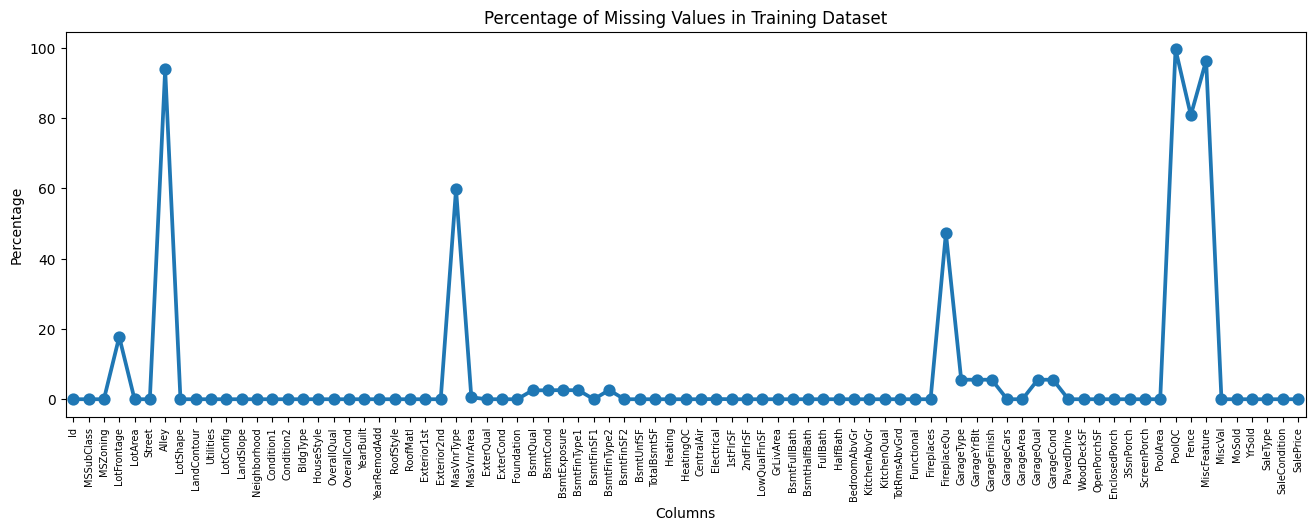

In [5]:
# Creation of new df to calculate percentage of missing data
missing = pd.DataFrame((df_train.isnull().sum()) * 100 / df_train.shape[0]).reset_index()
missing.columns = ['Column', 'Percentage']

# Plotting using seaborn
plt.figure(figsize=(16, 5))
ax = sns.pointplot(x='Column', y='Percentage', data=missing)
plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage of Missing Values in Training Dataset")
plt.ylabel("Percentage")
plt.xlabel("Columns")
plt.show()

The table below provide a confirmation with no missing data in the dataset as all variable have 0% of missing value.

In [6]:
# Calculate Nan percent in each column
nan_percent_pa = (df_train.isna().sum() / len(df_train)) * 100


# Create a DataFrame from the series
nan_percent_pa_df = nan_percent_pa.reset_index()
nan_percent_pa_df.columns = ['Column', 'NaN_Percent']


# Sort the DataFrame by the percentage of NaNs in ascending order
nan_percent_df = nan_percent_pa_df.sort_values(by='NaN_Percent', ascending=False)


# Print the top variable with missing data in the variable. Because there is 14 variable with missing data therefore only the top 14 is display.
nan_percent_df.head(10)

Column  NaN_Percent
72       PoolQC    99.520548
74  MiscFeature    96.301370
6         Alley    93.767123
73        Fence    80.753425
25   MasVnrType    59.726027
57  FireplaceQu    47.260274
3   LotFrontage    17.739726
59  GarageYrBlt     5.547945
64   GarageCond     5.547945
58   GarageType     5.547945

### Remove Variable

The code below show the removal os several variable due to high amount of missing observation within the dataset.

In [7]:
# Creating a list of column to be drop
column_to_drop = ['PoolQC',
                  'MiscFeature',
                  'Alley',
                  'Fence',
                  'MasVnrType',
                  'FireplaceQu',
                  'LotFrontage',
                  'Id']


# Drop the column on both dataset (Train and test set) 
df_train.drop(columns=column_to_drop, inplace =True)
df_test.drop(columns=column_to_drop, inplace = True)

### Handle Missing Value

Based on the line chart below, it show the remaining missing data within the variable. There is currently 11 column with missing data less than 5%.

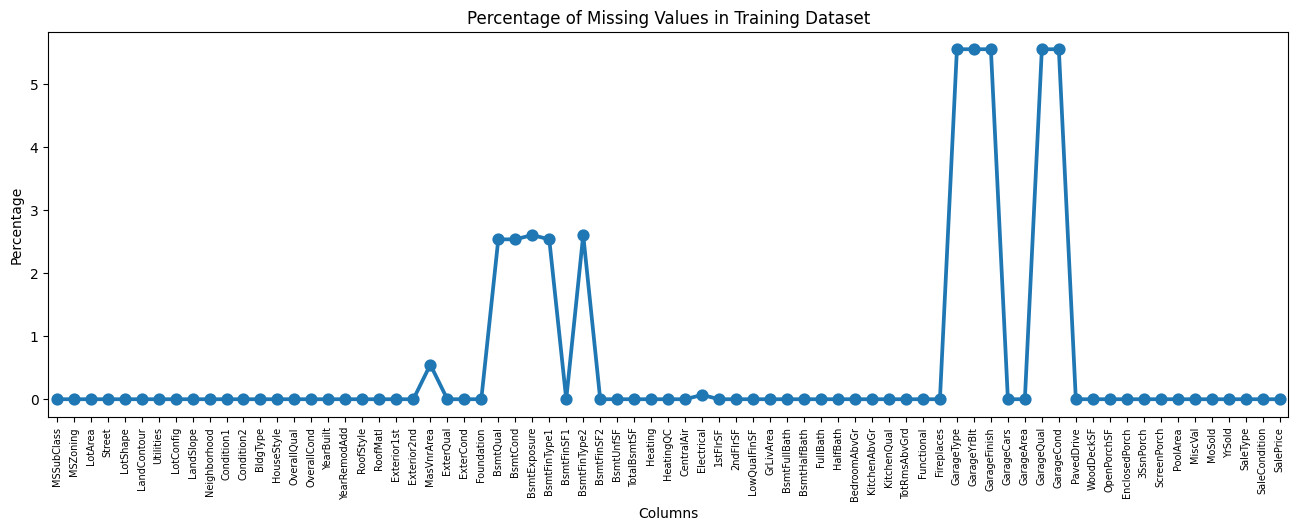

In [8]:
# Creation of new df to calculate percentage of missing data
missing = pd.DataFrame((df_train.isnull().sum()) * 100 / df_train.shape[0]).reset_index()
missing.columns = ['Column', 'Percentage']

# Plotting using seaborn
plt.figure(figsize=(16, 5))
ax = sns.pointplot(x='Column', y='Percentage', data=missing)
plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage of Missing Values in Training Dataset")
plt.ylabel("Percentage")
plt.xlabel("Columns")
plt.show()

The code below segregate the variable into the respective data types.

In [9]:
# Empty list for storing variable with missing data
variables = []


# Create a for loop identifying variable with missing data
for col in df_train.columns:
    if df_train[col].isnull().any():
        variables.append(col)


# Empty list for storing categorical data
numeric = []
object = []


# For loop to identify the data types and appending it
for variable in variables:
    if df_train[variable].dtypes == 'float64' or df_train[variable].dtypes == 'int':
        numeric.append(variable)
    else:
        object.append(variable)


# Print out the variable based on category
print('Numeric Data Structure')
for i,item in enumerate(numeric):
    print(i,item)
print('\n')

print('Object Data Structure')
for i,item in enumerate(object):
    print(i,item)

Numeric Data Structure
0 MasVnrArea
1 GarageYrBlt


Object Data Structure
0 BsmtQual
1 BsmtCond
2 BsmtExposure
3 BsmtFinType1
4 BsmtFinType2
5 Electrical
6 GarageType
7 GarageFinish
8 GarageQual
9 GarageCond


Calculating the mean for the variable with missing data to replace the missing values.

In [10]:
mean = []

for j in numeric:
    m = df_train[j].mean().round(2)
    mean.append(m)
    print(j,m)

MasVnrArea 103.69
GarageYrBlt 1978.51


Calculating the mode for the variable with missing data to replace the missing values.

In [11]:
mode = []

for j in object:
   n = df_train[j].mode()[0]
   mode.append(n)

Replace the numeric missing value

In [12]:
numeric_tuple = zip(numeric,mean)

# .infer_objects(copy = False)
# It is a function which it will create another copy of the original data frame
# The goal is to infer the data type again after data manipulation

for col,value in numeric_tuple:
    df_train[col] = df_train[col].fillna(value).infer_objects(copy=False)

Replacing the object missing value

In [13]:
object_tuple = zip(object,mode)

# .infer_objects(copy = False)
# It is a function which it will create another copy of the original data frame
# The goal is to infer the data type again after data manipulation

for col,value in object_tuple:
    df_train[col] = df_train[col].fillna(value).infer_objects(copy=False)

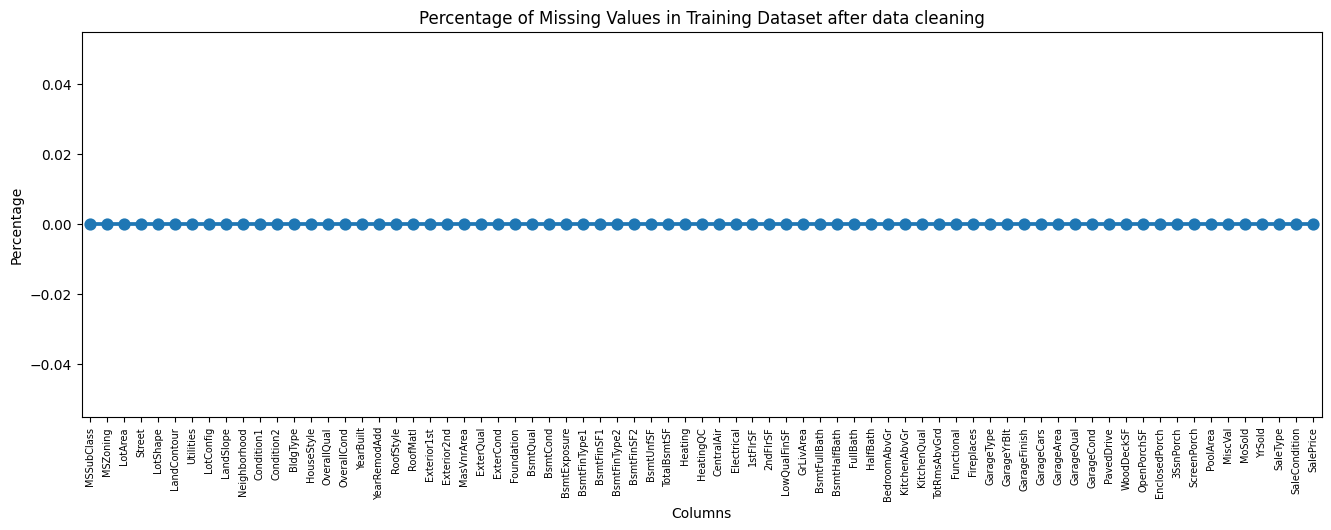

In [14]:
# Creation of new df to calculate percentage of missing data
missing = pd.DataFrame((df_train.isnull().sum()) * 100 / df_train.shape[0]).reset_index()
missing.columns = ['Column', 'Percentage']

# Plotting using seaborn
plt.figure(figsize=(16, 5))
ax = sns.pointplot(x='Column', y='Percentage', data=missing)
plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage of Missing Values in Training Dataset after data cleaning")
plt.ylabel("Percentage")
plt.xlabel("Columns")
plt.show()

## EDA

In [15]:
# Identify the unique type of dtypes in the dataset
df_train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [16]:
# Seperating the variable into data types
numeric_variable = []
object_variable = []

for variable in df_train:
    if df_train[variable].dtypes == 'float64' or df_train[variable].dtypes == 'int64':
        numeric_variable.append(variable)
    else:
        object_variable.append(variable)

In [17]:
numeric_variable

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [18]:
object_variable

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

### Univariate Analysis

#### Descriptive Statistics

In [19]:
df_train.describe()

MSSubClass        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1460.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     56.897260   10516.828082     6.099315     5.575342  1971.267808   
std      42.300571    9981.264932     1.382997     1.112799    30.202904   
min      20.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      20.000000    7553.500000     5.000000     5.000000  1954.000000   
50%      50.000000    9478.500000     6.000000     5.000000  1973.000000   
75%      70.000000   11601.500000     7.000000     6.000000  2000.000000   
max     190.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count   1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean    1984.865753   103.685288   443.639726    46.549315   567.240411  ...   
std       20.645407   180.569112   456.098091   161.319273   441.866955  ...   
min     1950.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     1967.000000     0.000000     0.000000     0.000000   223.000000  ...   
50%     1994.000000     0.000000   383.500000     0.000000   477.500000  ...   
75%     2004.000000   164.250000   712.250000     0.000000   808.000000  ...   
max     2010.000000  1600.000000  5644.000000  1474.000000  2336.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 36 columns]

#### Numeric Variable

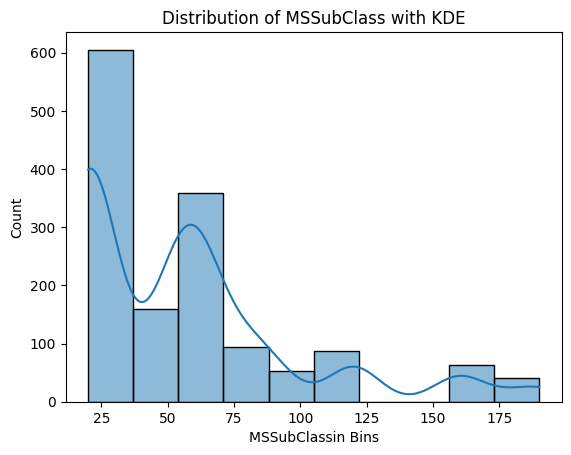

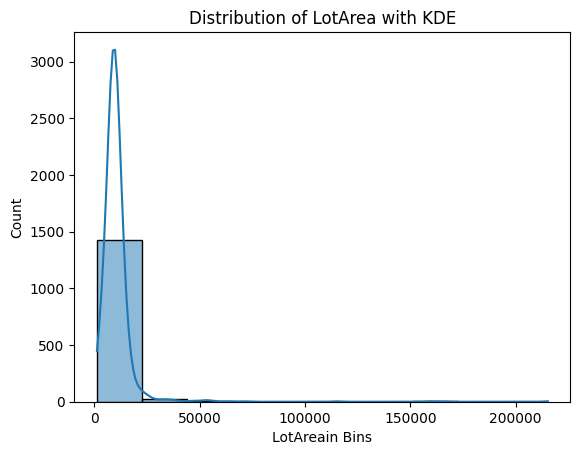

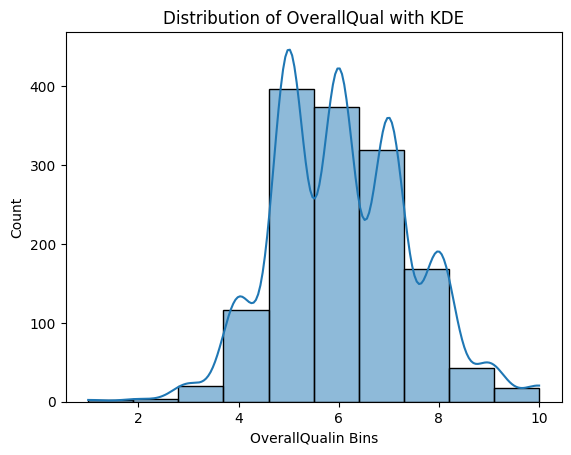

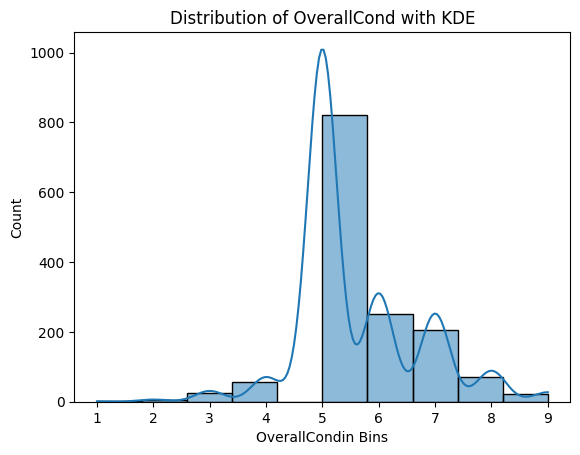

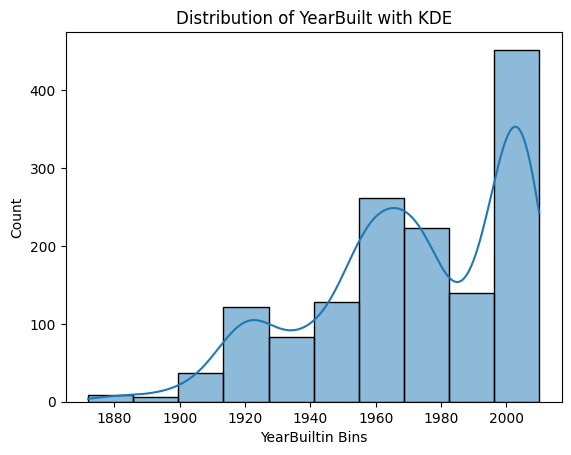

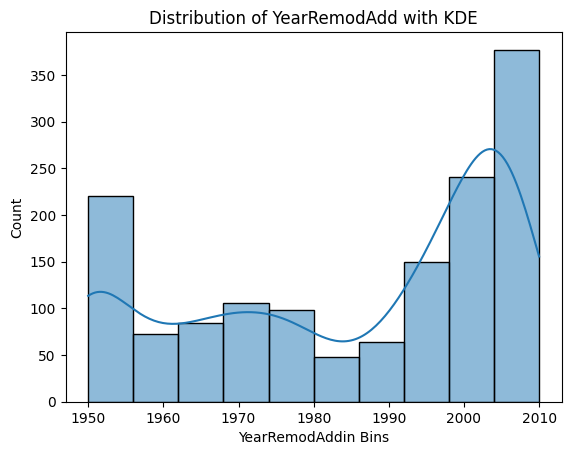

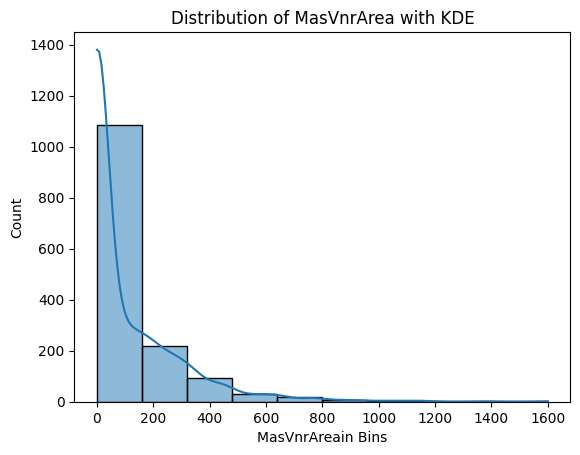

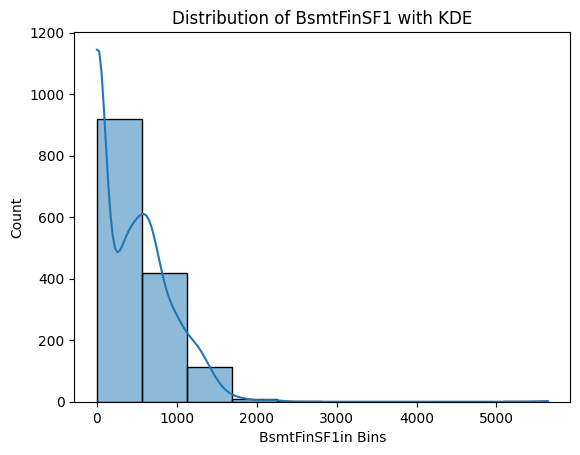

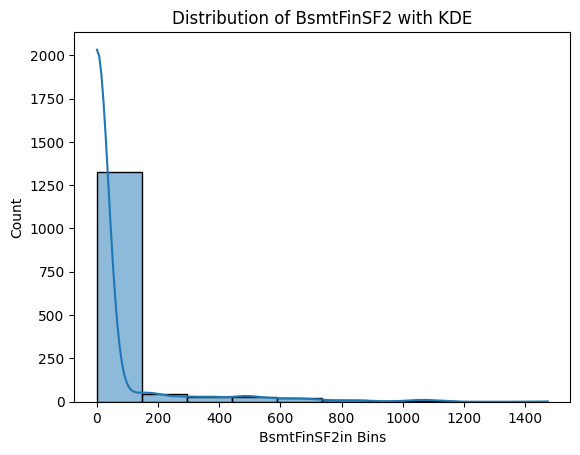

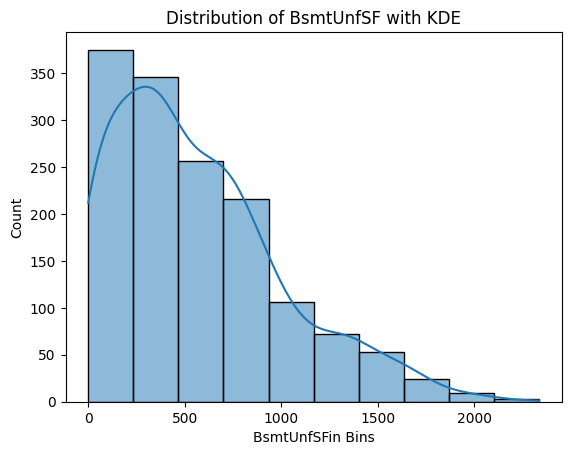

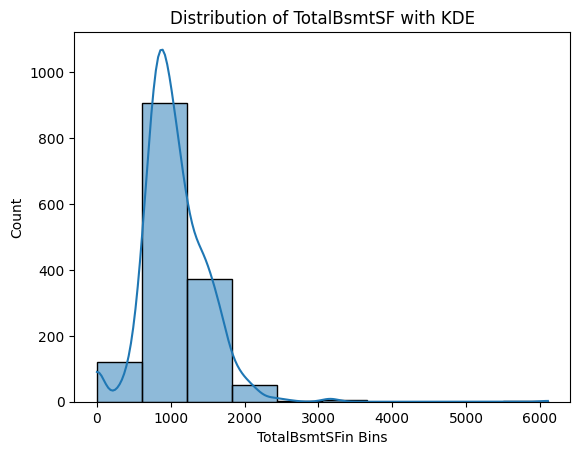

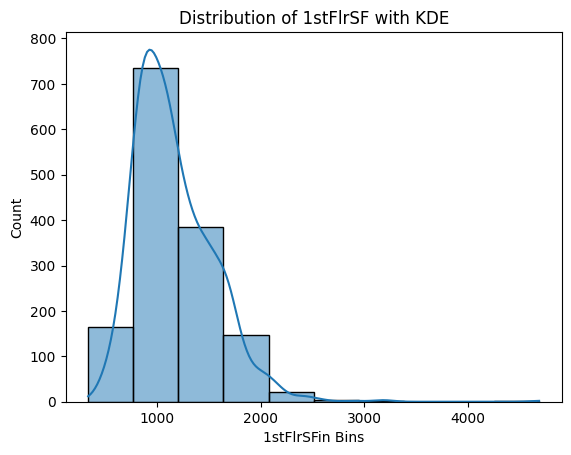

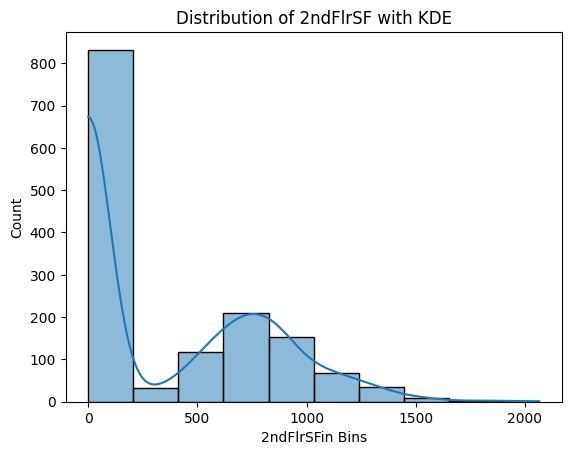

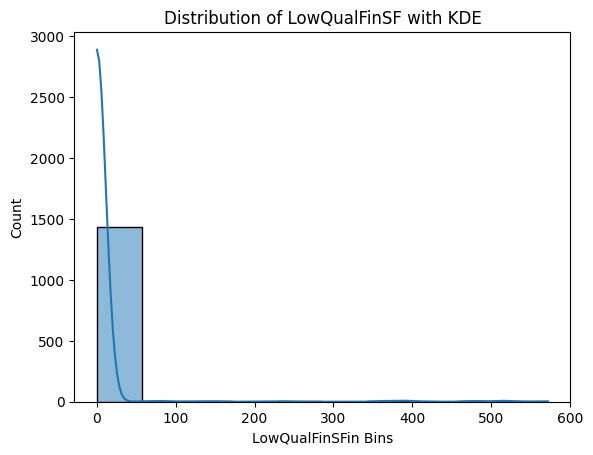

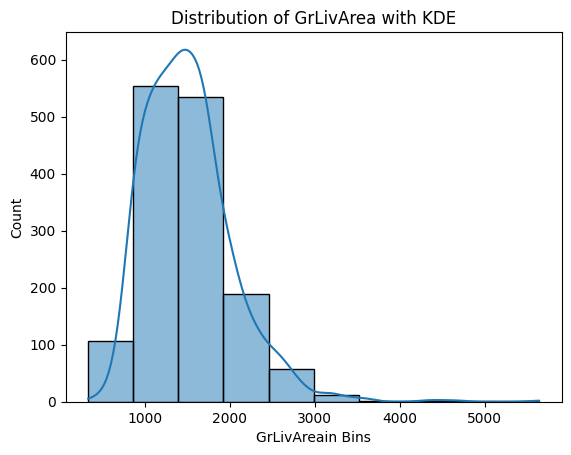

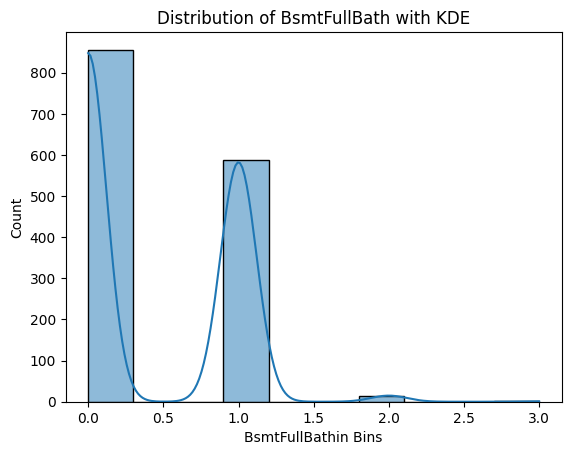

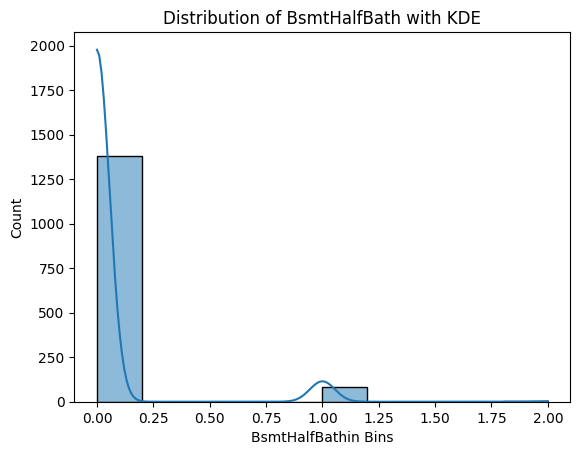

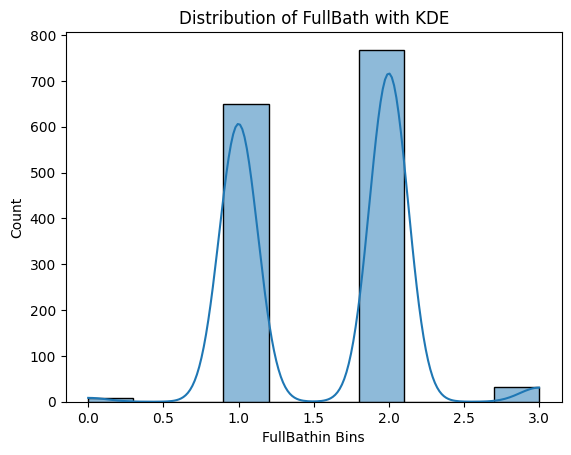

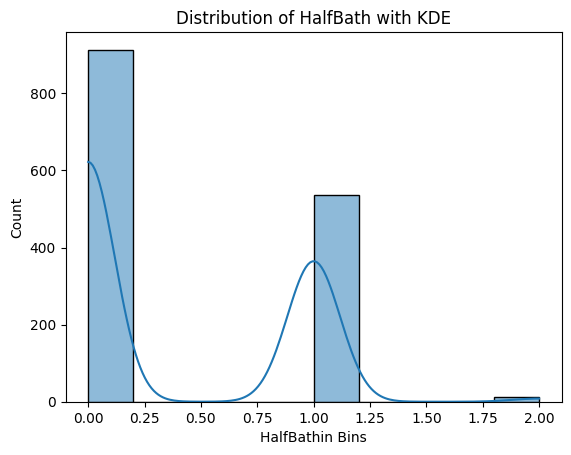

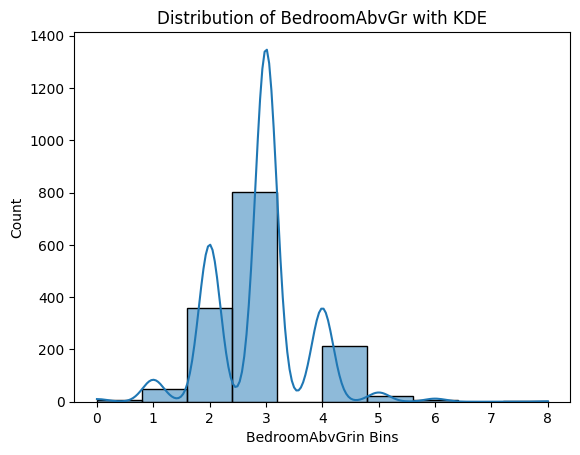

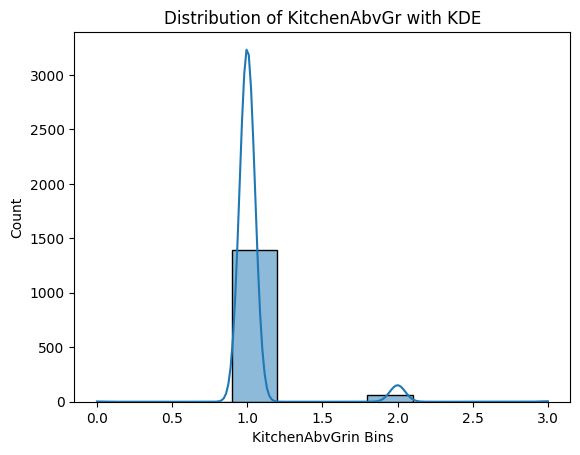

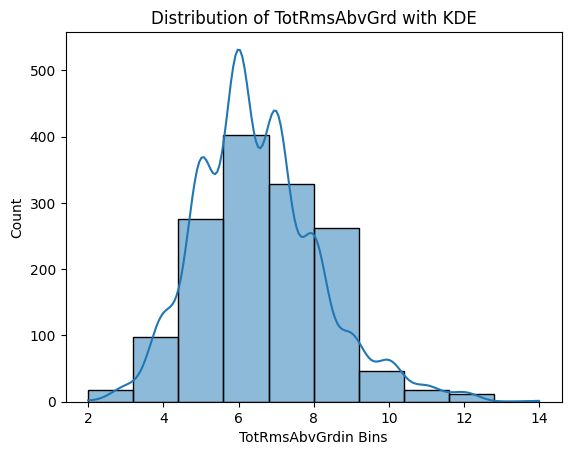

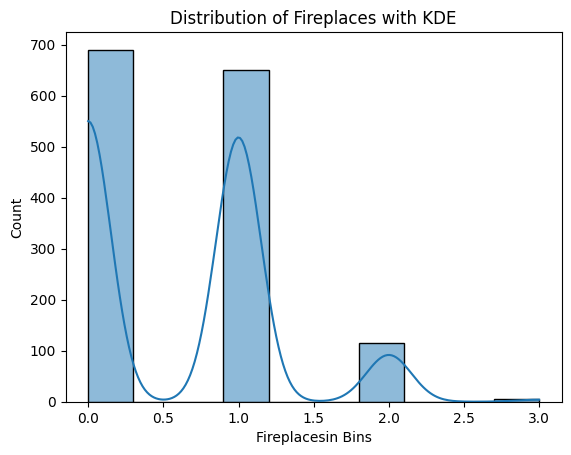

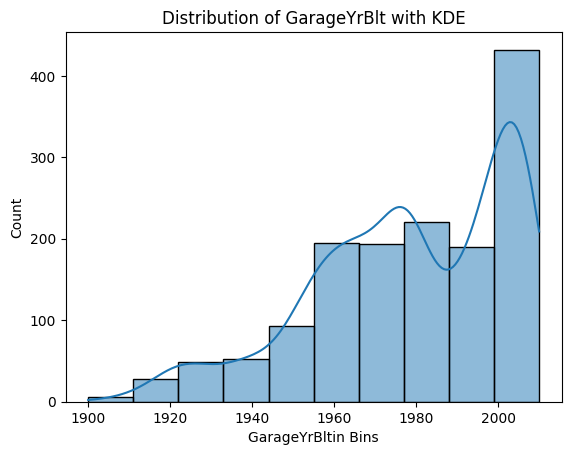

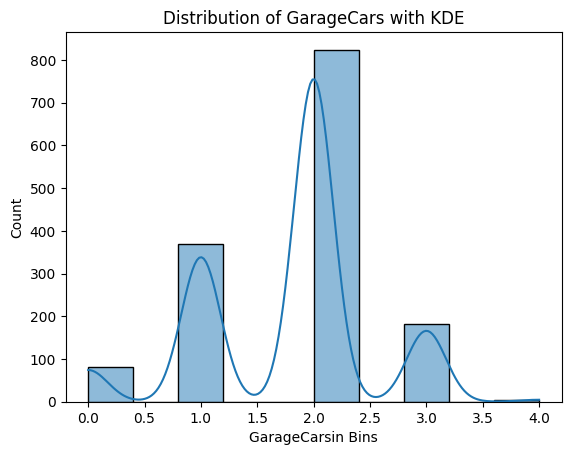

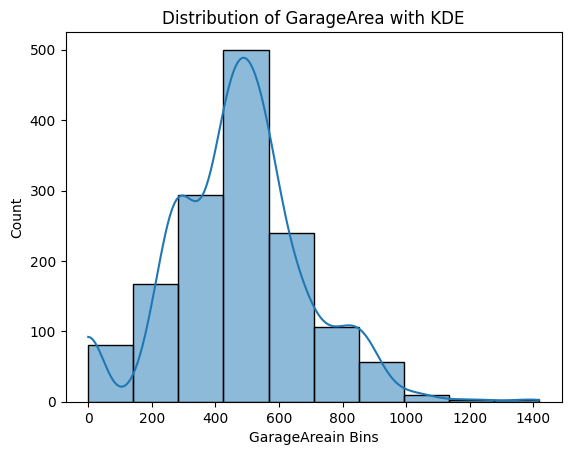

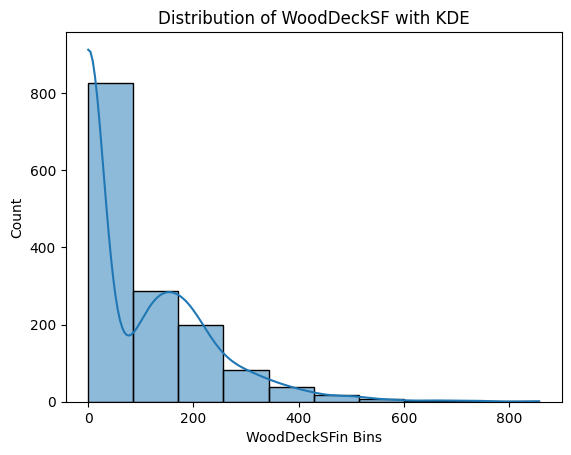

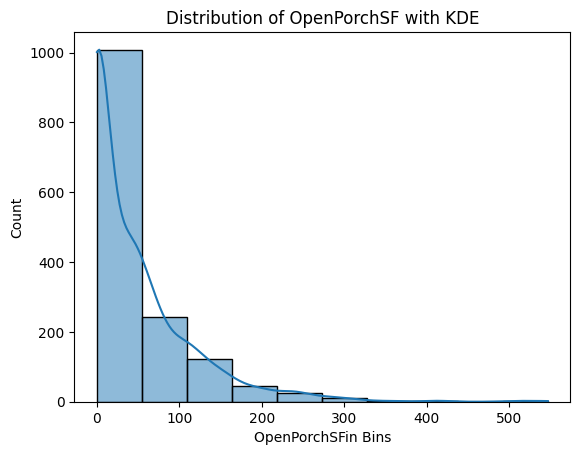

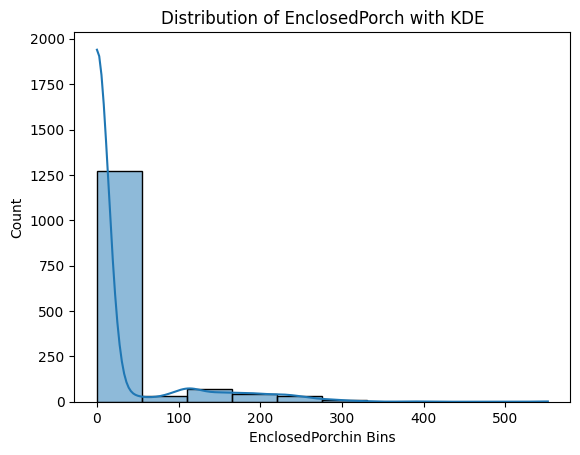

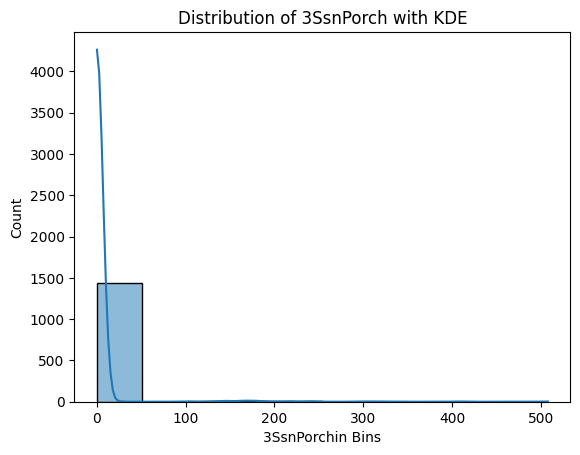

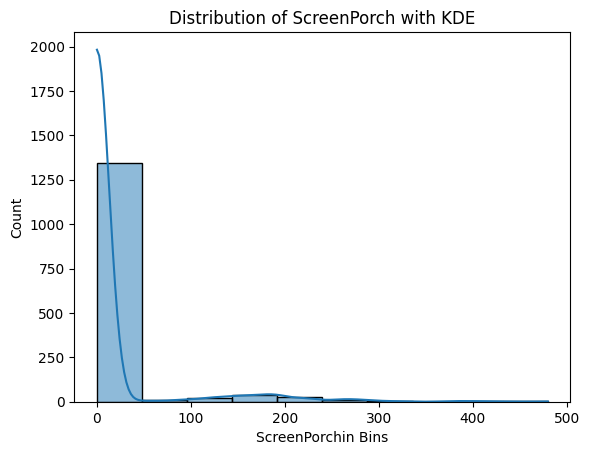

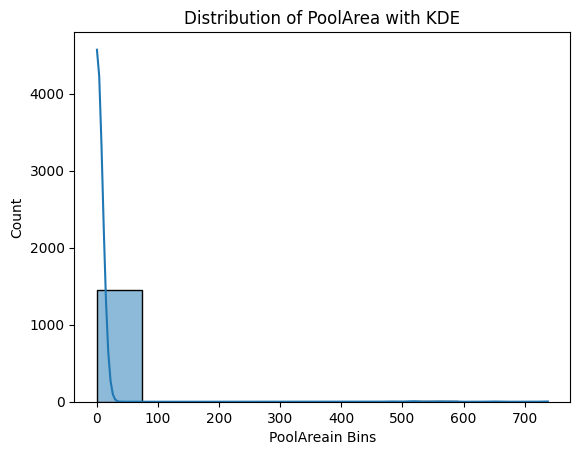

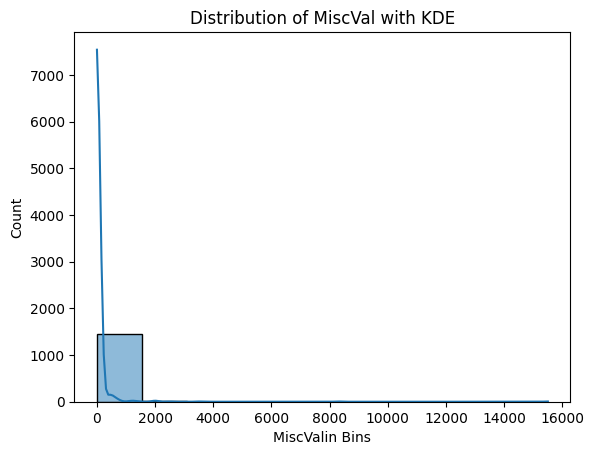

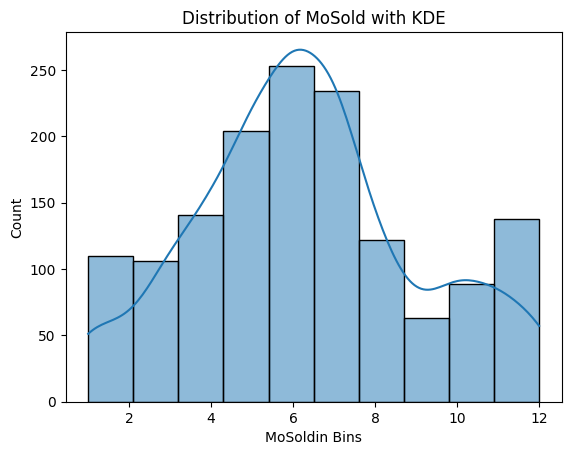

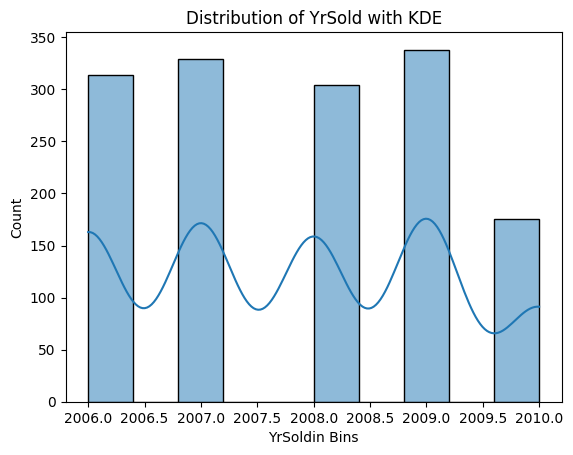

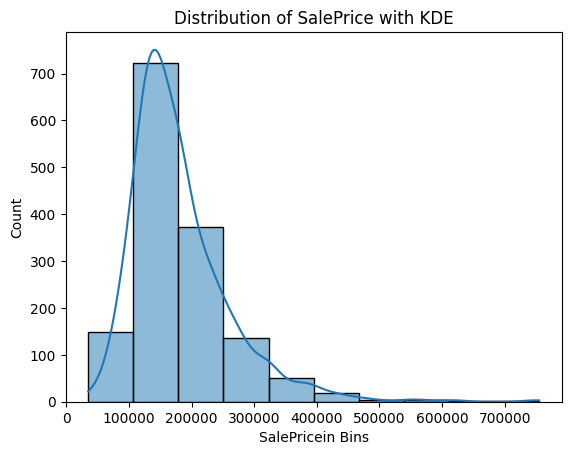

In [20]:
for col in numeric_variable:
    sns.histplot(df_train[col], bins=10, kde=True, edgecolor='k')  # Use sns.histplot with kde=True to include KDE
    plt.xlabel(f'{col}in Bins')
    plt.ylabel('Count')
    plt.title(f'Distribution of {col} with KDE')
    plt.show()


#### Object Variable

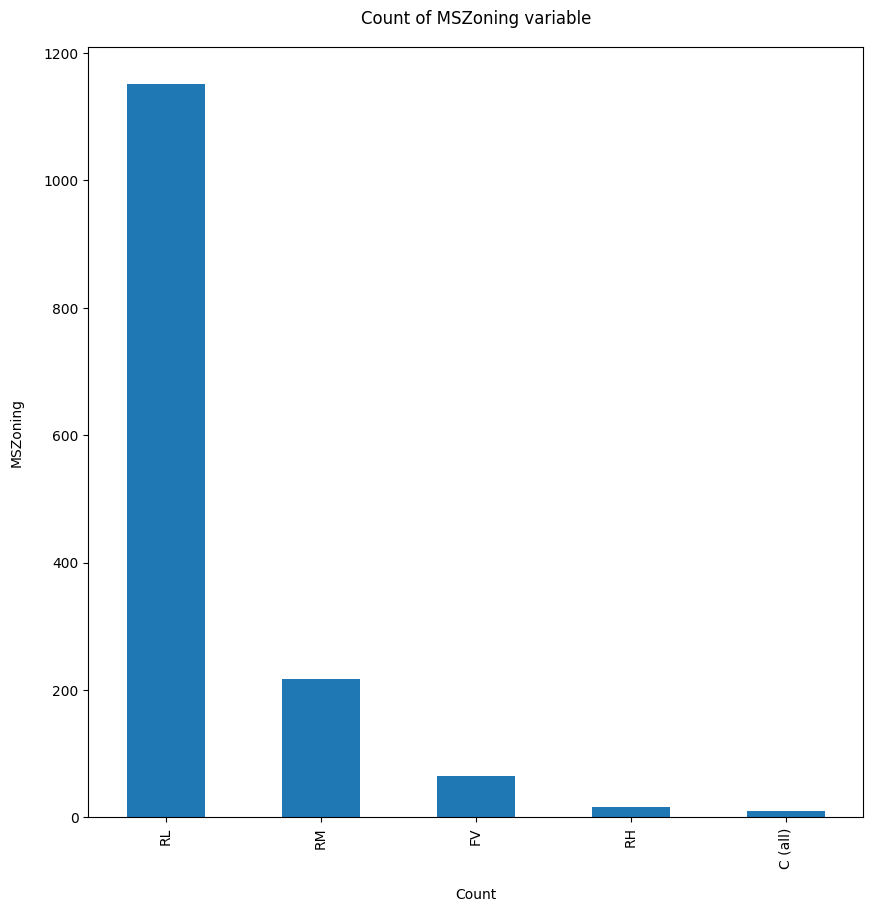

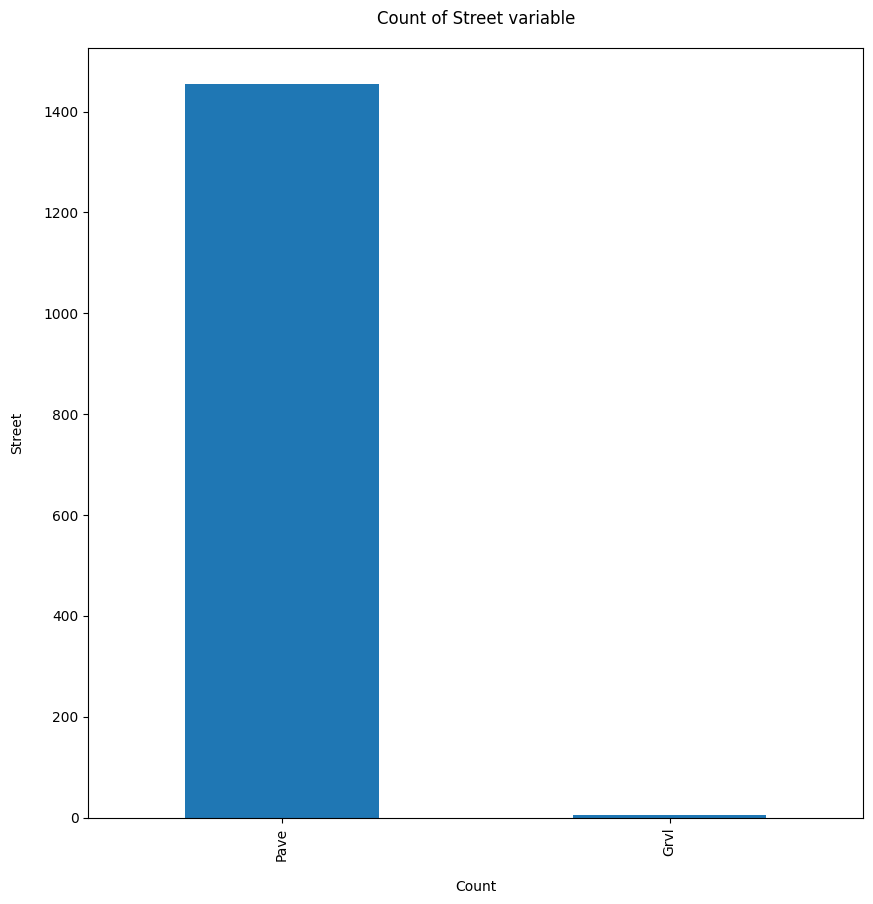

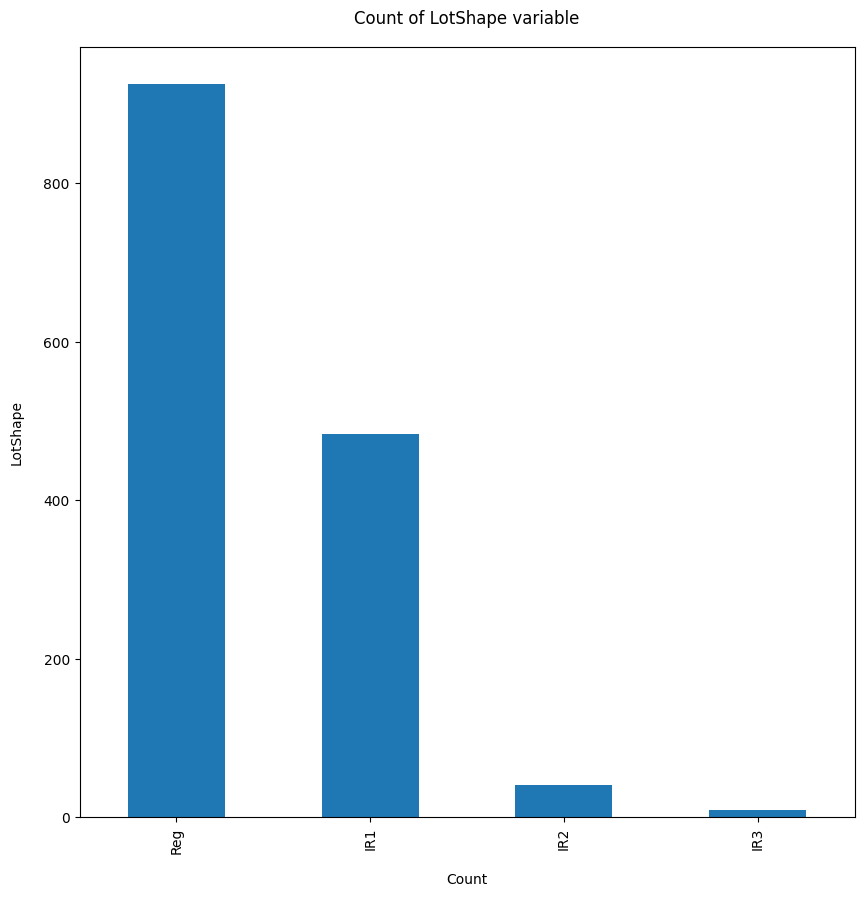

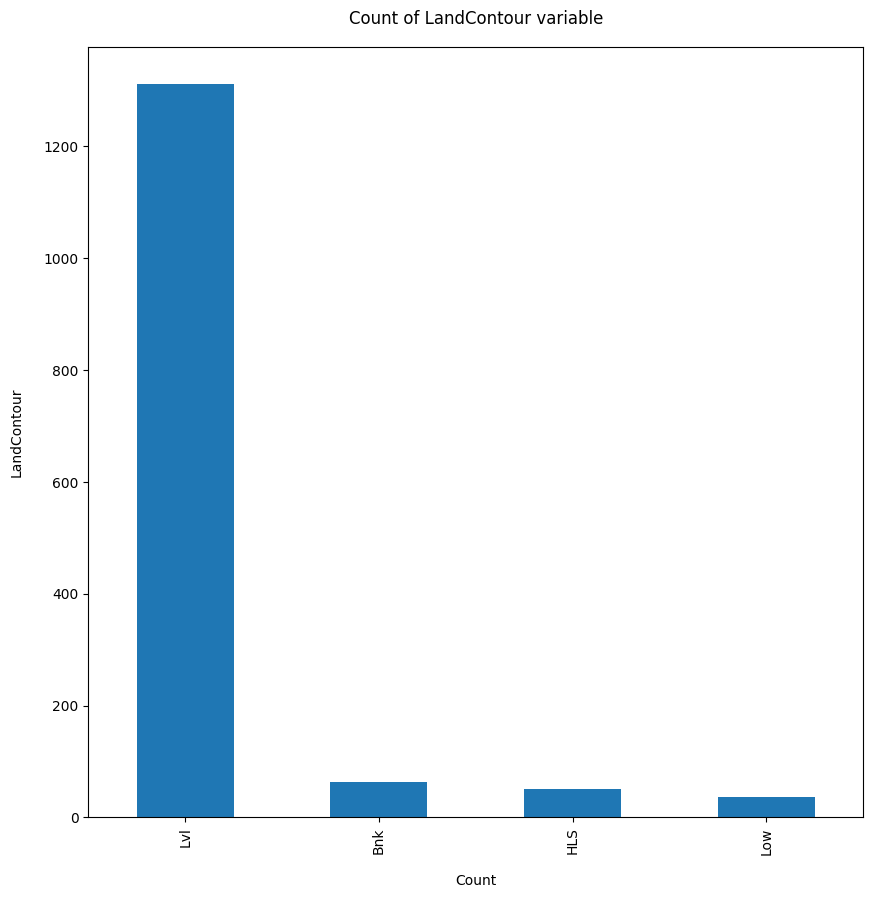

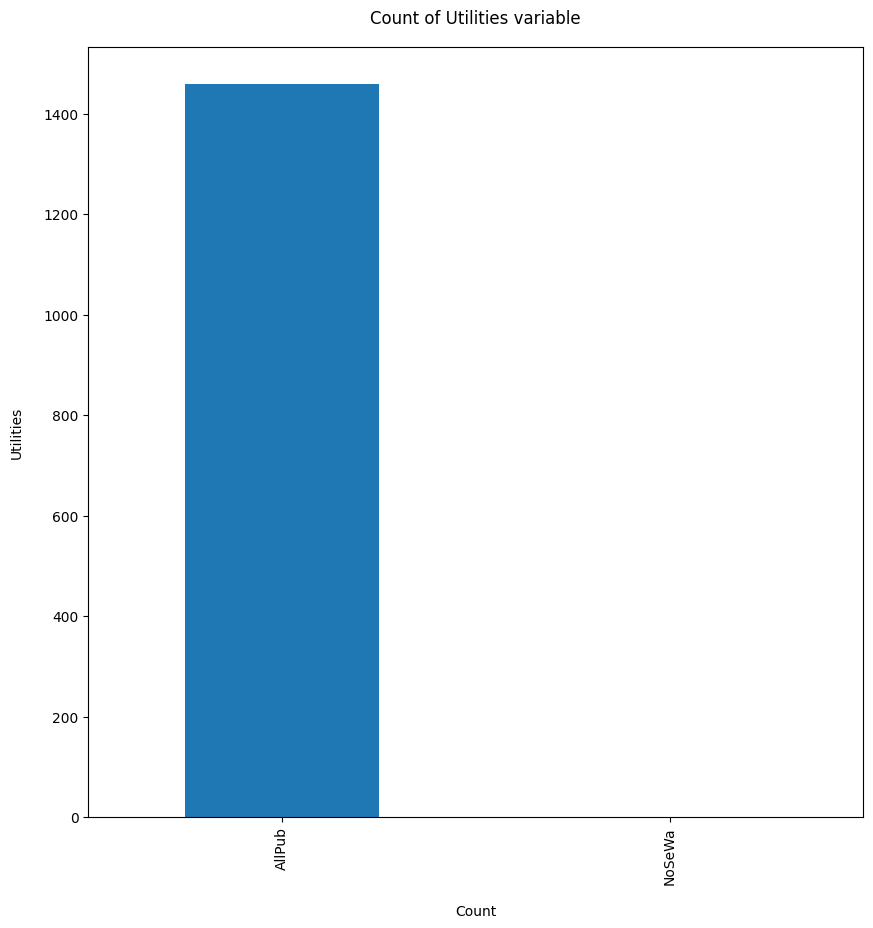

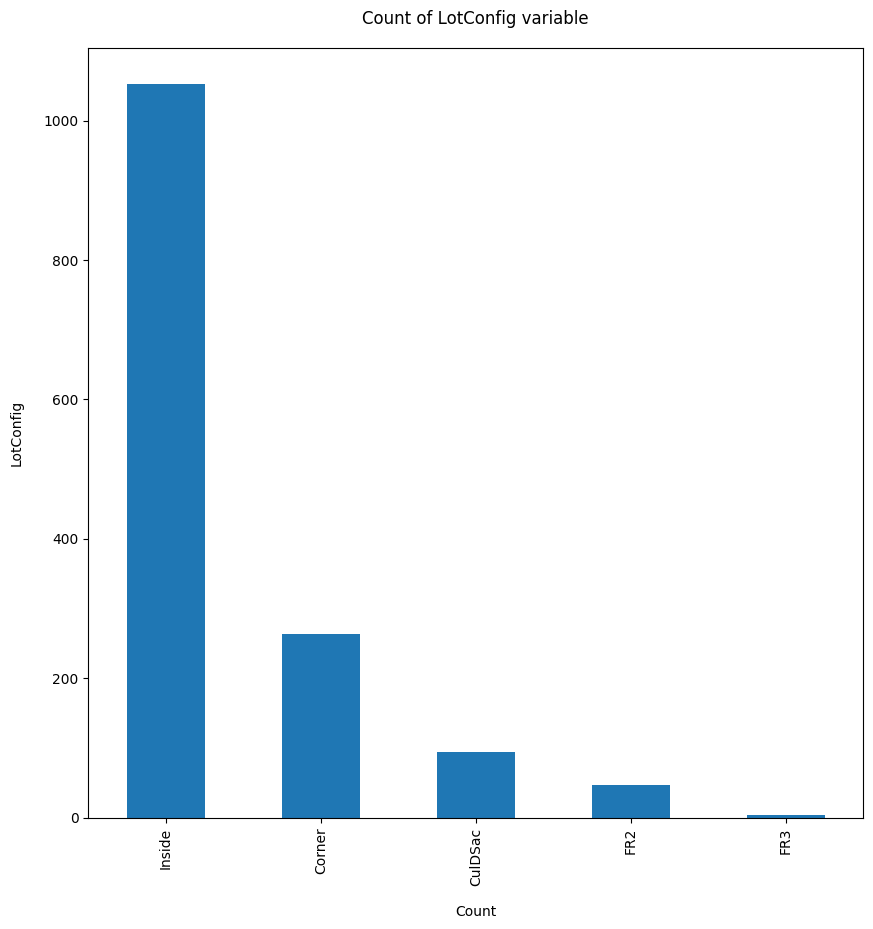

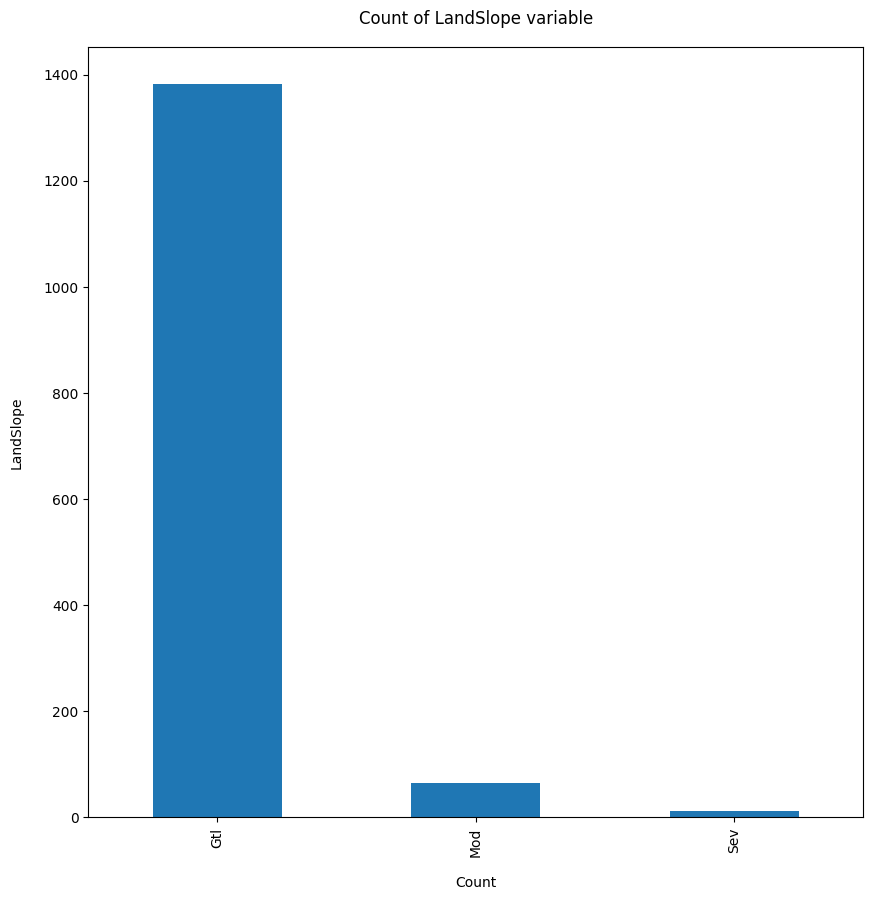

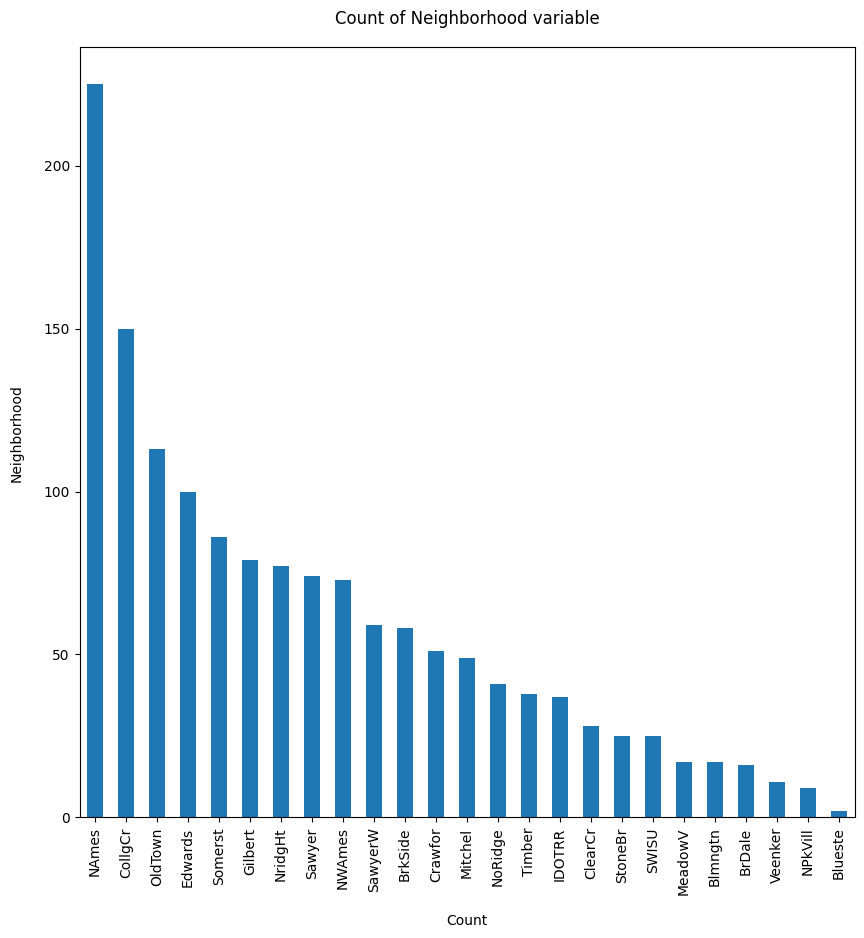

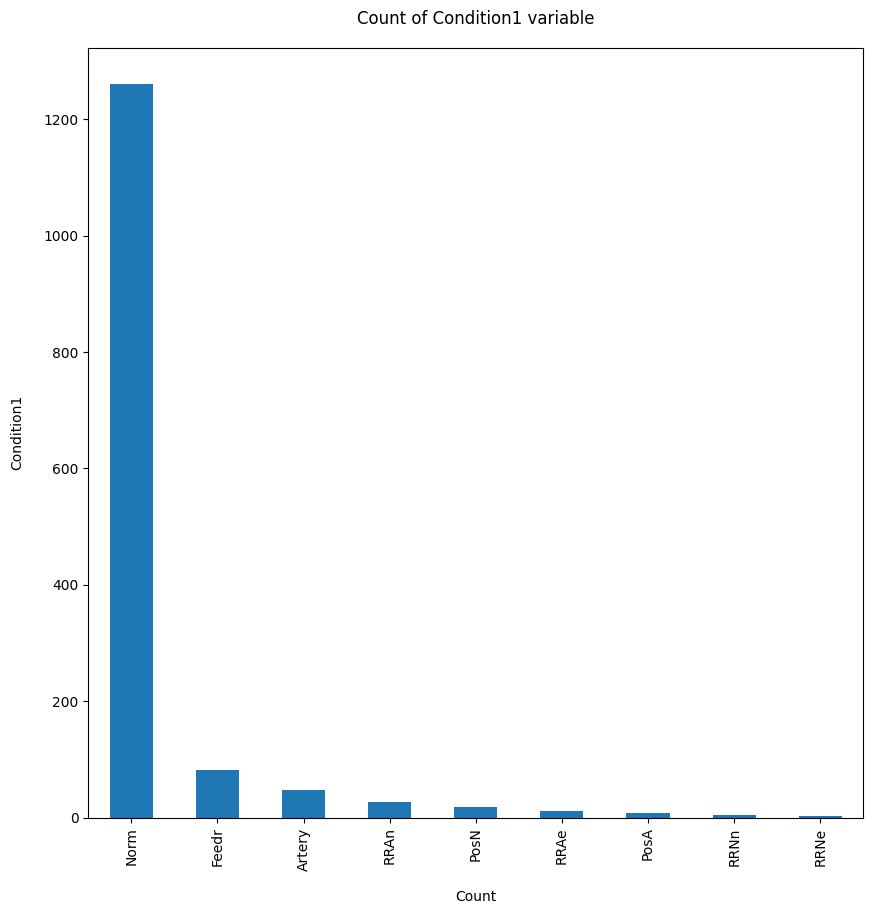

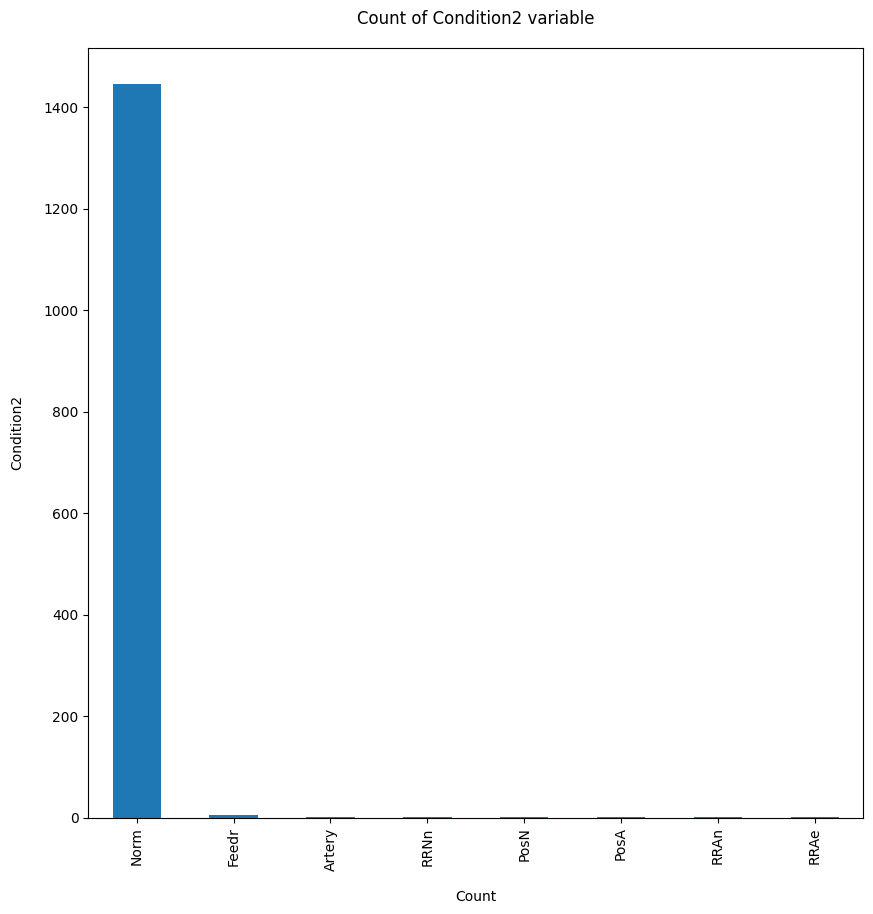

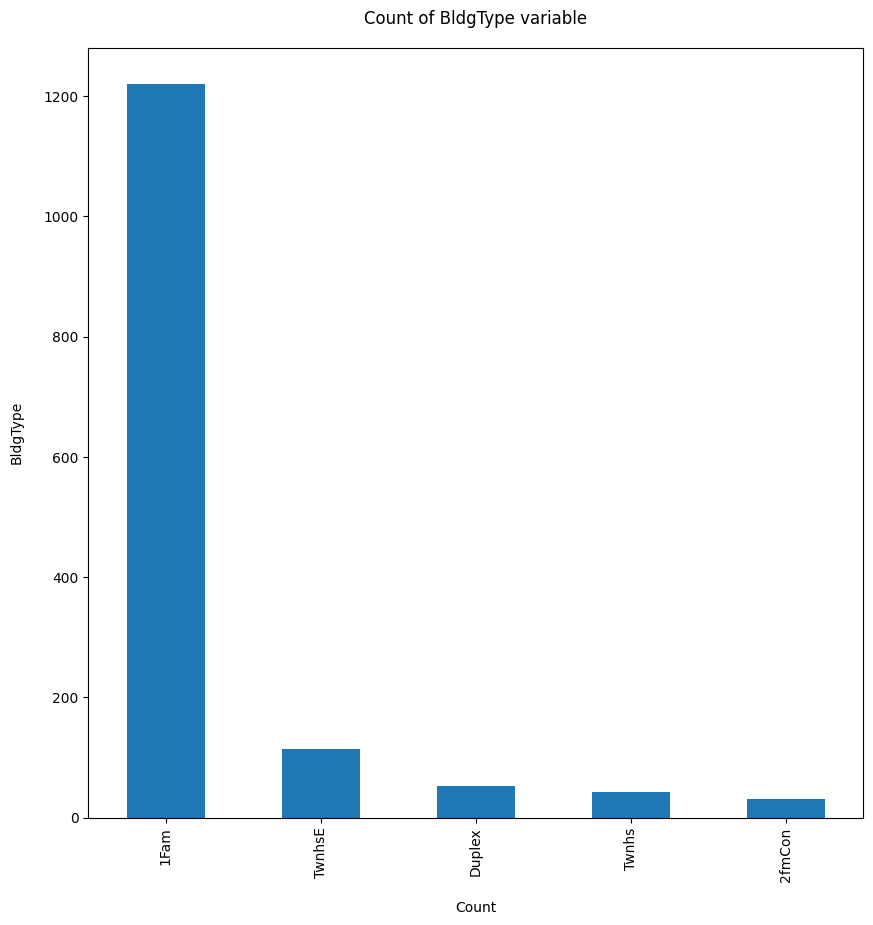

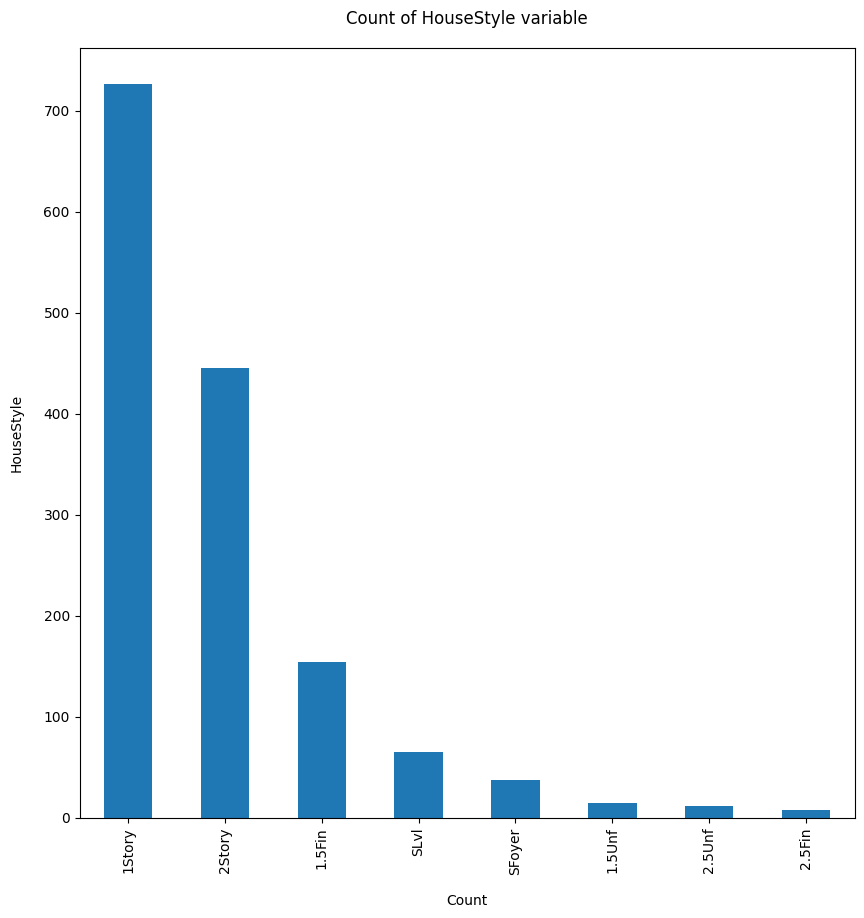

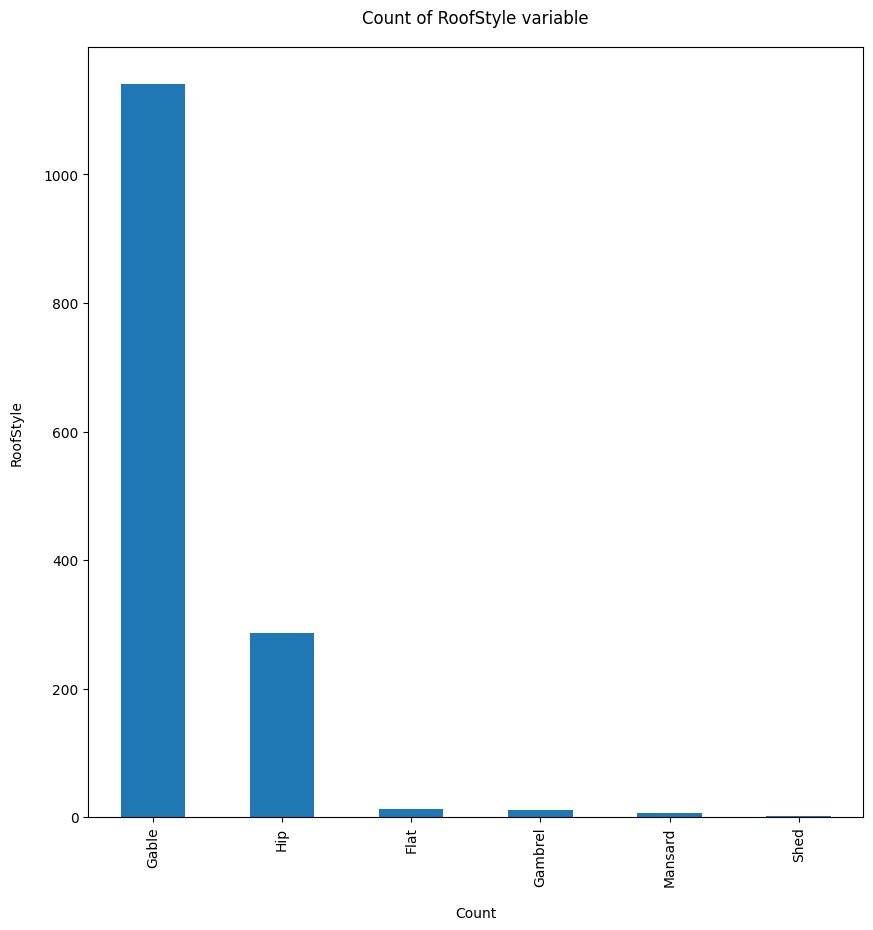

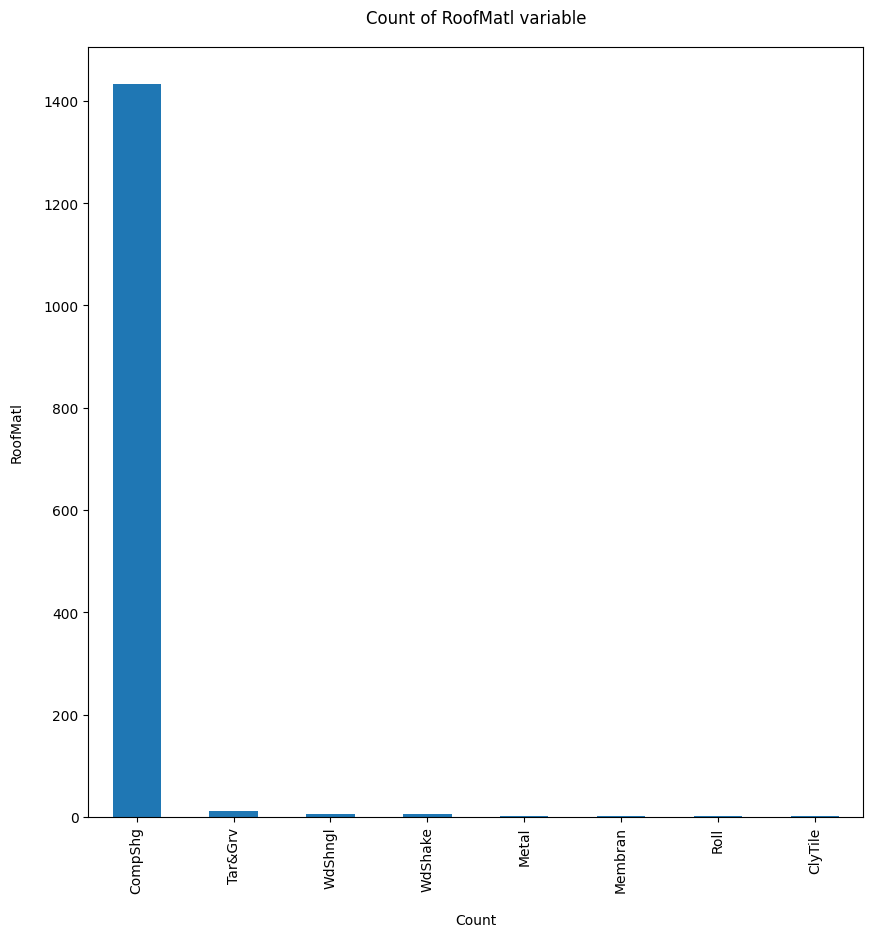

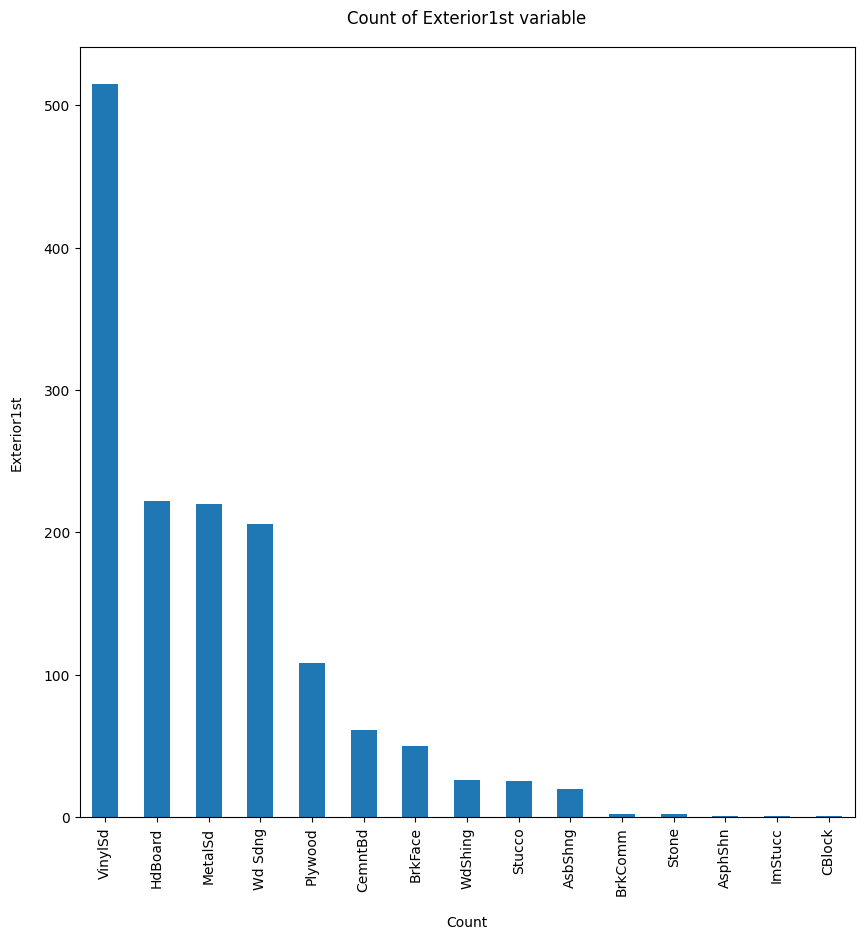

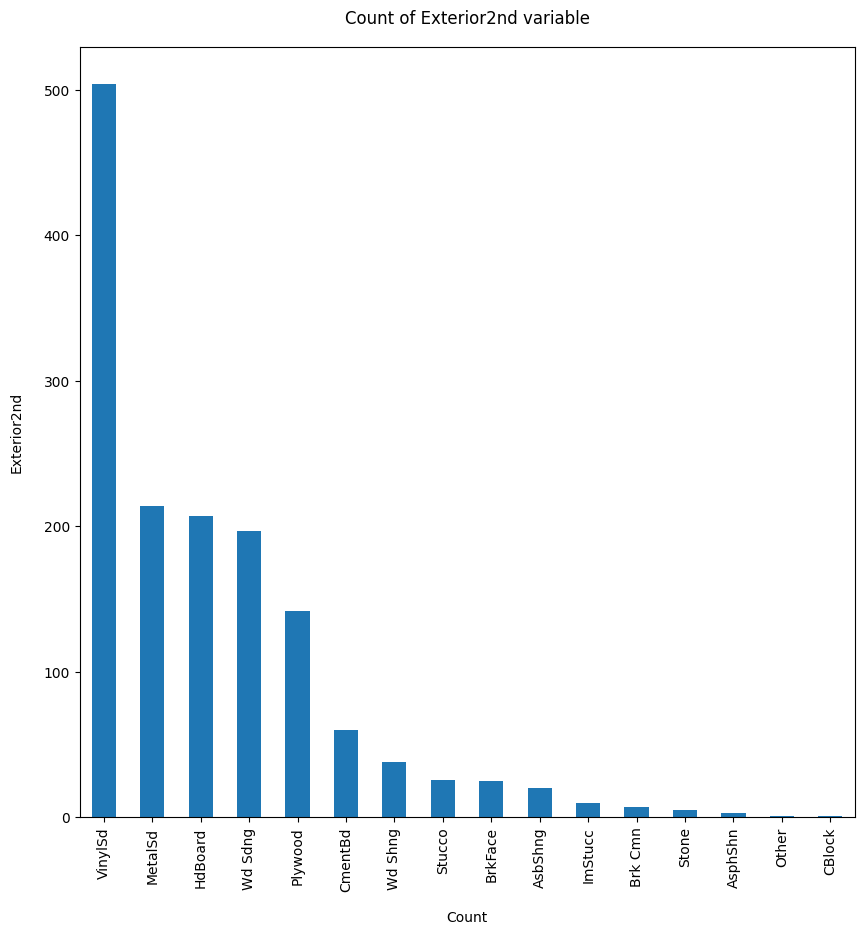

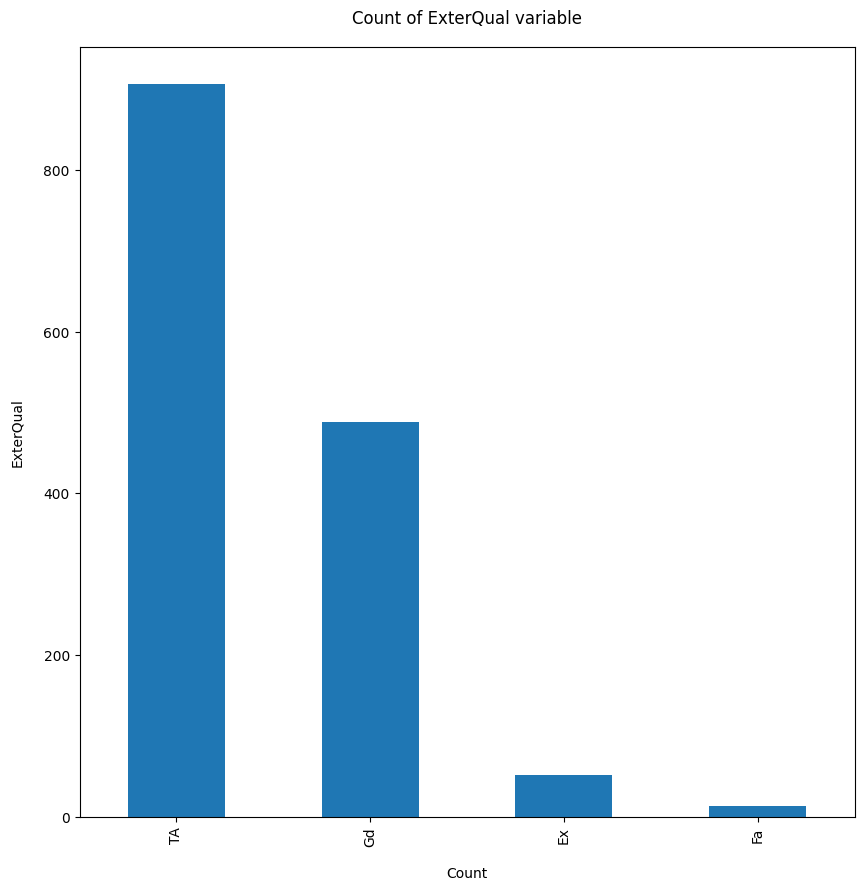

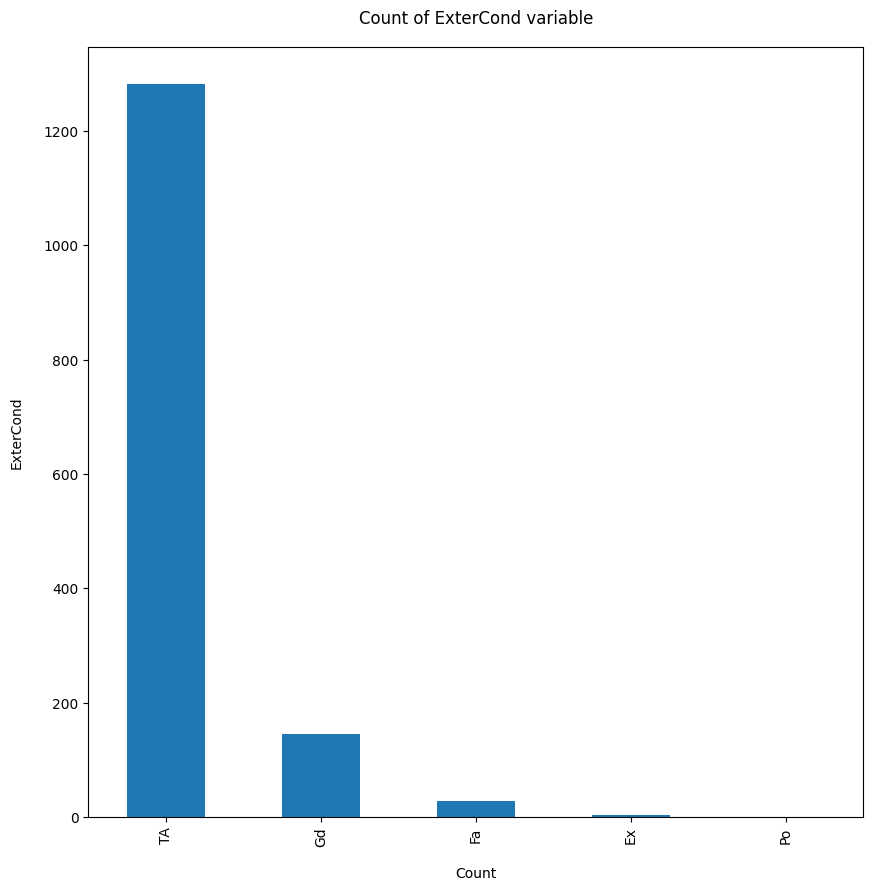

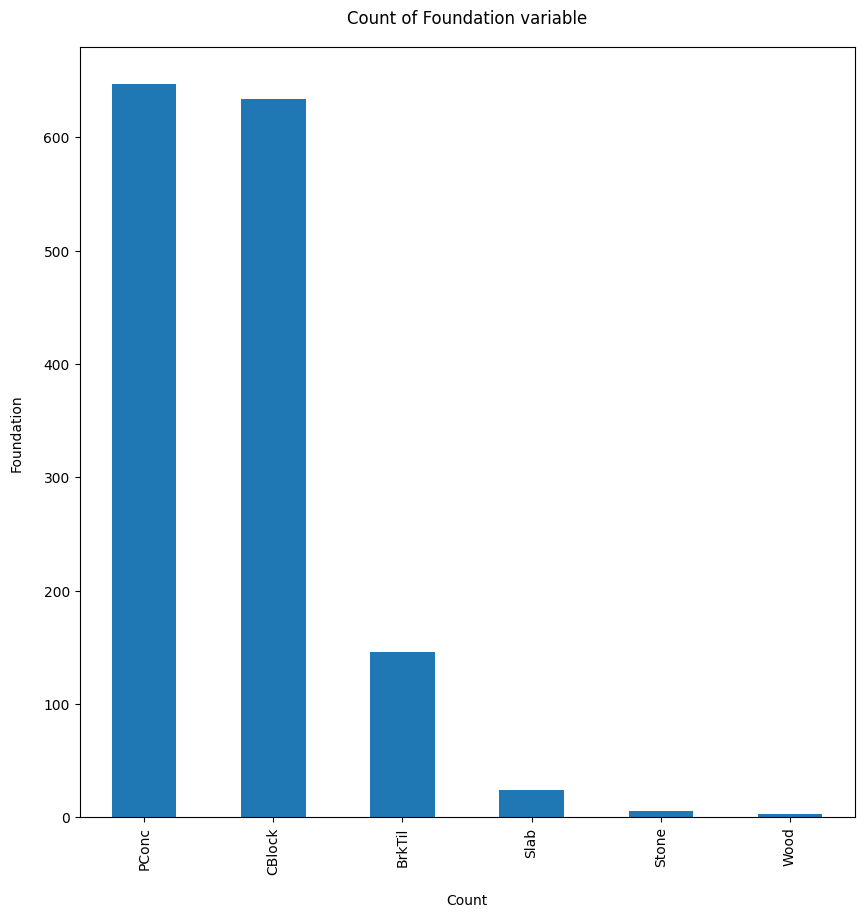

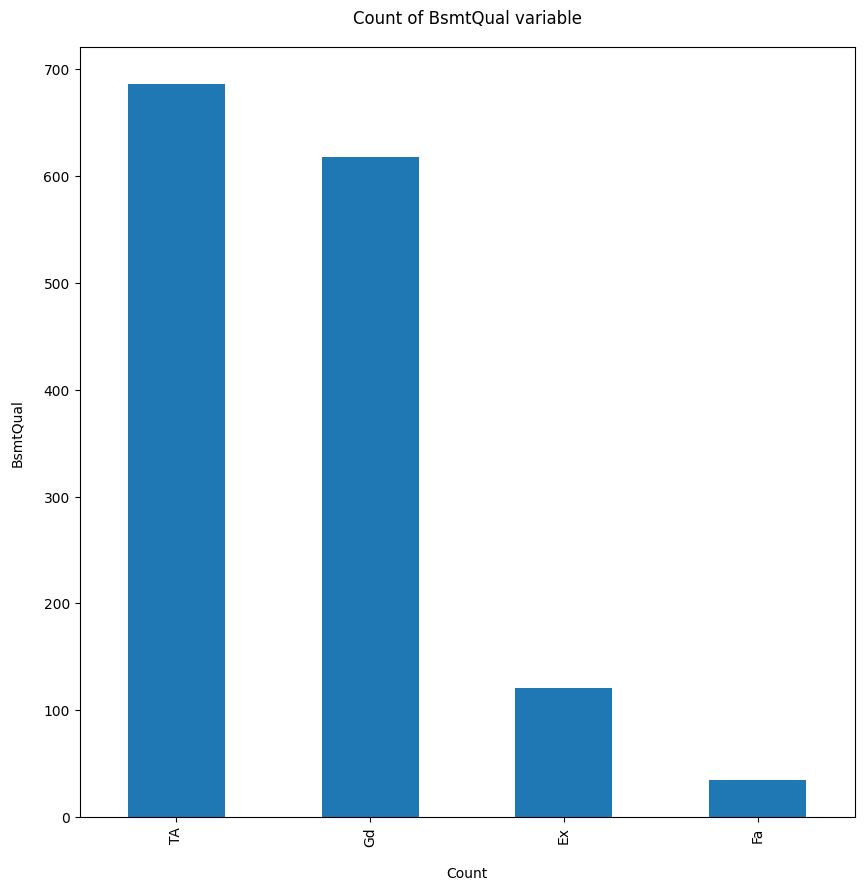

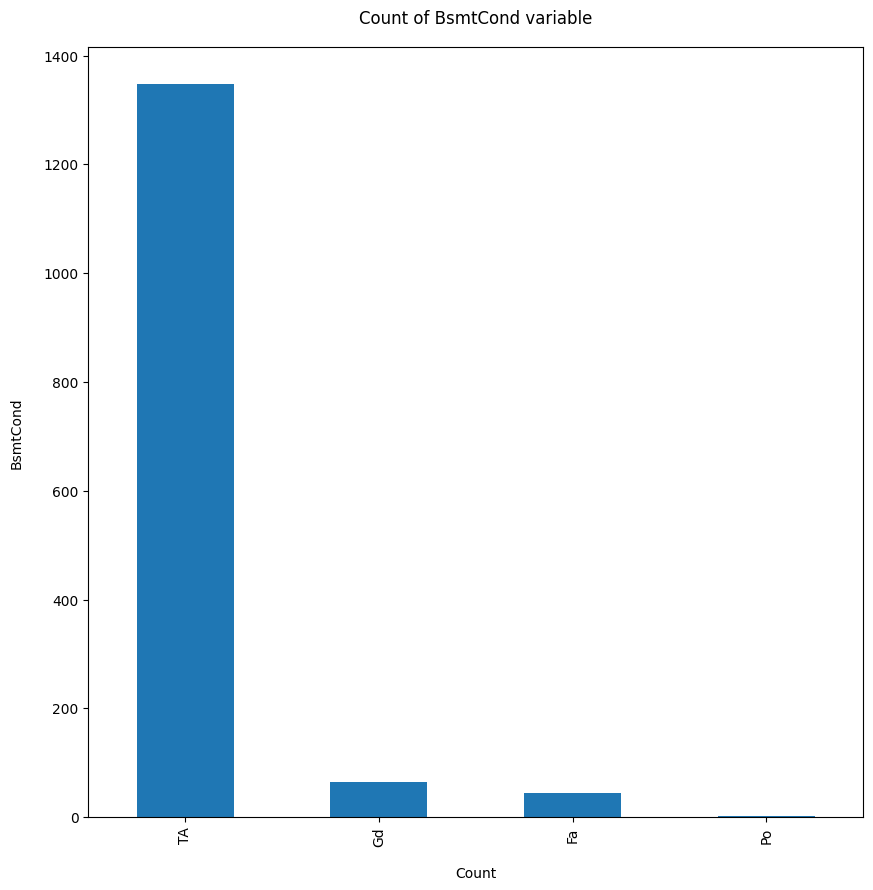

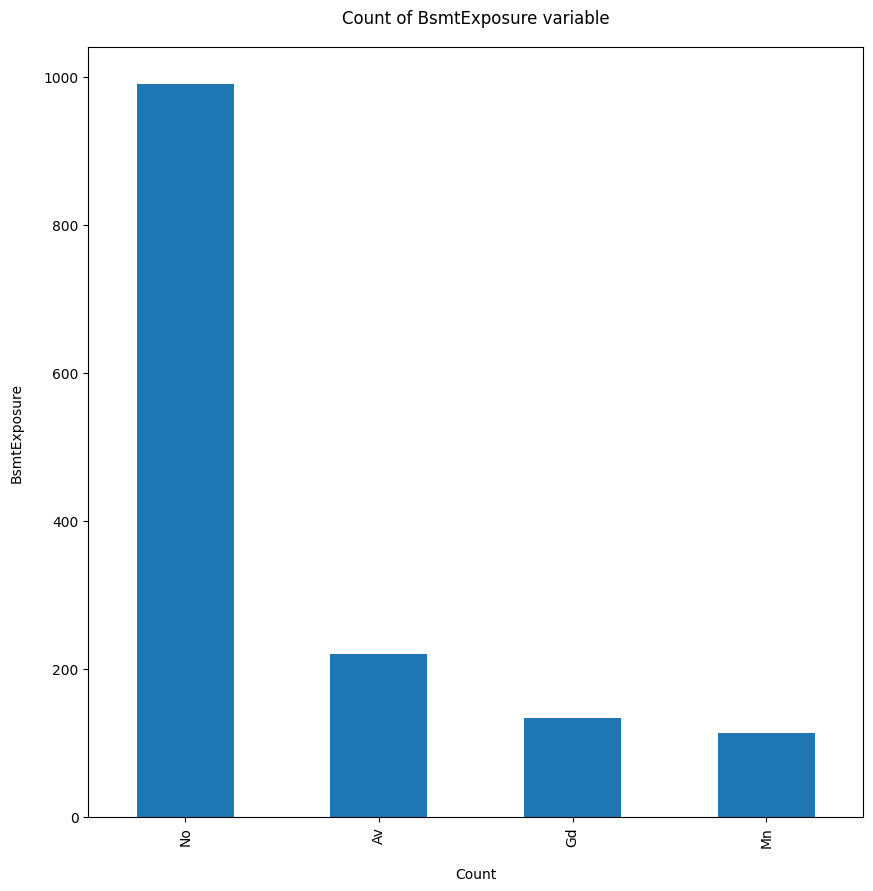

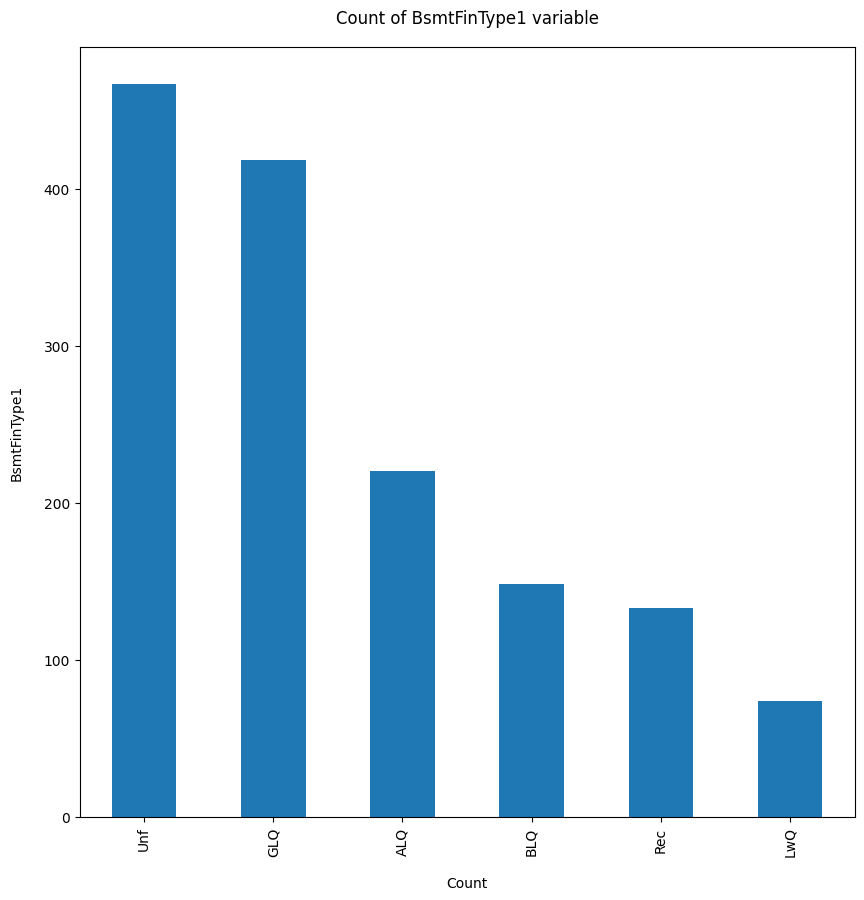

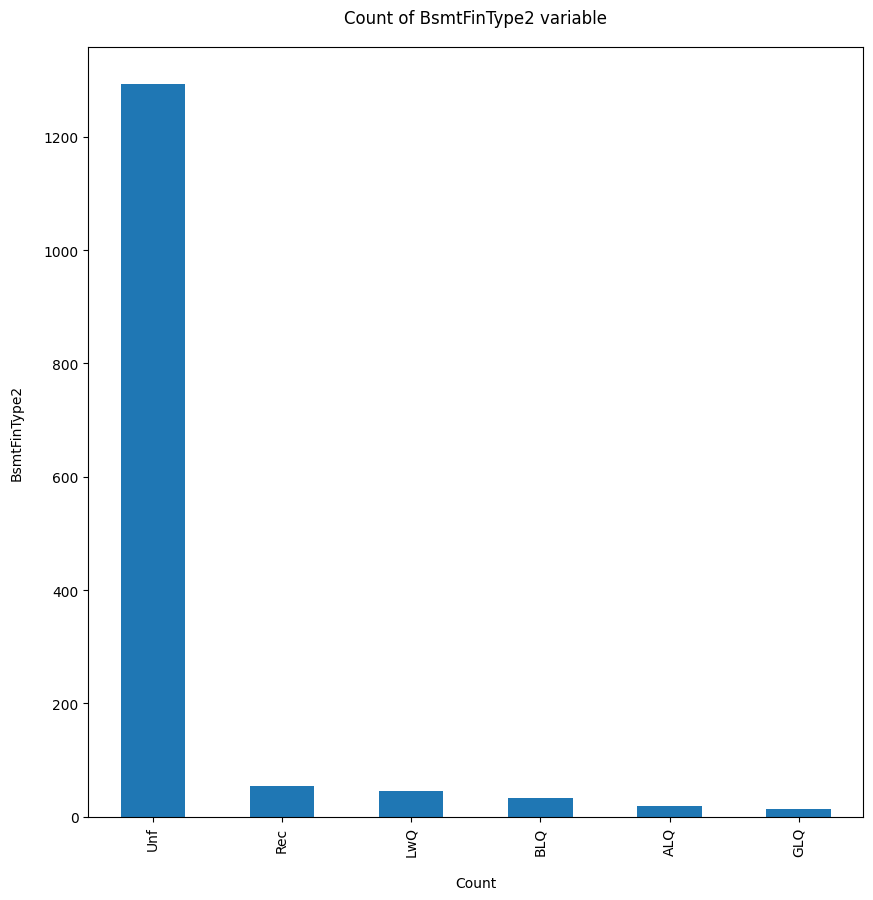

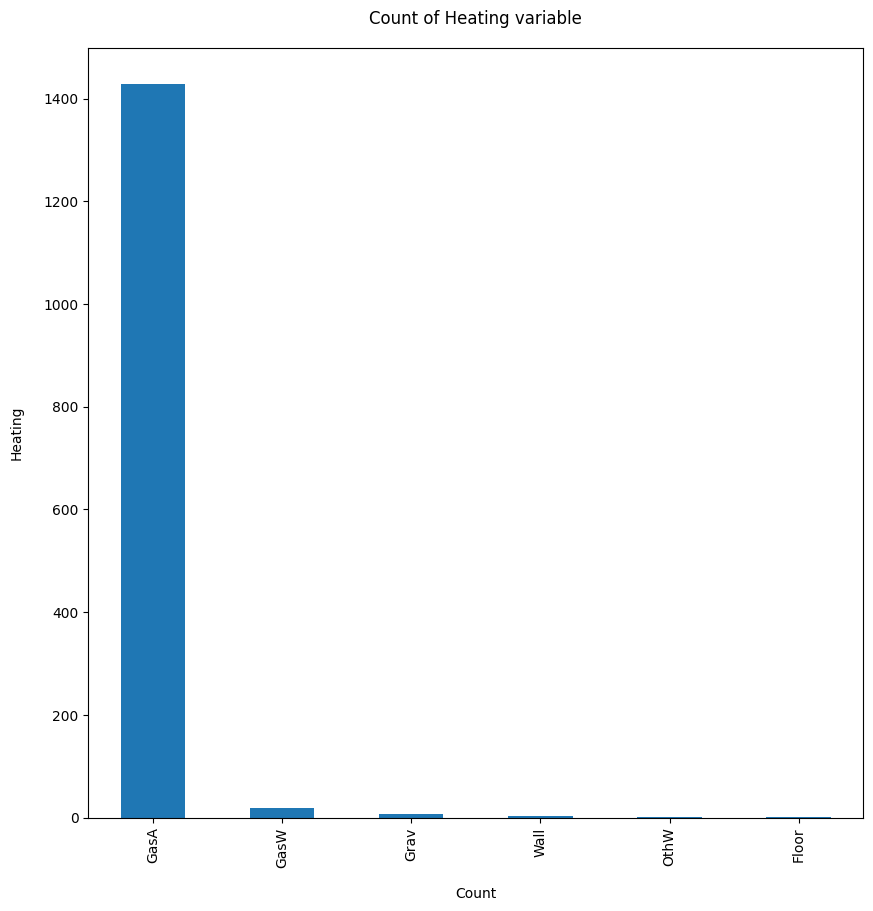

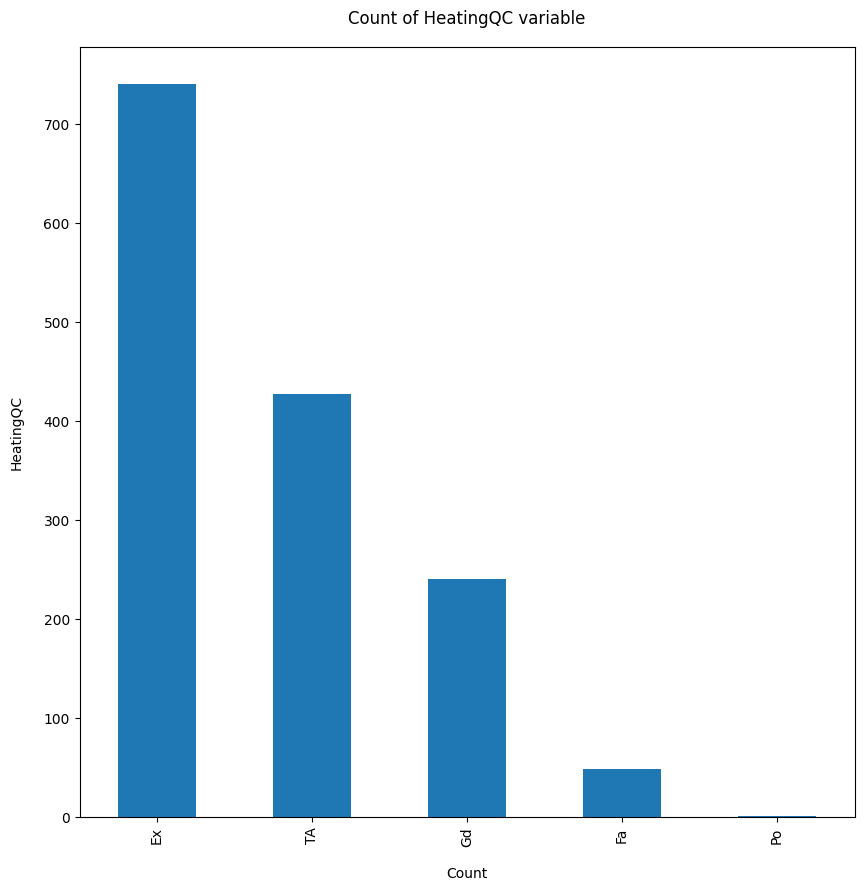

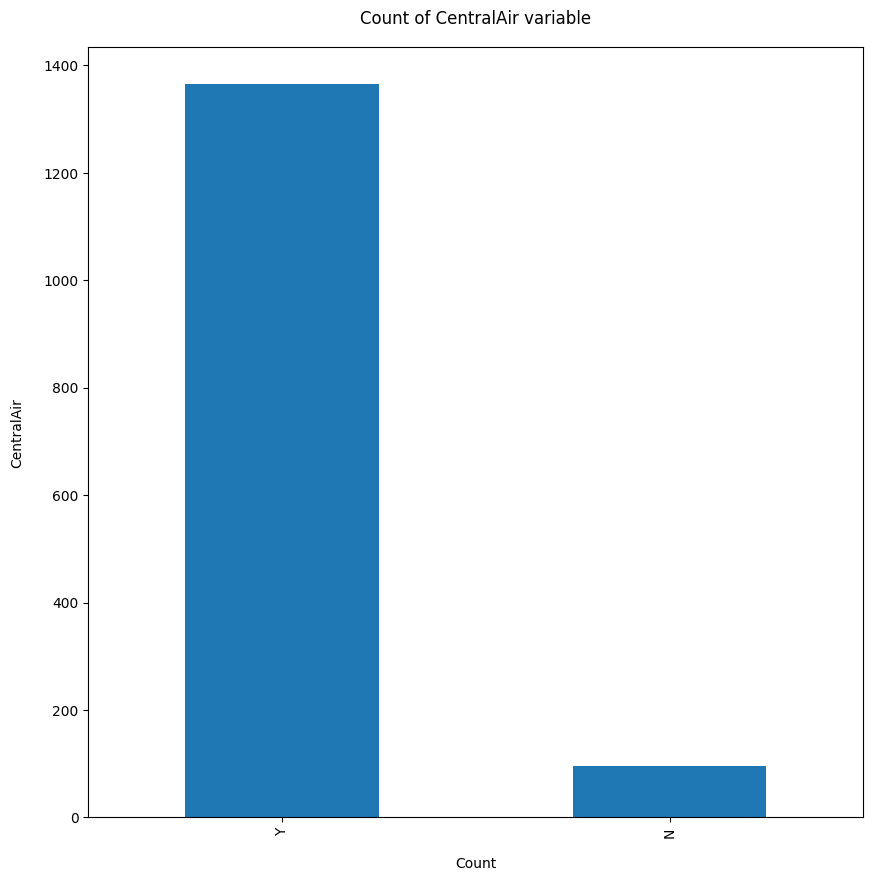

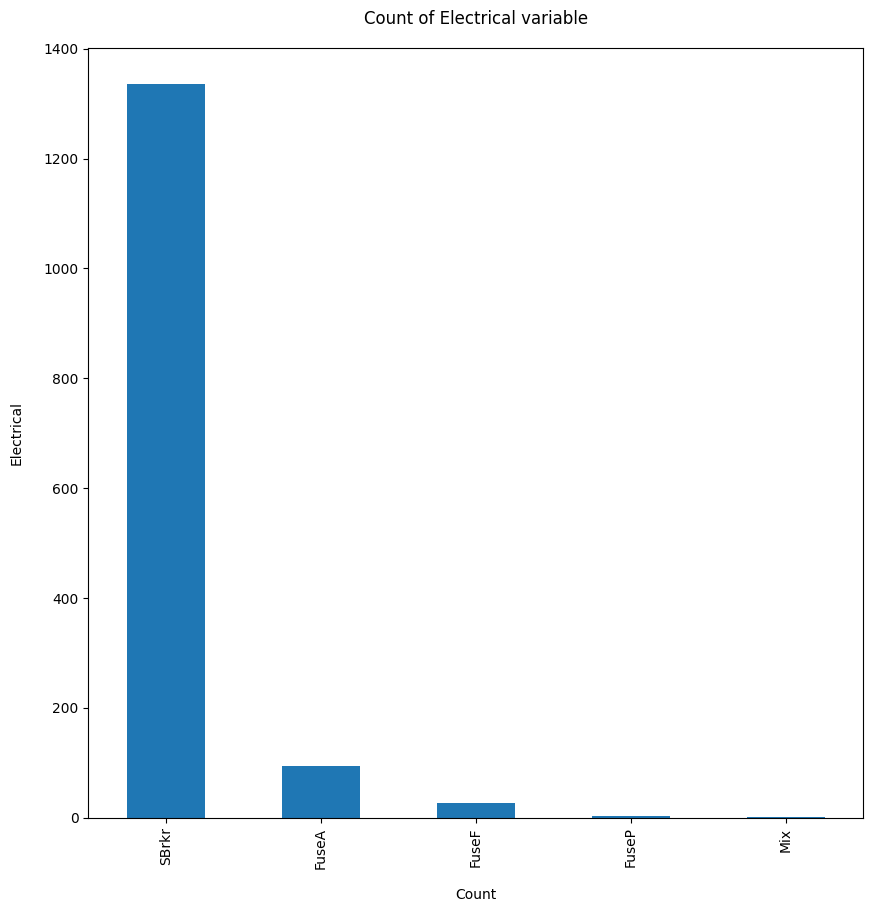

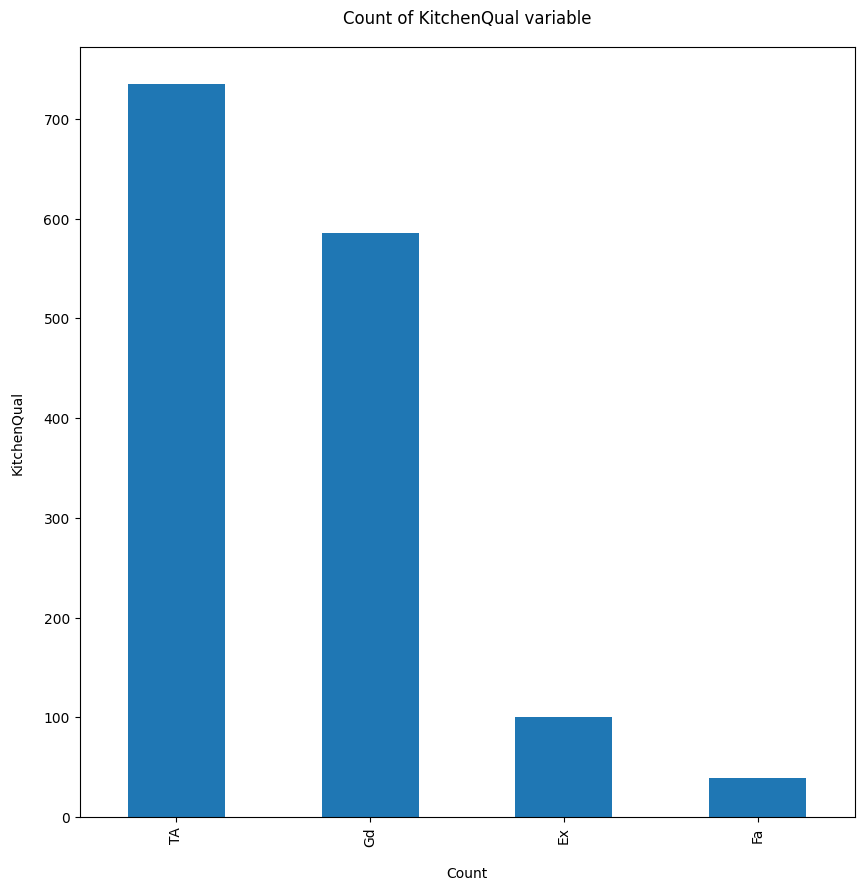

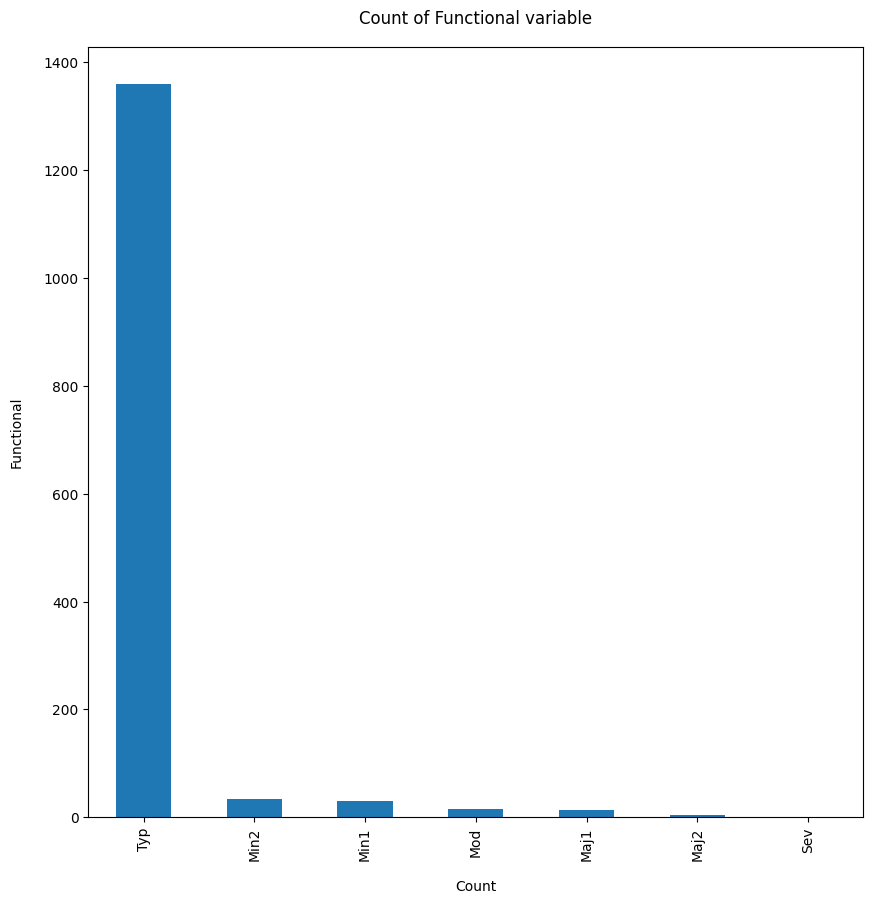

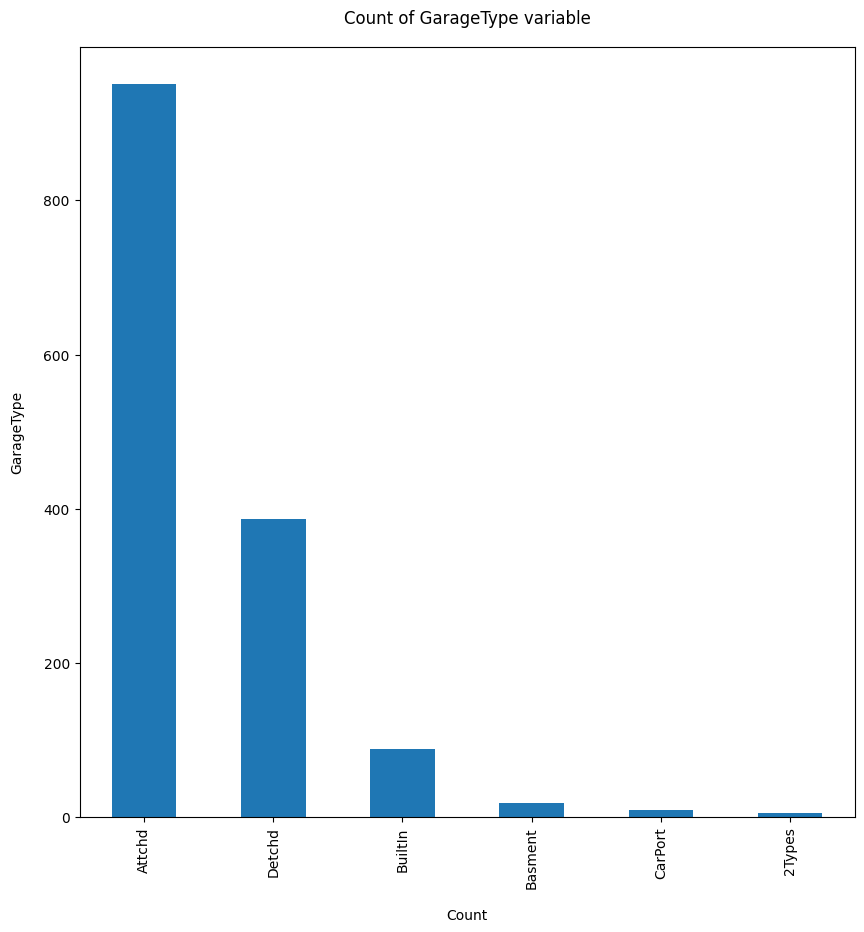

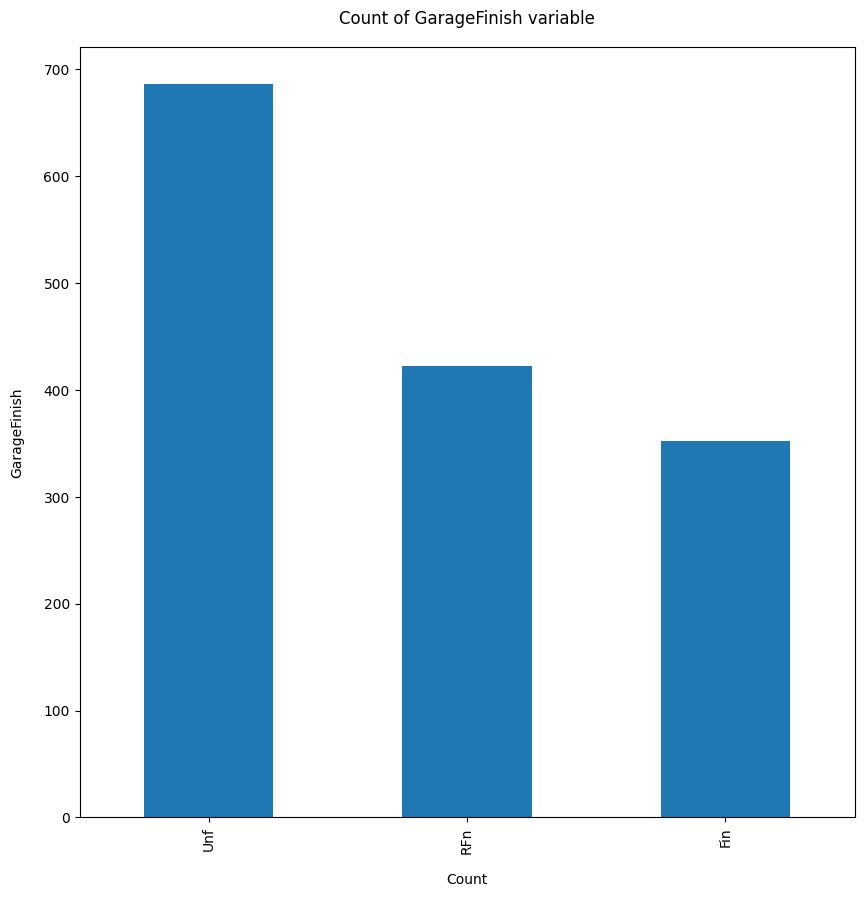

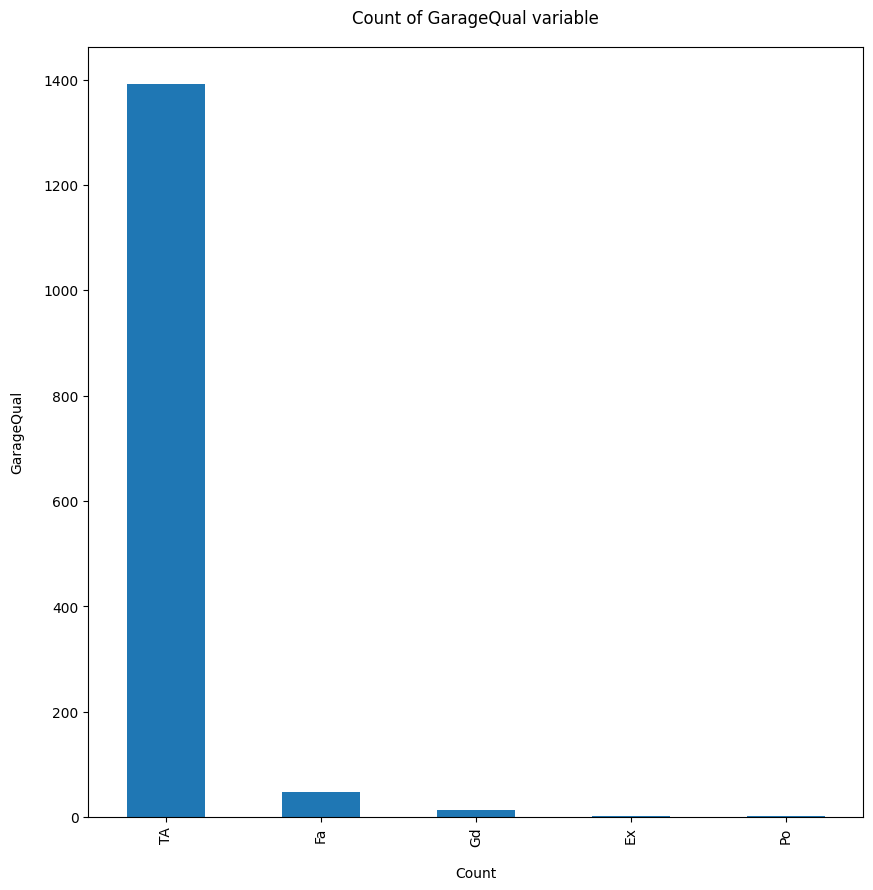

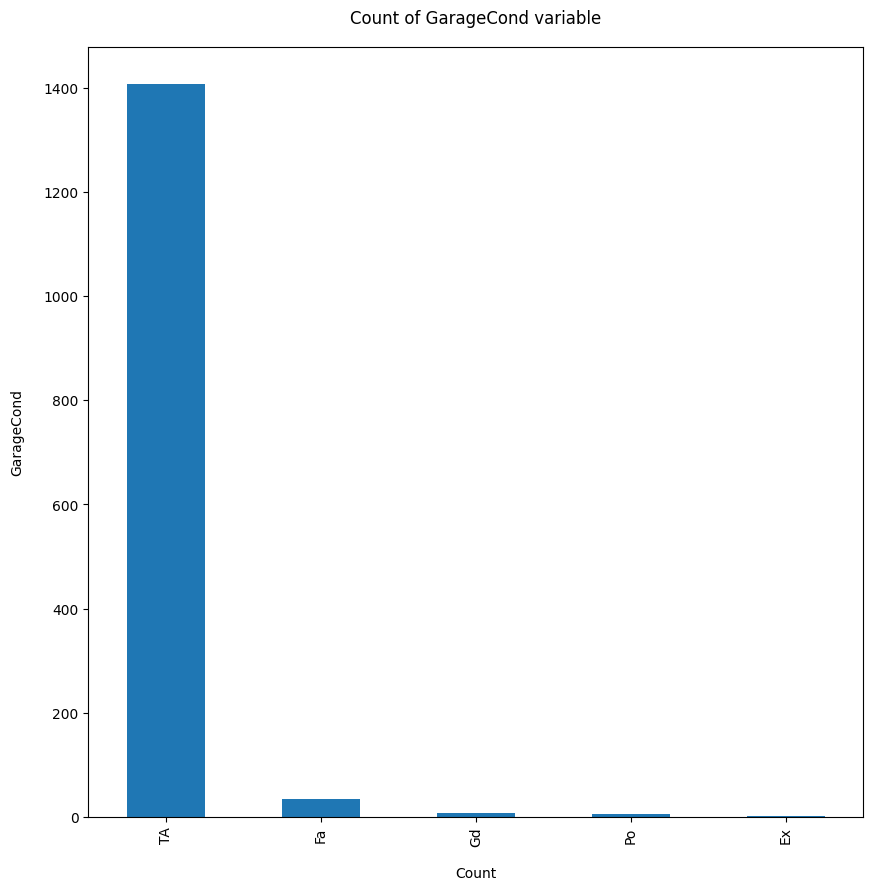

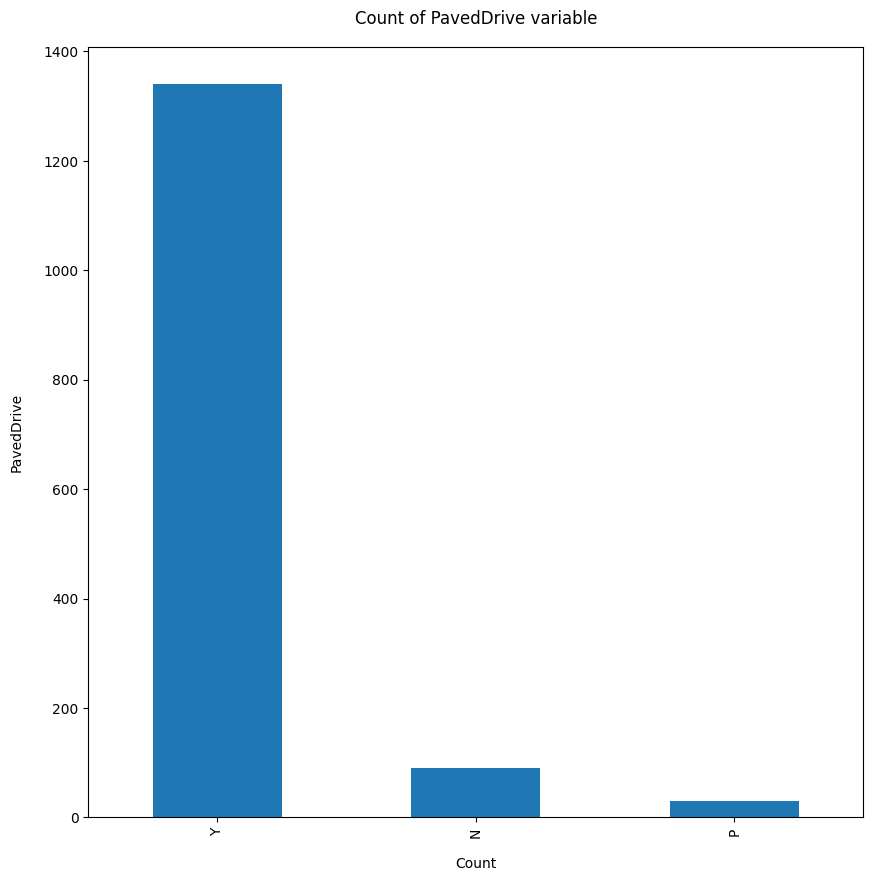

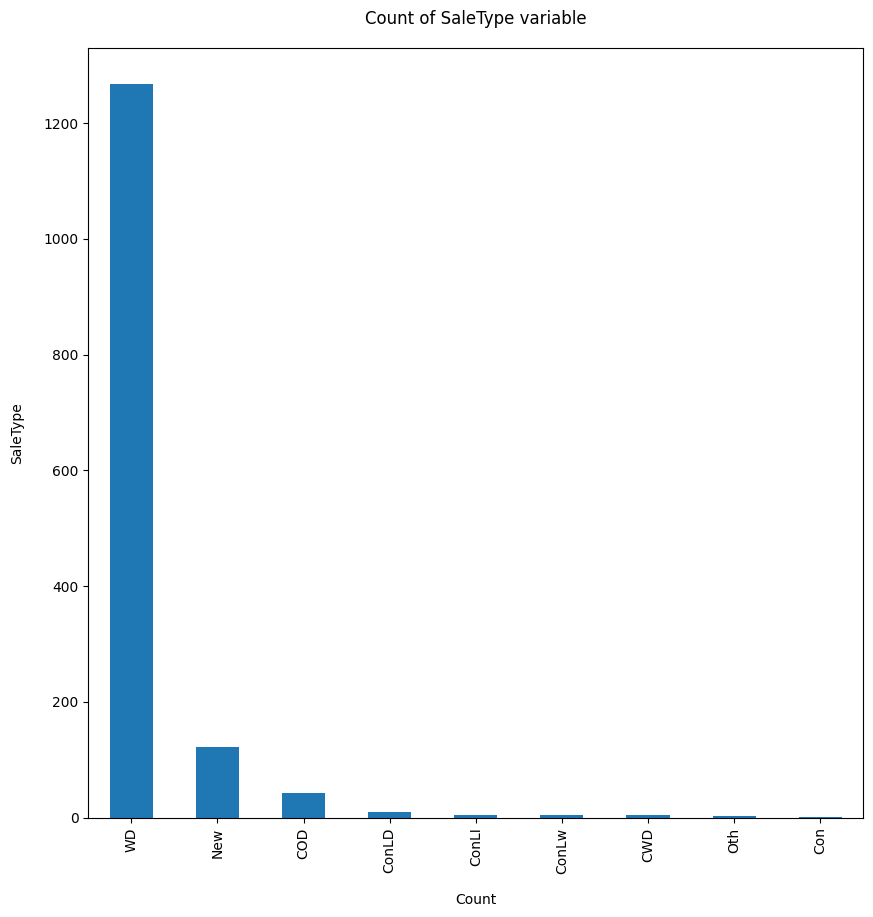

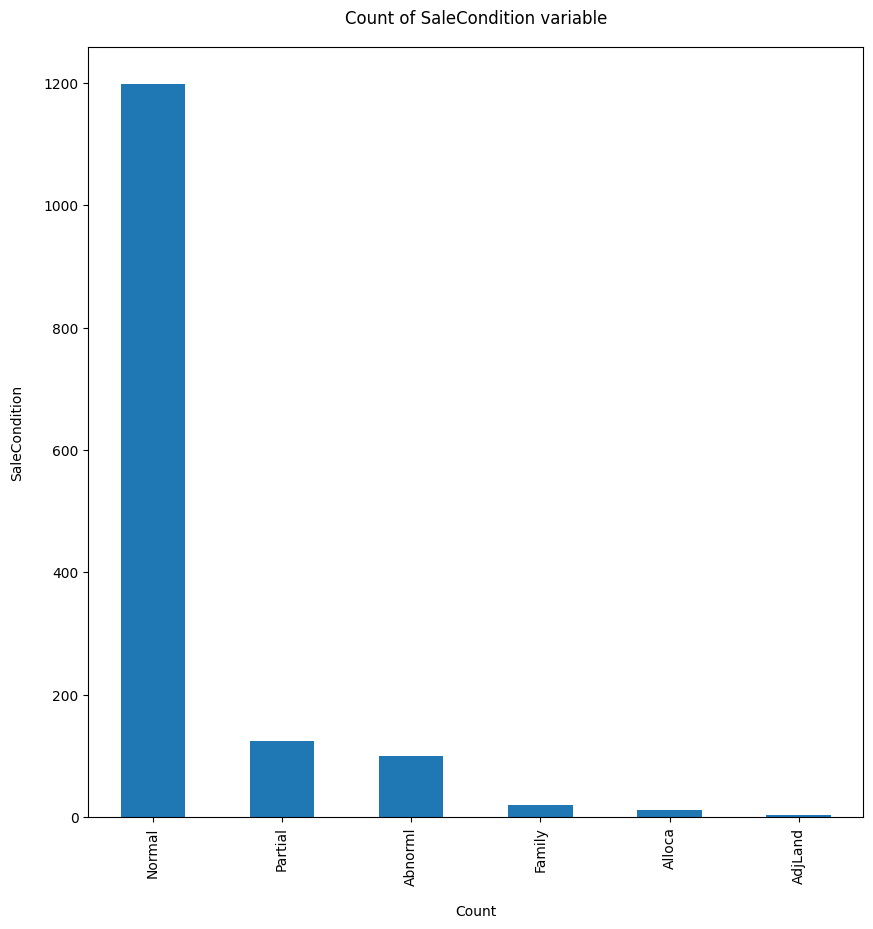

In [21]:
for col in object_variable:
    df_train[col].value_counts().plot(kind='bar', figsize=(10, 10))
    plt.xlabel('Count', labelpad=14)
    plt.ylabel(col, labelpad=14)
    plt.title(f'Count of {col} variable', y=1.02)
    plt.show()


### Bivariate Analysis

#### BoxPlot

**Insight Generated From the Categorical Variables**

**Utilities**
* Based on the boxplot, it can be seen that utilities have influences on the property sales prices. It can be seen that NoSeWa (Electrical & Gas) have a lower sales prices when compared to AllPub (All public Utilities - E,G,W,& S).


**Neighbourhood**
* It can be seen that certain neighbour reflects the properties sales price respectively based on the neighbourhood. 

**Roof material**
* Based on the roof material, it can be seen that WdShngl (Wood Shingles) reflect with high property value. 
* Certain material used for the roof material does not have a wide range for property value such as:
    * Metal - approx 200K
    * Membrane - approx 250K
    * Roll - approx 150K
    * Clay Tiles - approx 160K 

**Quality of the material on the exterior** 
* Property with excellent quality on the property exterior reflect a higher valuation for property. 

**Evaluates the height of the basement**
* Basement height over 100 inch had a wider range for property value. The lower the basement height, it reflect respectivetely with lower proprty price. 

**Heating Quality & Condition**
* Property with excellent heating quality & condition reflect a higher valuation for property.


**Central Air Condition**
* Property with air condition does have higher sales prices.

**Electrical system**
* In term of electrical system, only SBrkr (Standard Circuit Breakers & Romex) does correlate with higher property price while the remaining electrical system does does reflect significant change in property price.

**Kitchen Quality**
* Kitchen quality does have strong influences over property price.Kitchen quality with excellent condition tend to have higher price. As the condition drop by level, the sales prices significantly drop accordingly.

**Garage**
* Builtin & Attached garage reflect with sales property value.

**Sales Type**
* New property have a wide range of property price, it could reflect that sales price range from lower tier to luxury consumer.
* Contract 15% Down payment regular terms also tend to have a higher sales property price compared to the other factor however the range is quite small. 



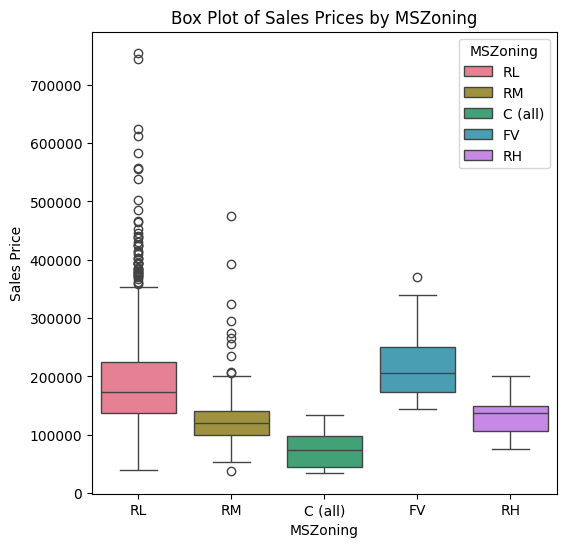

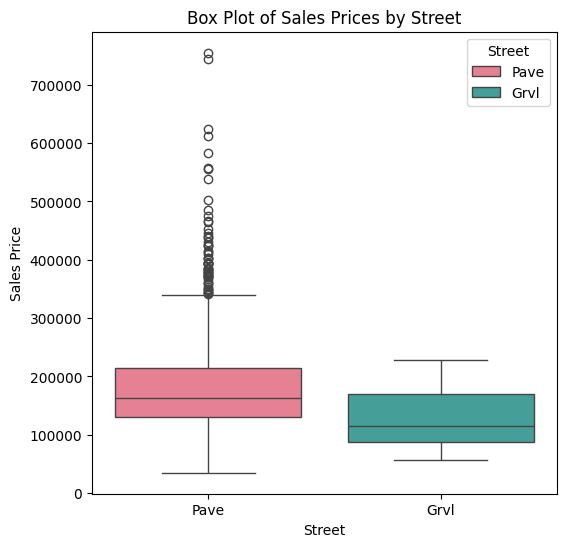

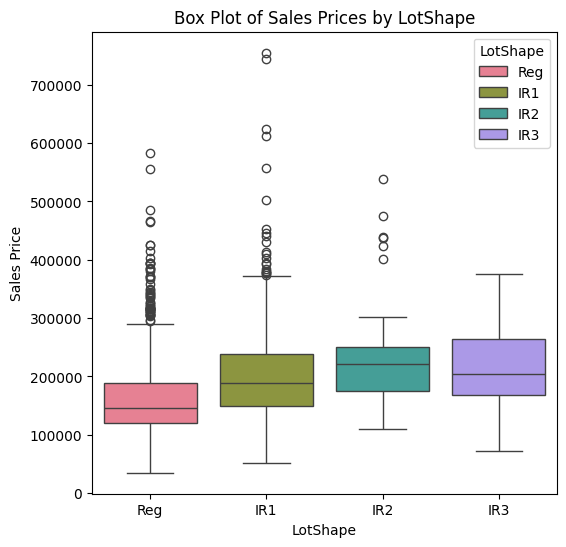

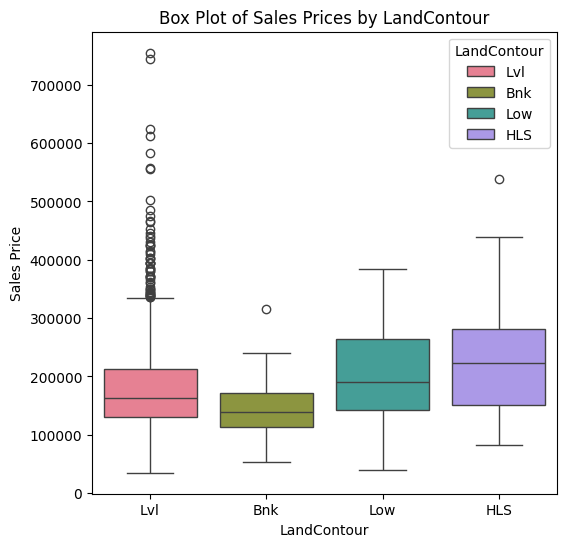

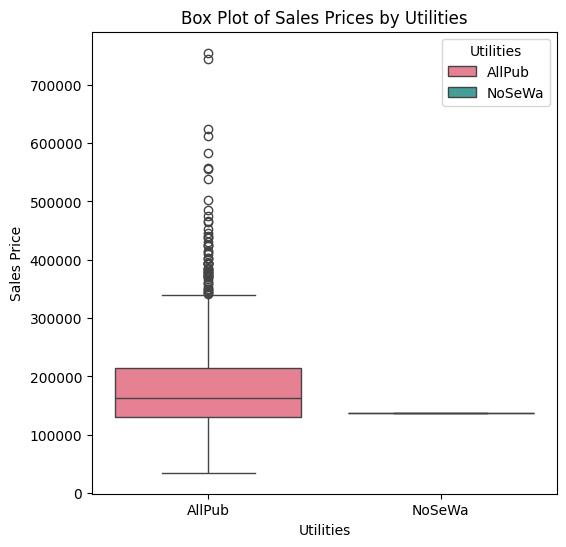

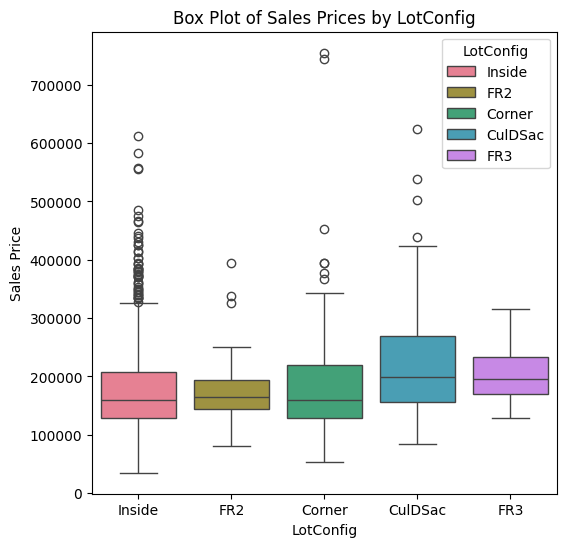

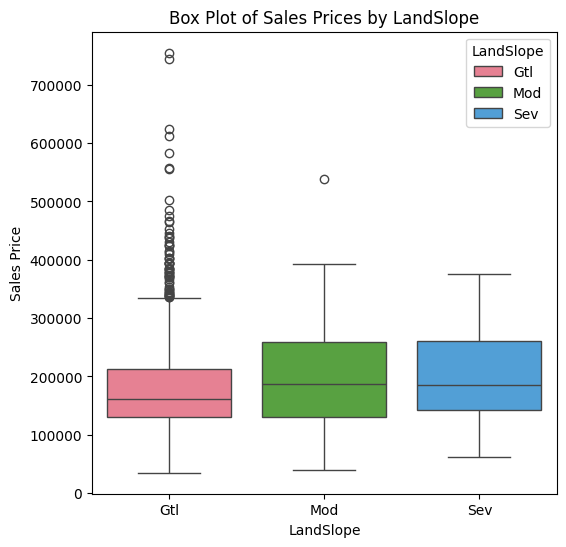

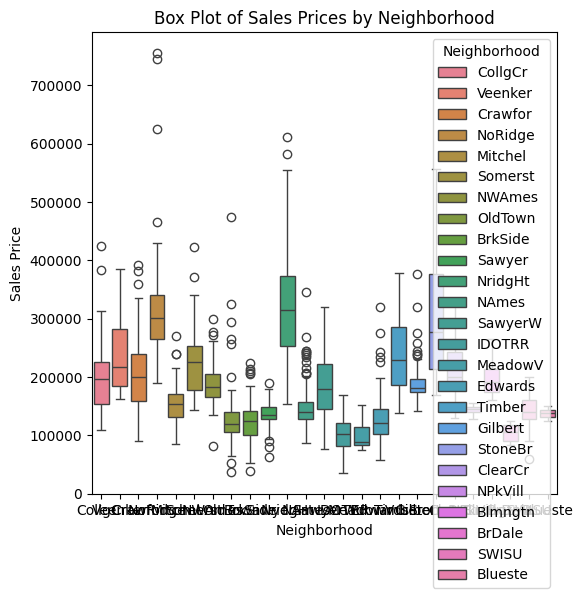

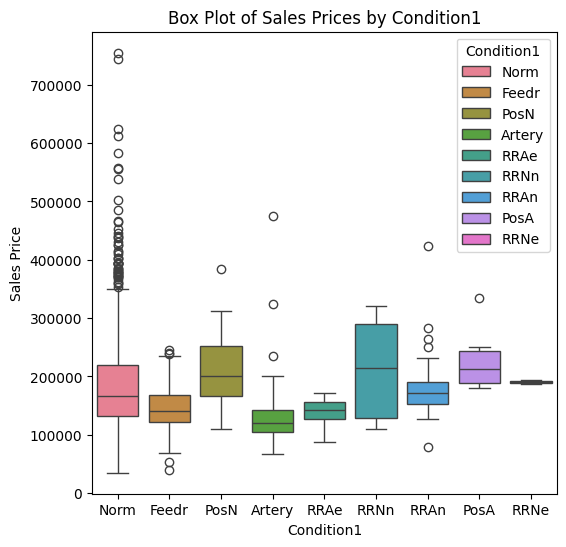

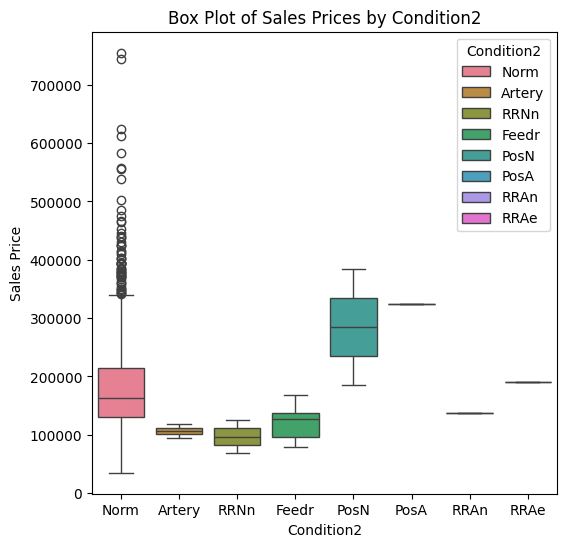

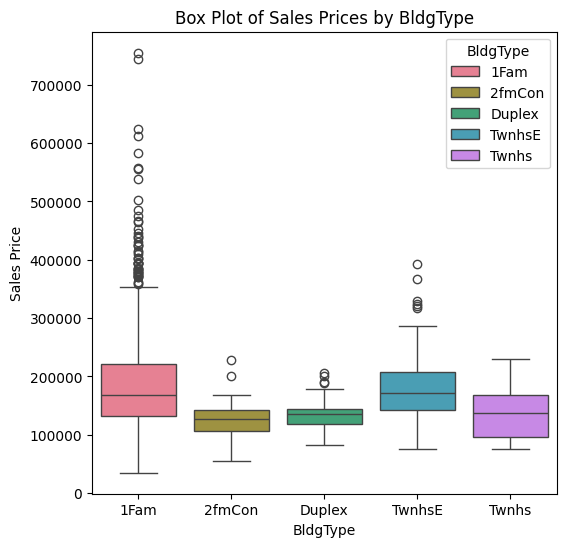

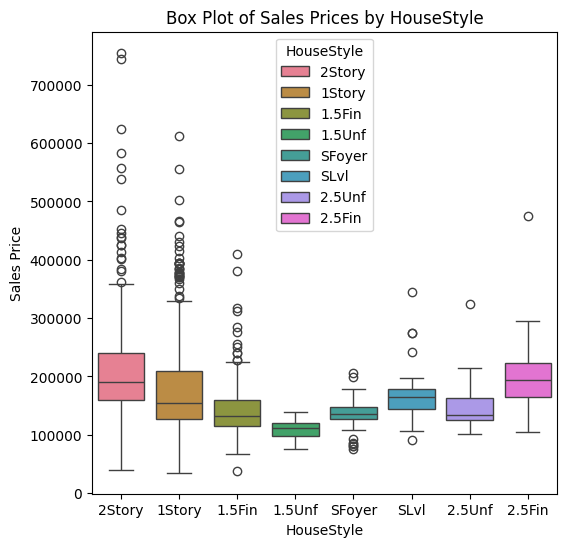

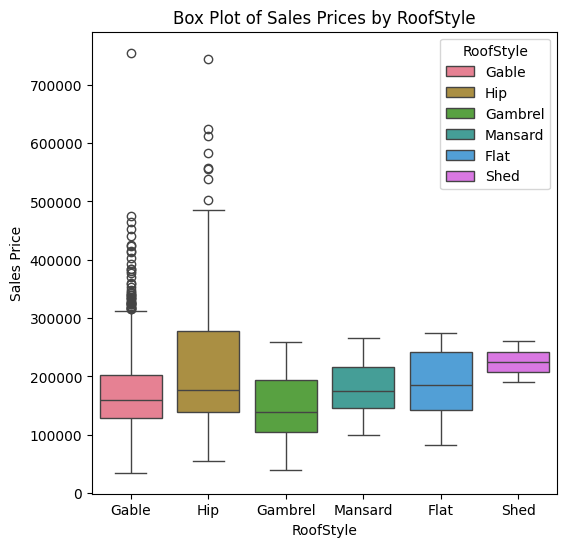

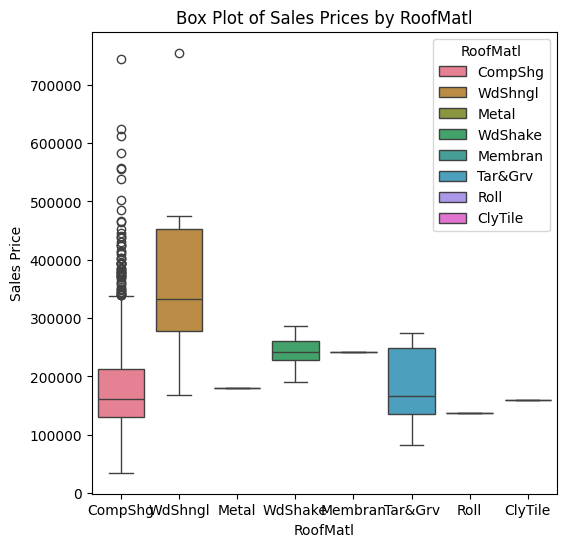

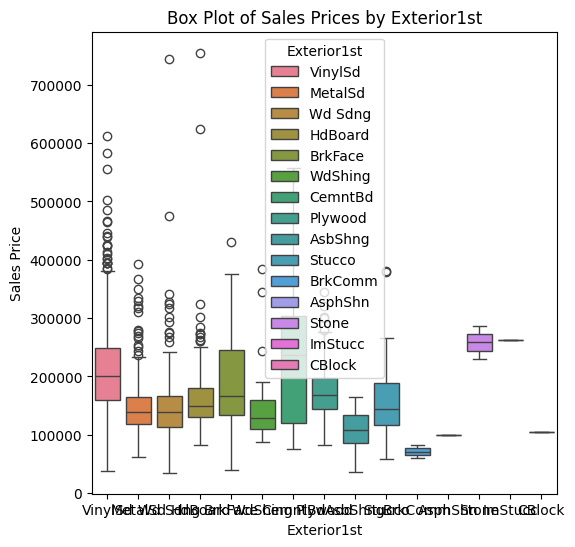

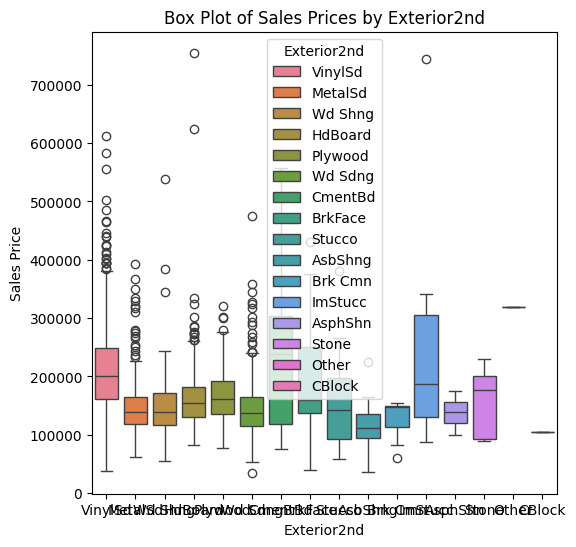

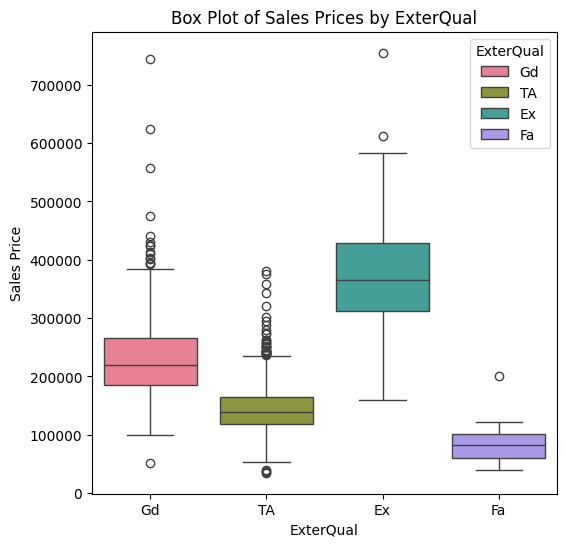

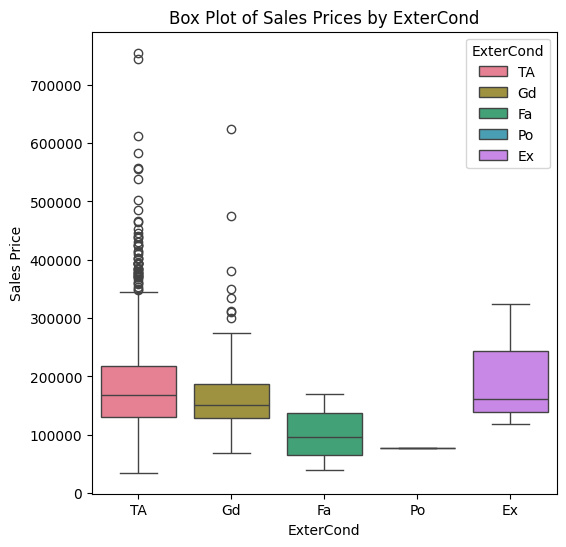

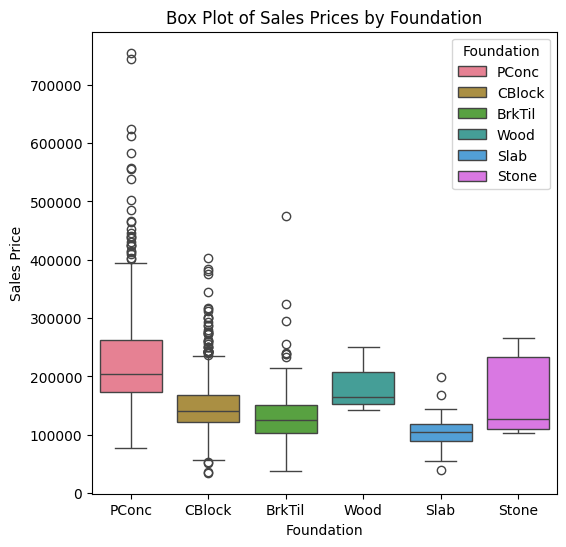

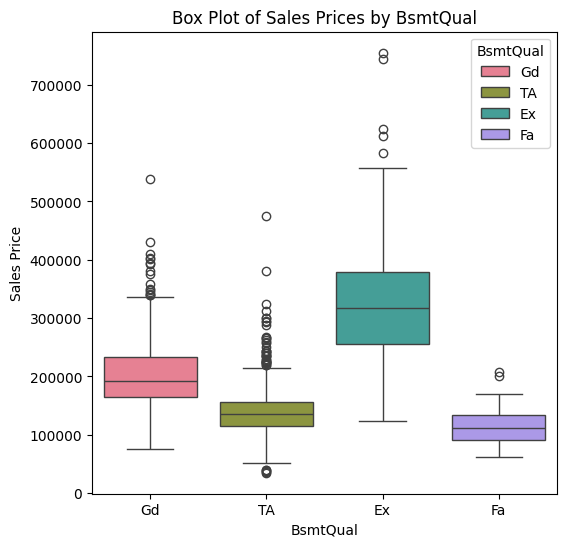

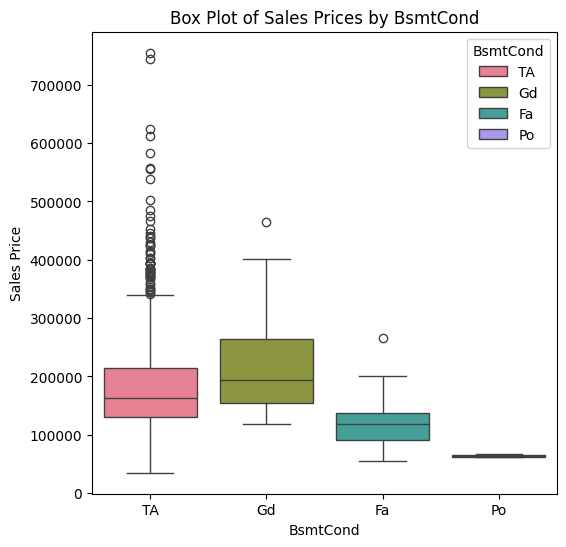

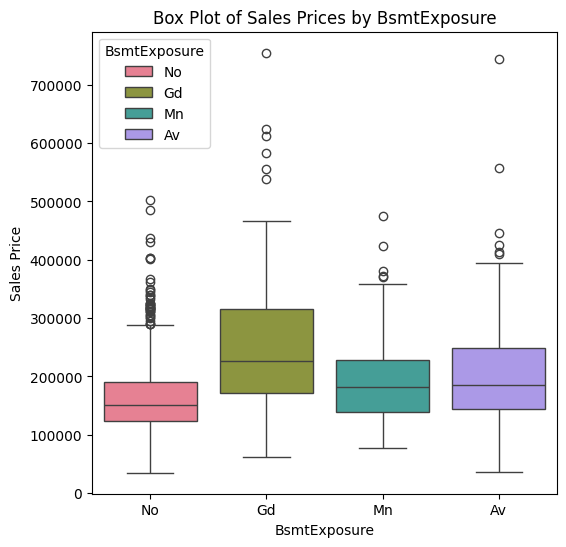

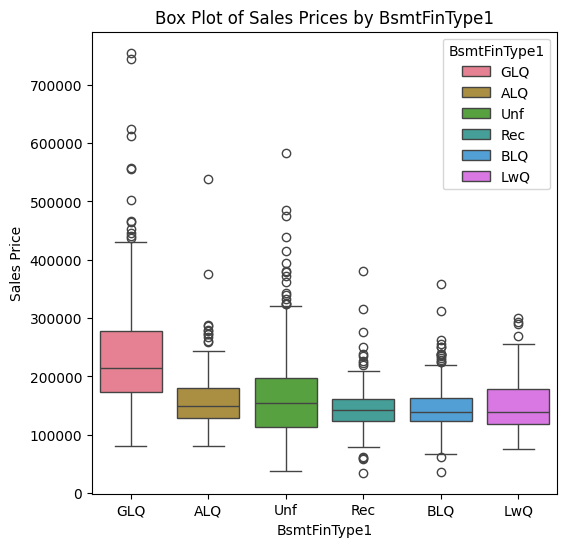

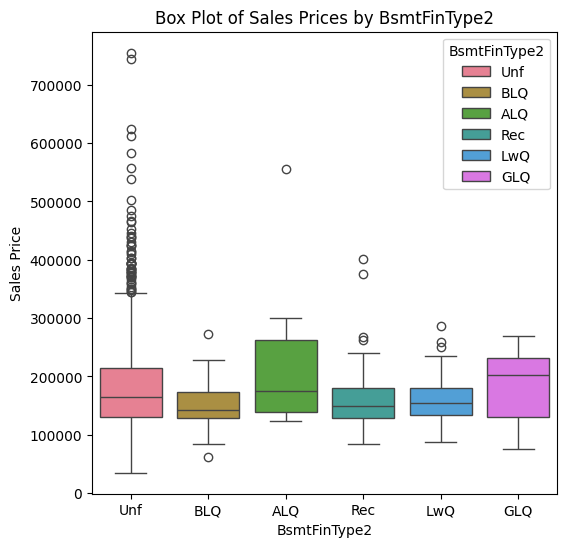

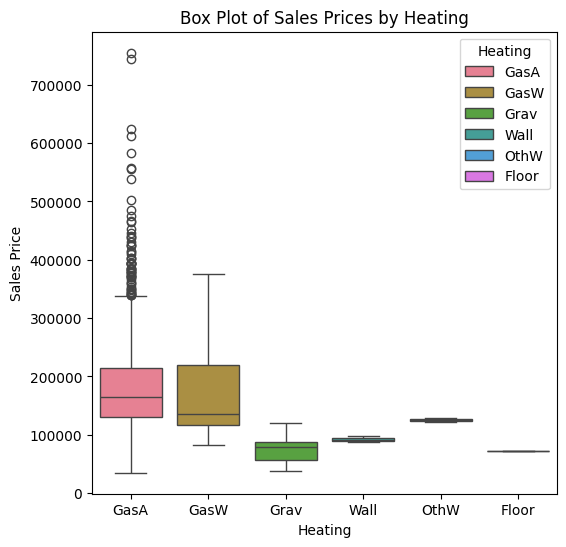

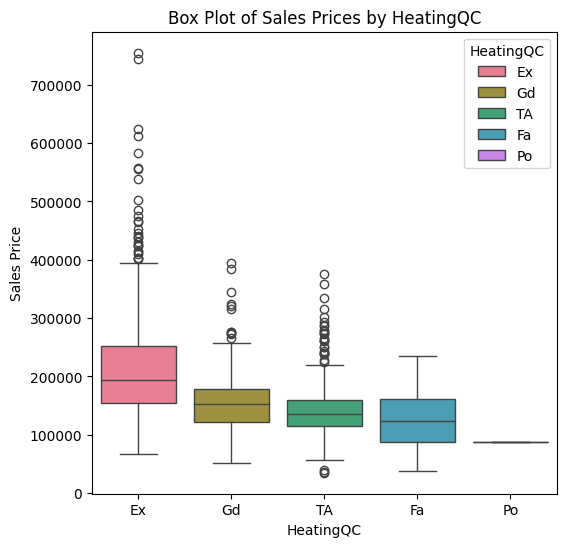

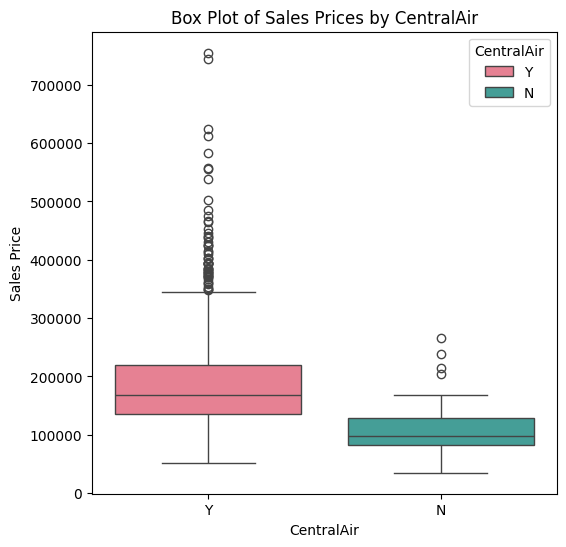

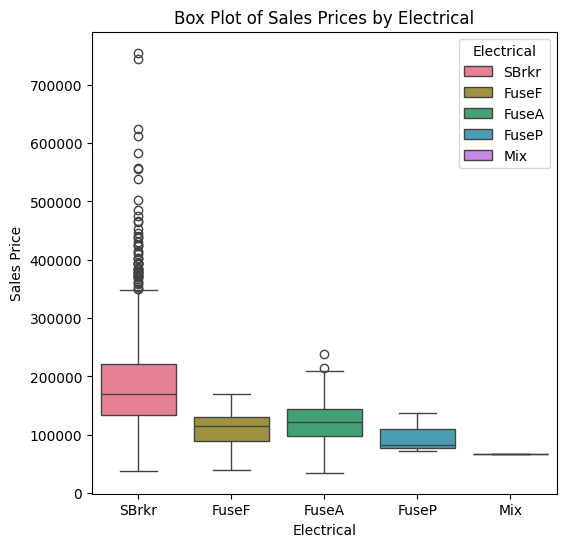

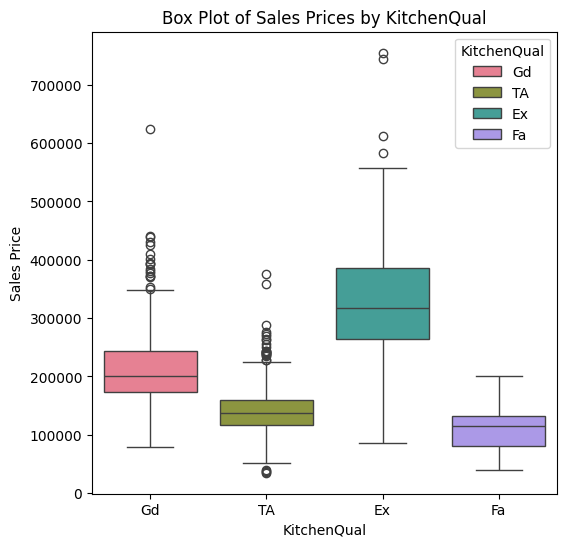

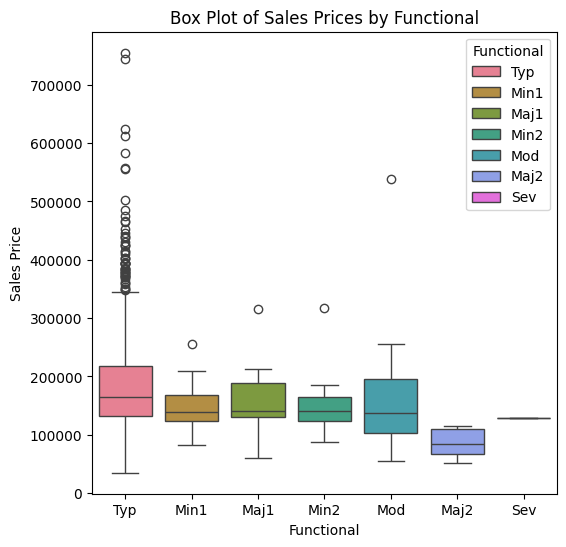

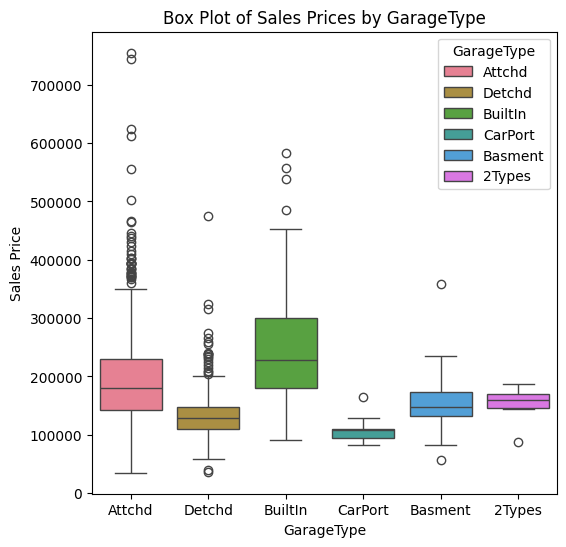

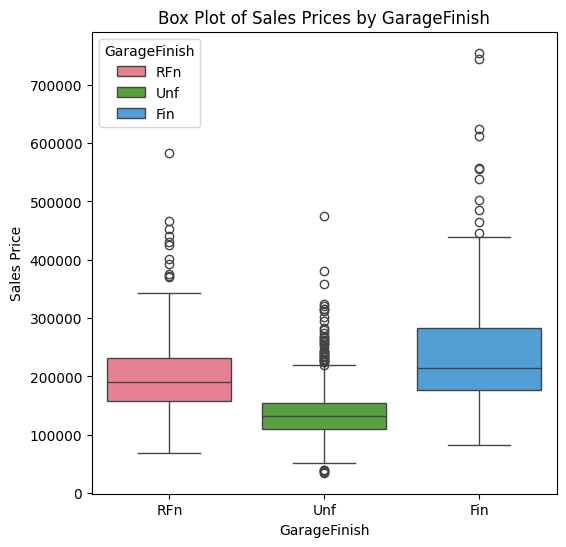

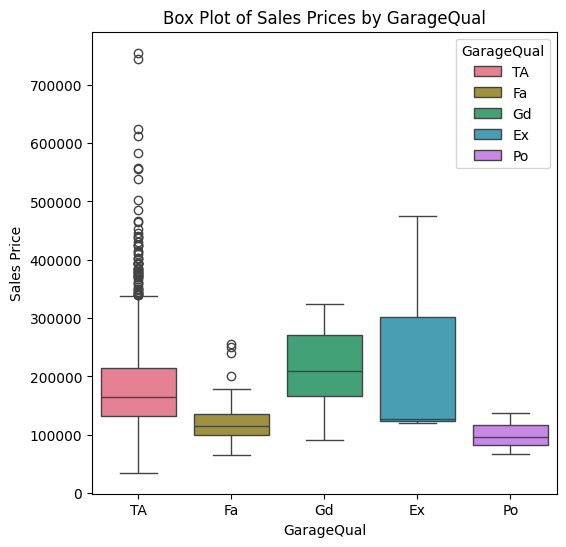

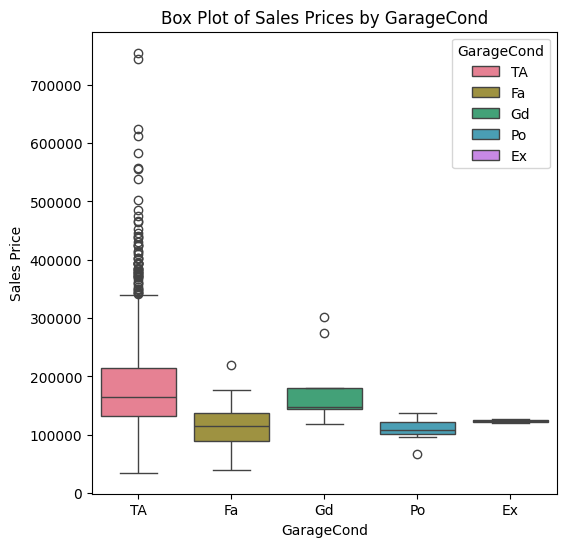

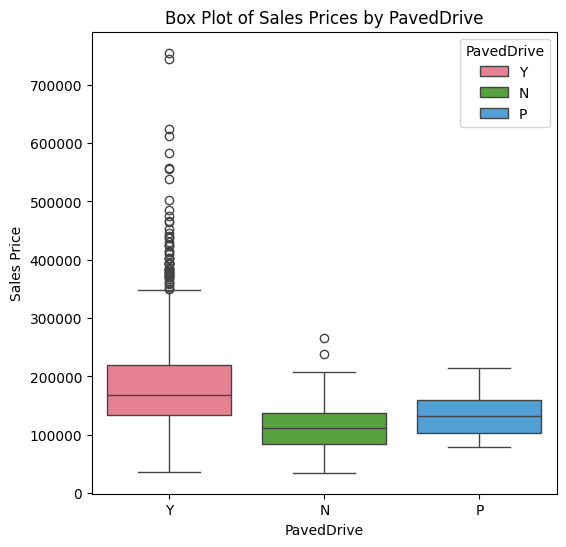

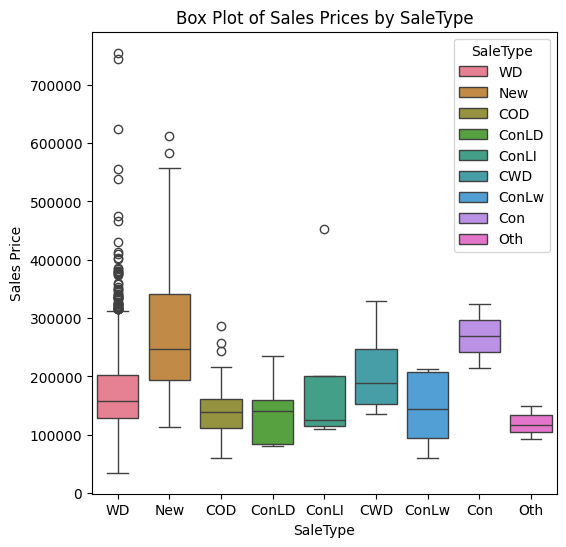

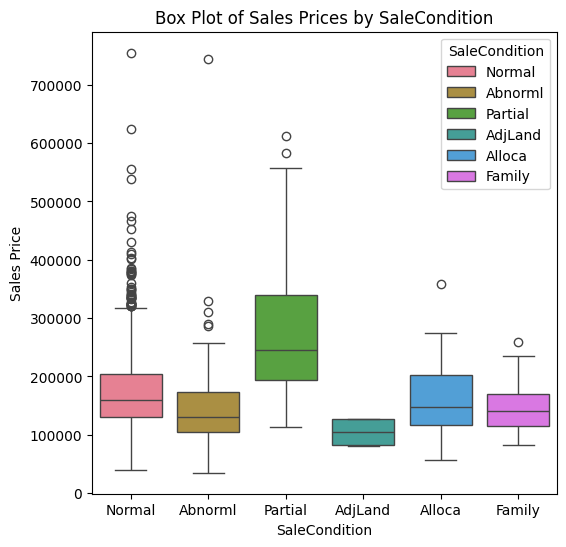

In [22]:
for col in object_variable:
    plt.figure(figsize=(6, 6))
    sns.boxplot(x=col, y='SalePrice', data=df_train, palette='husl', hue = col, legend= True)
    plt.xlabel(col)
    plt.ylabel('Sales Price')
    plt.title(f'Box Plot of Sales Prices by {col}')
    plt.show()

#### Scatter Plot

**Insight Generated From the Numeric Variables**

**Year Built vs Sales Price**

* Based on the scatter plot, it can be property built throughout the centuries value have a positive increase.
* The data points are segregrated by general zoning classification to identify the type of property.
* It can be seen that during the 1880 to 1940 majority of the property were classify as Residential Medium Density.
* After 1940 to 2000, Residential Low Density property was introduce and dominated the market.
* It was later seen that Floating Village Residential started to spike post 2000.
* This category of the property does reflect the value with the inclusion of the when the property was develop.
* It could be also seen as the demand for property reflect the wants of the customer in the property market.

**Property Size**

* **Total Basement Size**
* **1st Floor**
* **2nd Floor**
* **1st Floor**
* **Above Ground Living Area**
* **Garage Area**
    * Based on the factor, it can be seen that size of these factor does have a positive correlation with the sales prices.
    * In addition, the classification of zoning label the data points. It can be seen that there is a trend within 3 major group which are RL (Residential Low Density), RM (Residential Medium Density)and FV (Floating Village Residential).
    * RL have the smallest size, and the sales prices tend to be lower.
    * On the other hand, RM have a huge range in term of sales price. This could be due to the fluctuation of property size. 
    * FV on the other hand does not reflect a high property value, however, the price remain a certain range. Therefore, it could be infer that these property have a consistent size for housing therefore reflecting a consistent price range across the dataset. 

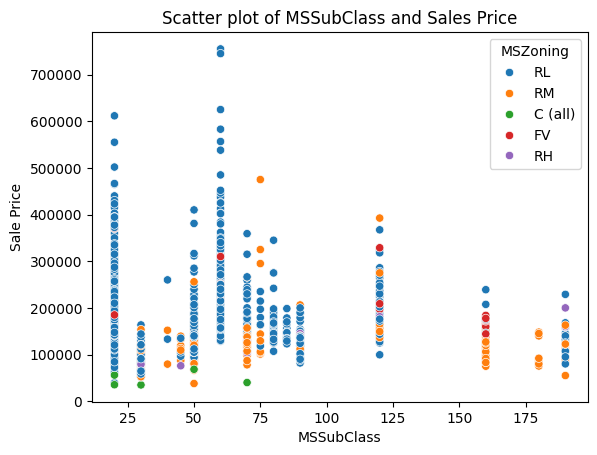

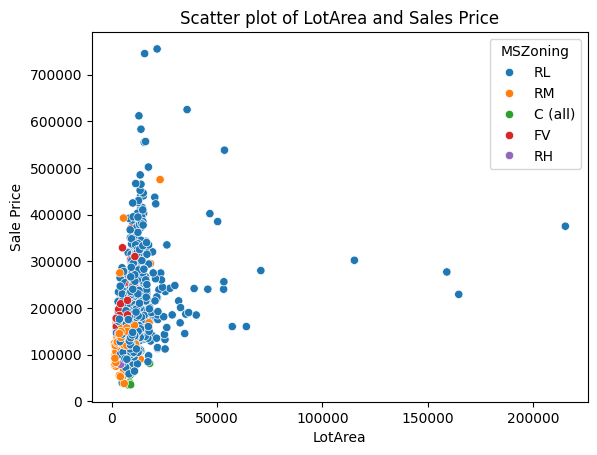

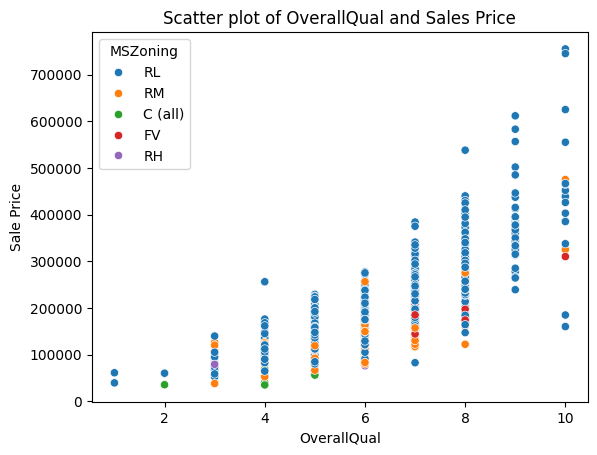

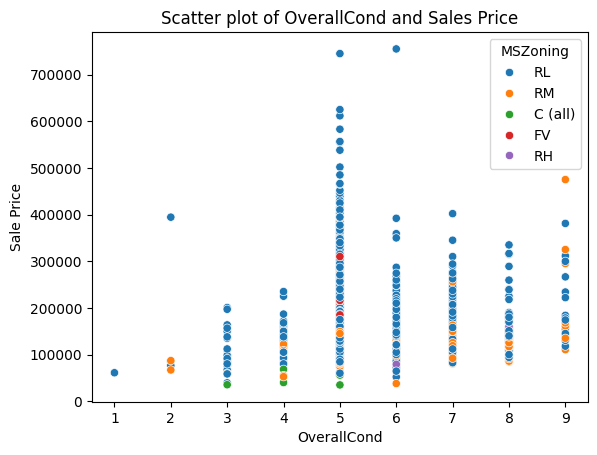

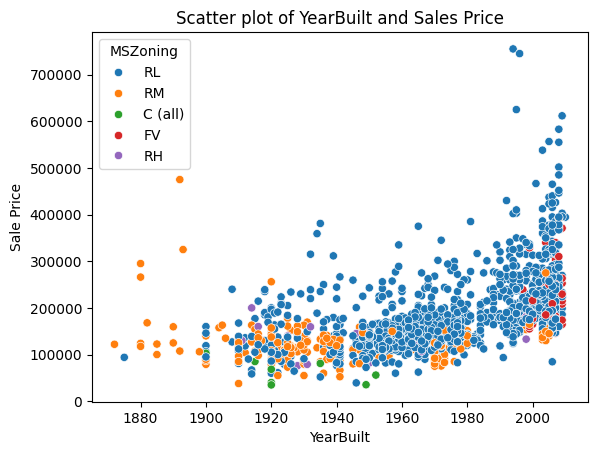

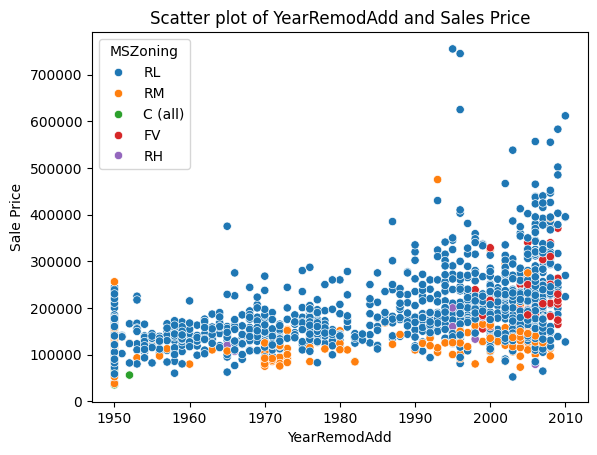

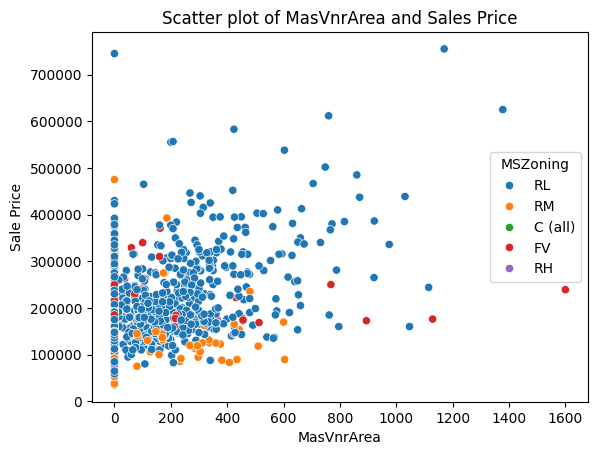

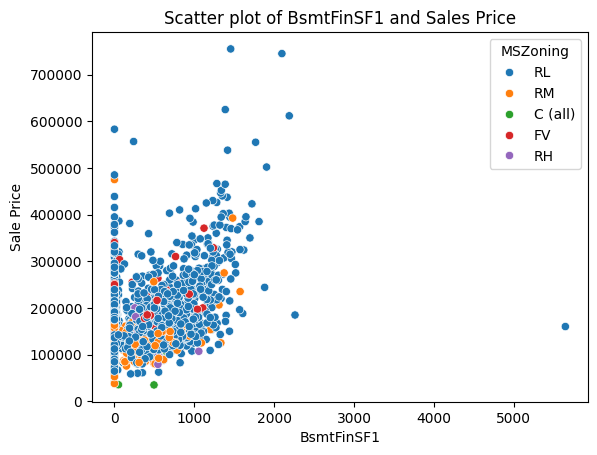

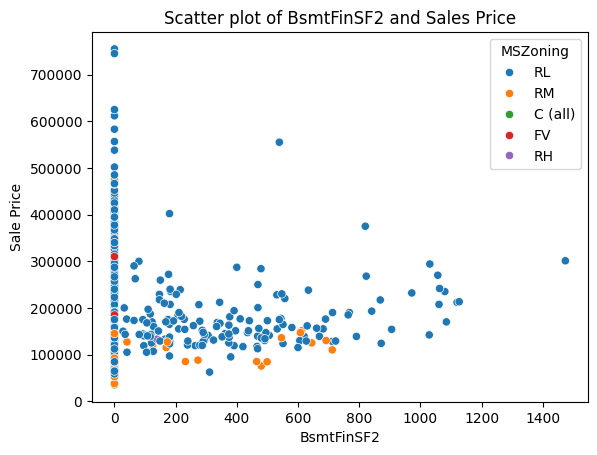

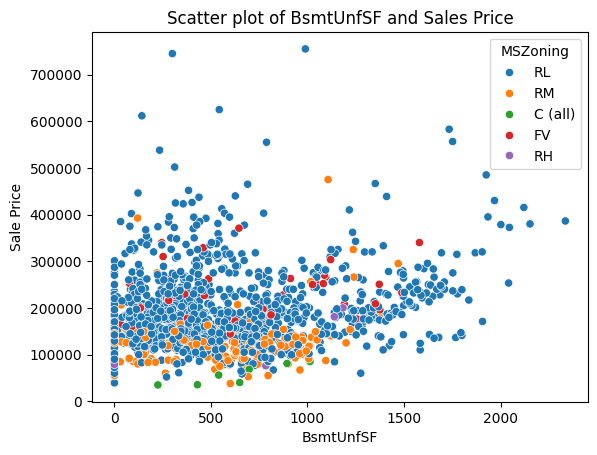

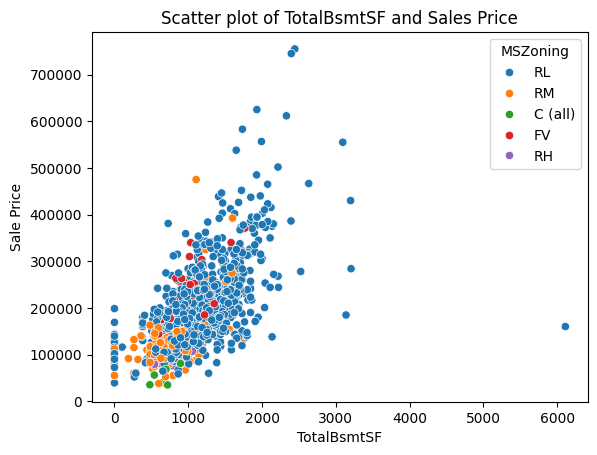

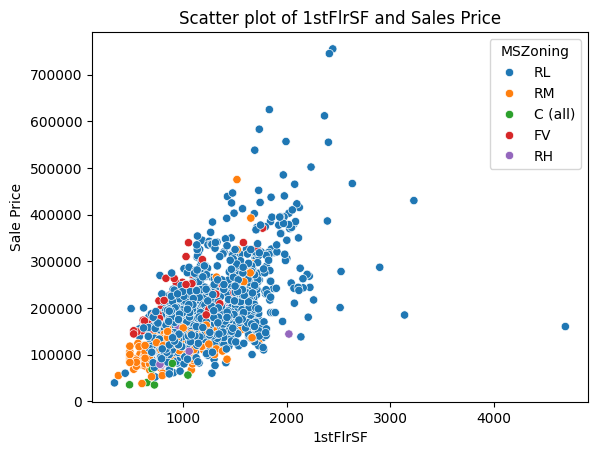

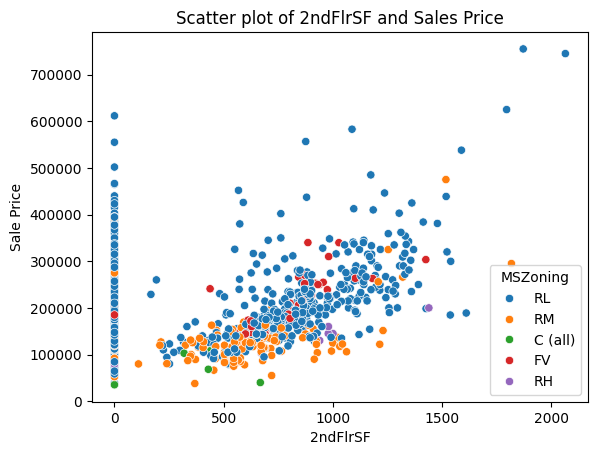

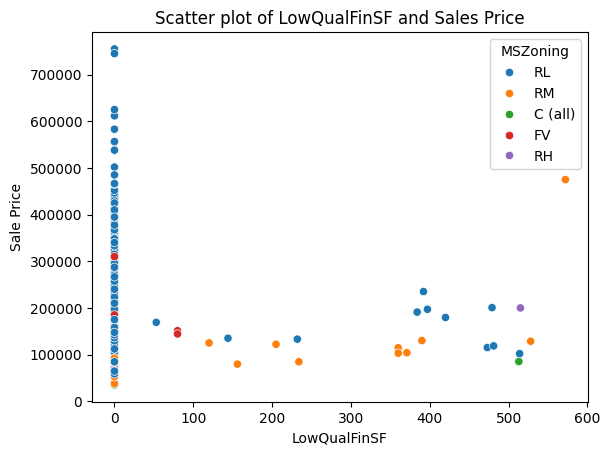

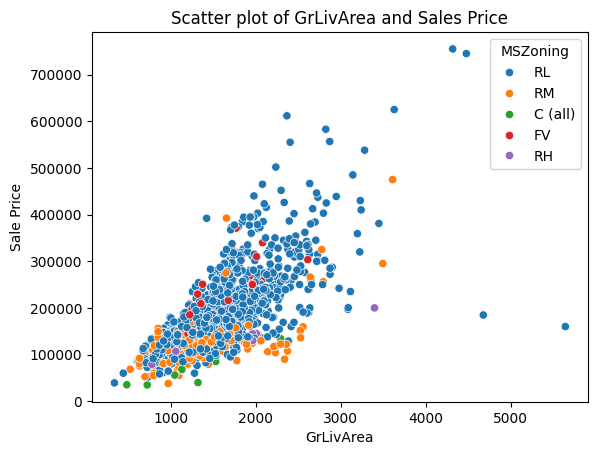

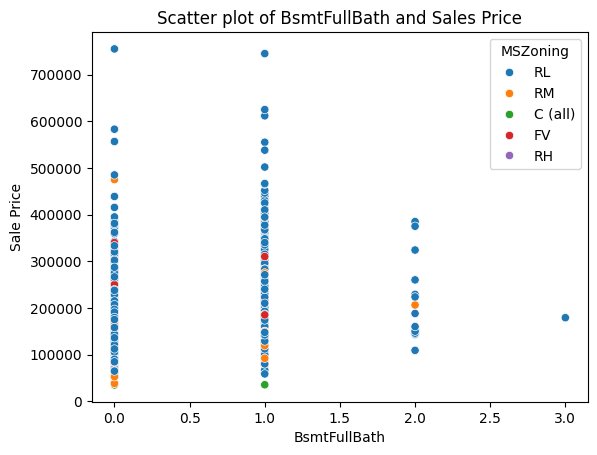

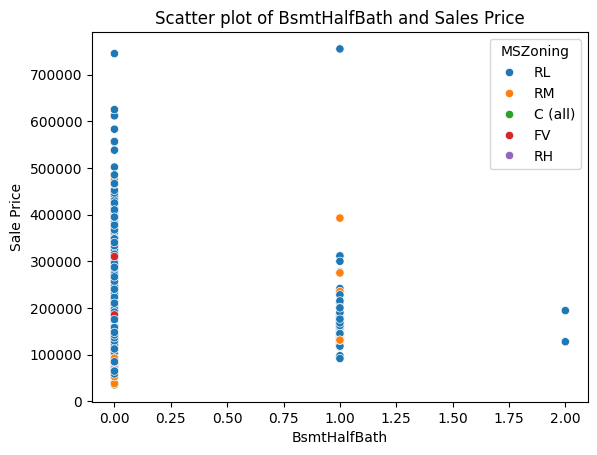

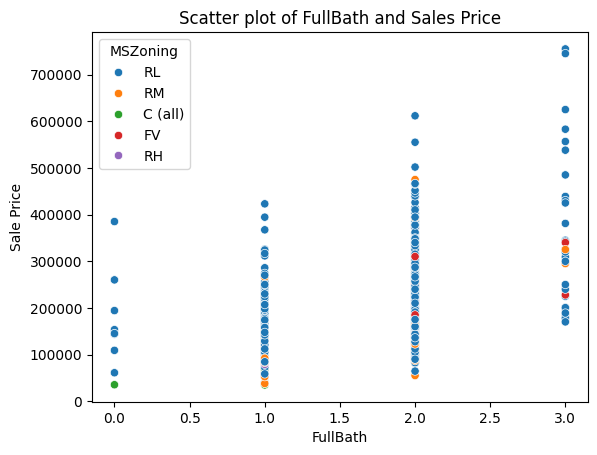

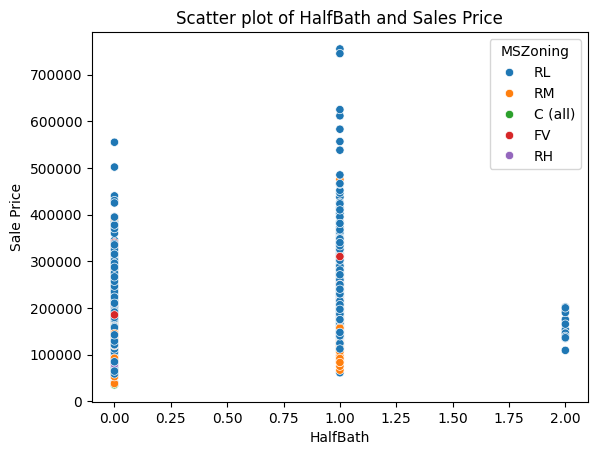

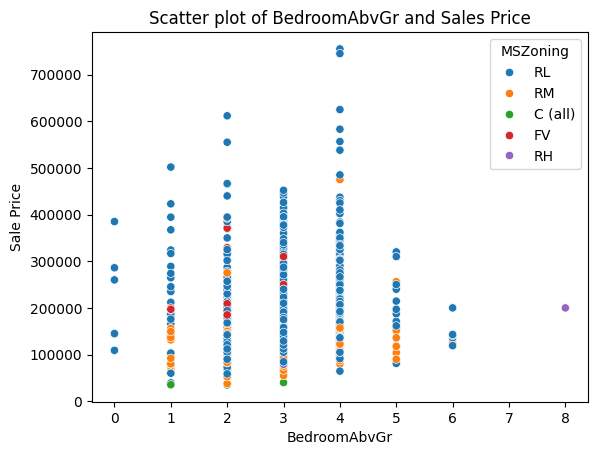

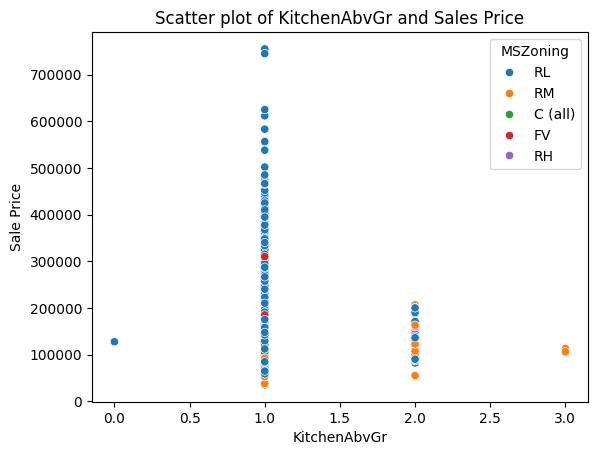

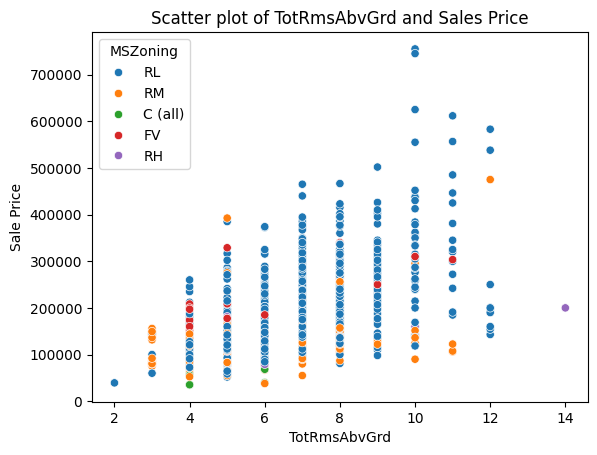

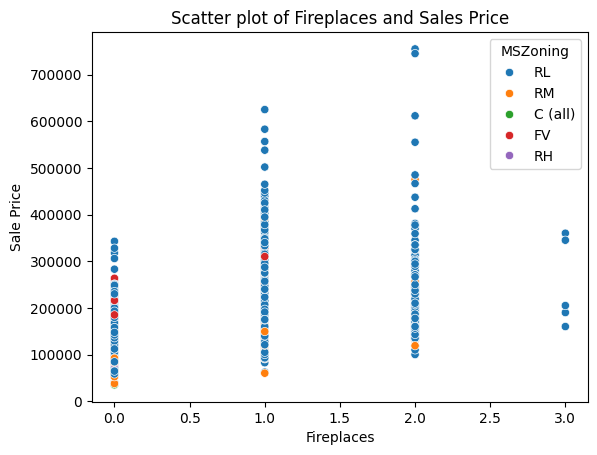

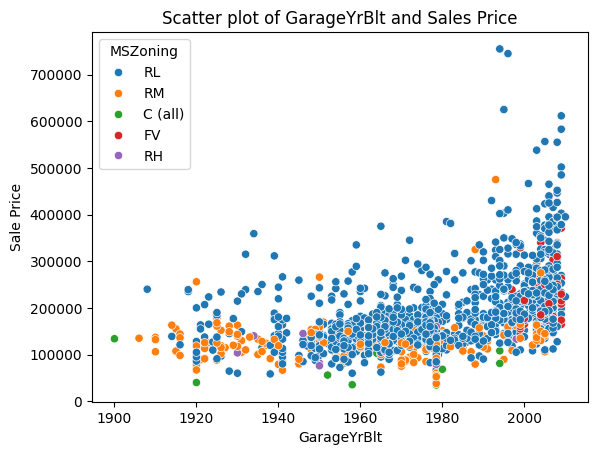

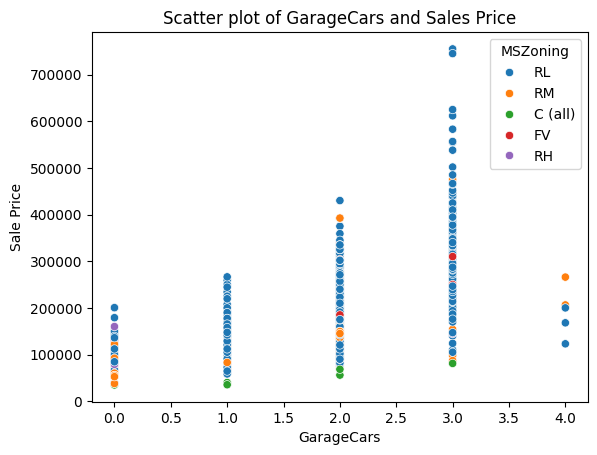

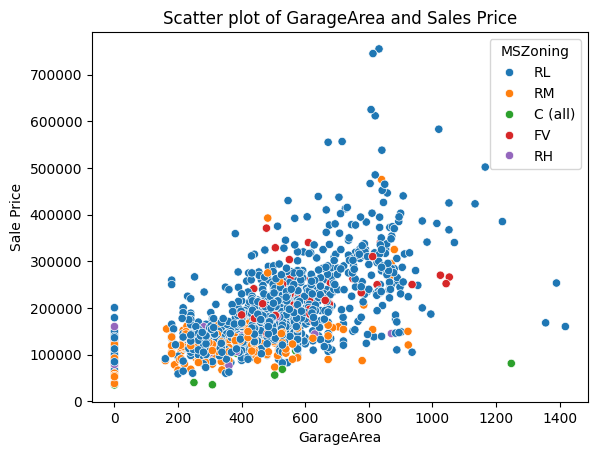

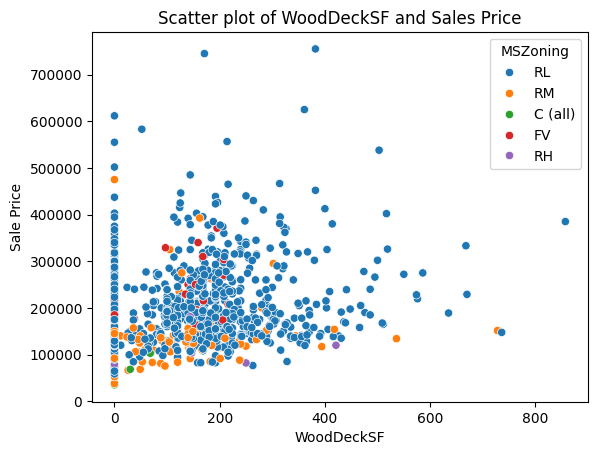

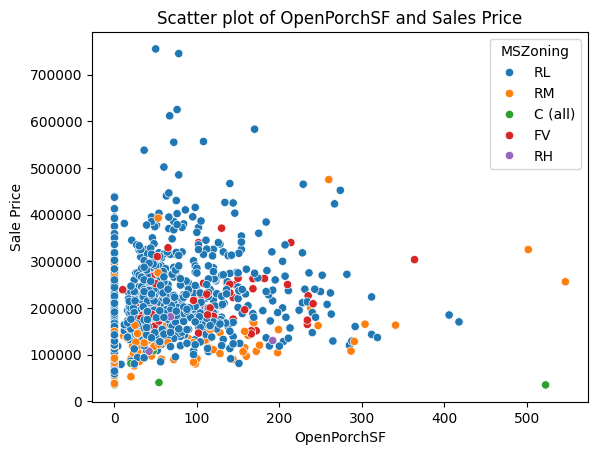

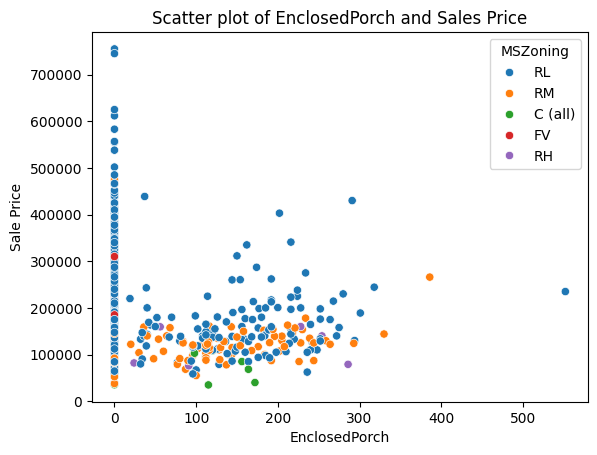

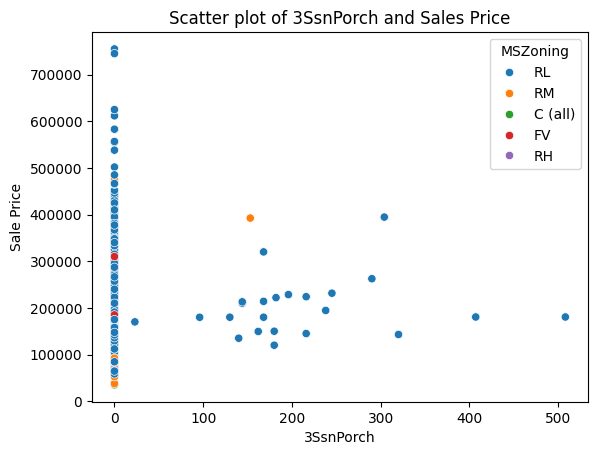

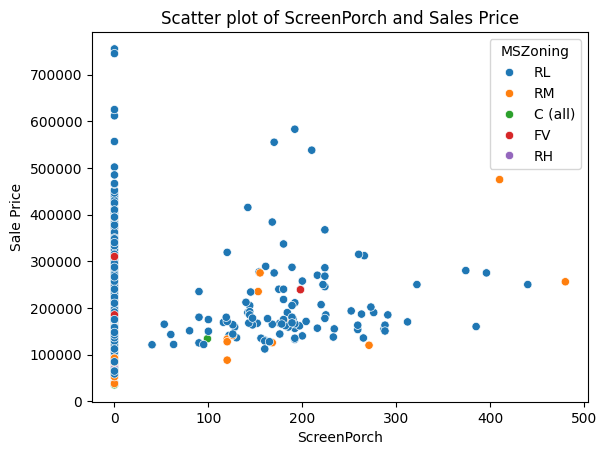

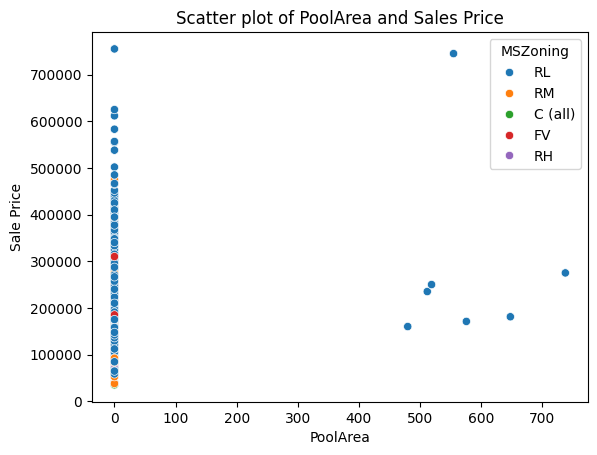

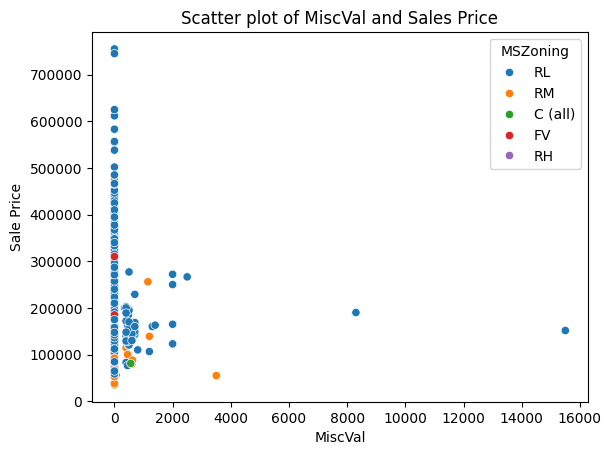

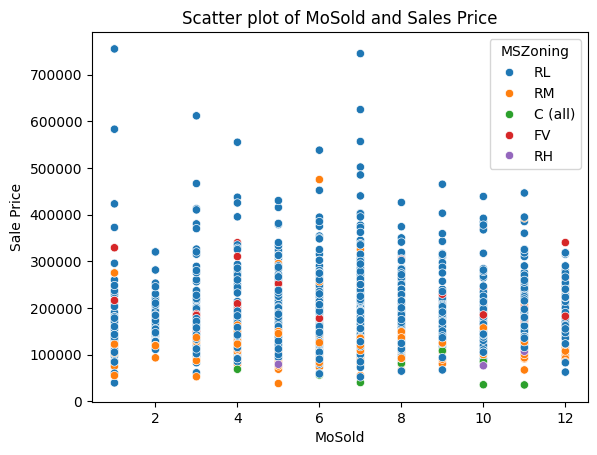

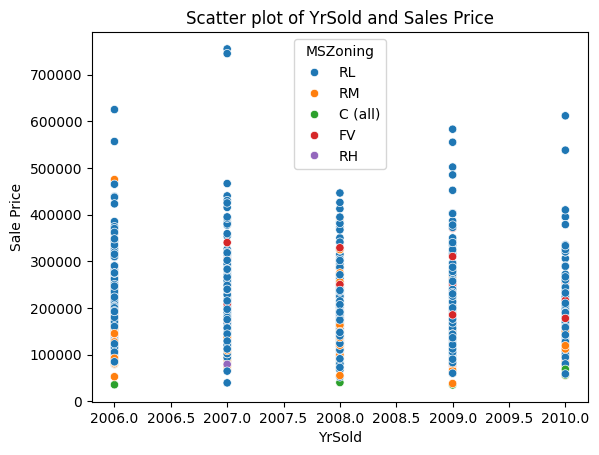

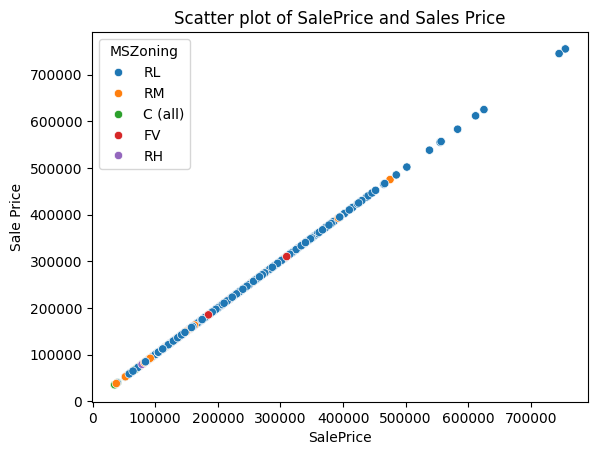

In [23]:
for col in numeric_variable:
    sns.scatterplot(x=col,y='SalePrice', data= df_train, hue = 'MSZoning')
    plt.xlabel(col)
    plt.ylabel('Sale Price')
    plt.title(f'Scatter plot of {col} and Sales Price')
    plt.show()

## Feature Selection 

In [24]:
# Creation of x variable and y variable
df_train_x = df_train.drop(columns='SalePrice').copy()
df_train_y = df_train[['SalePrice']]

Ordinal Encoder is used because there was an issue of using one hot encoder for doing feature selection.

By using one hot encoder for fs, it created a situation where there was over 200+ variable and it was all split into true and false. Therefore, if i accidentally only select the best performing varible, an issue may arise where I only select partially of the variable. For example:

* Pave Driveway
 * True (1) - Could have a high score
 * False (0) - Could have a low score
 
I could have only selected the true and therefore conduct the feature selection wrong.

In [25]:
# Define categorical columns
categorical_columns = [
    'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
    'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 
    'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 
    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 
    'SaleCondition'
]

# Copy dataframe to maintain original
df_encoded = df_train_x.copy()

# Initialize OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform categorical columns
df_encoded[categorical_columns] = encoder.fit_transform(df_train_x[categorical_columns])

# Show encoded dataframe
df_encoded.head()

MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  Utilities  \
0          60       3.0     8450     1.0       3.0          3.0        0.0   
1          20       3.0     9600     1.0       3.0          3.0        0.0   
2          60       3.0    11250     1.0       0.0          3.0        0.0   
3          70       3.0     9550     1.0       0.0          3.0        0.0   
4          60       3.0    14260     1.0       0.0          3.0        0.0   

   LotConfig  LandSlope  Neighborhood  ...  OpenPorchSF  EnclosedPorch  \
0        4.0        0.0           5.0  ...           61              0   
1        2.0        0.0          24.0  ...            0              0   
2        4.0        0.0           5.0  ...           42              0   
3        0.0        0.0           6.0  ...           35            272   
4        2.0        0.0          15.0  ...           84              0   

   3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SaleType  \
0          0            0         0        0       2    2008       8.0   
1          0            0         0        0       5    2007       8.0   
2          0            0         0        0       9    2008       8.0   
3          0            0         0        0       2    2006       8.0   
4          0            0         0        0      12    2008       8.0   

   SaleCondition  
0            4.0  
1            4.0  
2            4.0  
3            0.0  
4            4.0  

[5 rows x 72 columns]

In [26]:
X = df_encoded.values
y = df_train_y.values

In [27]:
X

array([[6.000e+01, 3.000e+00, 8.450e+03, ..., 2.008e+03, 8.000e+00,
        4.000e+00],
       [2.000e+01, 3.000e+00, 9.600e+03, ..., 2.007e+03, 8.000e+00,
        4.000e+00],
       [6.000e+01, 3.000e+00, 1.125e+04, ..., 2.008e+03, 8.000e+00,
        4.000e+00],
       ...,
       [7.000e+01, 3.000e+00, 9.042e+03, ..., 2.010e+03, 8.000e+00,
        4.000e+00],
       [2.000e+01, 3.000e+00, 9.717e+03, ..., 2.010e+03, 8.000e+00,
        4.000e+00],
       [2.000e+01, 3.000e+00, 9.937e+03, ..., 2.008e+03, 8.000e+00,
        4.000e+00]])

In [28]:
y

array([[208500],
       [181500],
       [223500],
       ...,
       [266500],
       [142125],
       [147500]], dtype=int64)

In [29]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

### Mutual Information 

#### All variable

In [30]:
# feature selection
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=mutual_info_regression, k='all')
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature 0: 0.269779
Feature 1: 0.148913
Feature 2: 0.154330
Feature 3: 0.002280
Feature 4: 0.051223
Feature 5: 0.016109
Feature 6: 0.004849
Feature 7: 0.027717
Feature 8: 0.011997
Feature 9: 0.532007
Feature 10: 0.000640
Feature 11: 0.000000
Feature 12: 0.030116
Feature 13: 0.090282
Feature 14: 0.579409
Feature 15: 0.140196
Feature 16: 0.373069
Feature 17: 0.246598
Feature 18: 0.024595
Feature 19: 0.000000
Feature 20: 0.147208
Feature 21: 0.165728
Feature 22: 0.097677
Feature 23: 0.329374
Feature 24: 0.000020
Feature 25: 0.204626
Feature 26: 0.325384
Feature 27: 0.000000
Feature 28: 0.083072
Feature 29: 0.117877
Feature 30: 0.123024
Feature 31: 0.011638
Feature 32: 0.000000
Feature 33: 0.154722
Feature 34: 0.392672
Feature 35: 0.014209
Feature 36: 0.164290
Feature 37: 0.042764
Feature 38: 0.045324
Feature 39: 0.313789
Feature 40: 0.199279
Feature 41: 0.001649
Feature 42: 0.472430
Feature 43: 0.014080
Feature 44: 0.000000
Feature 45: 0.287159
Feature 46: 0.070386
Feature 47: 0.059362
Fe

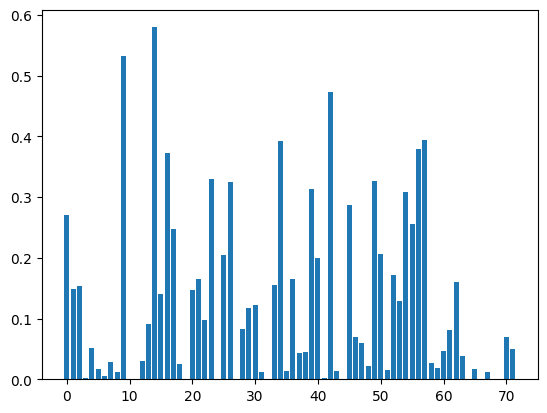

In [31]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

#### Top 10 Variable

In [32]:
def select_top_features(X_train, y_train, X_test, k=10):
    # Configure SelectKBest to select top k features
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    # Learn relationship from training data
    fs.fit(X_train, y_train)
    # Transform train and test input data
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)

    # Get scores and indices of top k features
    feature_scores = fs.scores_
    top_k_indices = np.argsort(feature_scores)[-k:][::-1]
    top_k_scores = feature_scores[top_k_indices]

    return X_train_fs, X_test_fs, top_k_indices, top_k_scores

c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature 14: 0.5523695817942413
Feature 9: 0.5341650959243935
Feature 42: 0.47164764984820806
Feature 34: 0.3921485266194864
Feature 56: 0.39057957605684623
Feature 57: 0.38964947806784256
Feature 16: 0.36425217410302935
Feature 26: 0.33899708341396684
Feature 49: 0.32960310380761815
Feature 23: 0.32232269785992784
Feature 39: 0.3126814671758451
Feature 54: 0.3004033261640995
Feature 45: 0.27627423519594907
Feature 0: 0.27258492437884385
Feature 17: 0.2513735098103287
Feature 55: 0.23706798373275406
Feature 40: 0.21600727228422434
Feature 25: 0.21449798218734895
Feature 50: 0.2085395690247882
Feature 33: 0.15581116282197183


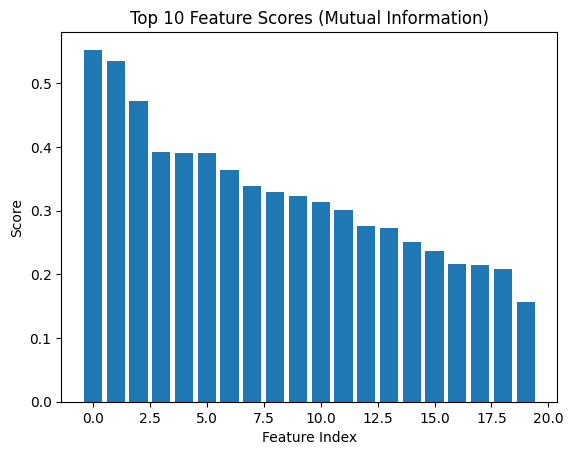

In [33]:
# Assuming you have already loaded and split your data as in your example
X_train_fs, X_test_fs, top_indices, top_scores = select_top_features(X_train, y_train, X_test, k=20)

# Print scores of the top 10 features
for i, score in zip(top_indices, top_scores):
    print(f'Feature {i}: {score}')

# Plot the scores
plt.bar([i for i in range(len(top_scores))], top_scores)
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.title('Top 10 Feature Scores (Mutual Information)')
plt.show()


### Correlation

#### All Variable

In [34]:
# feature selection
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=f_regression, k='all')
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs
 

c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature 0: 9.185921
Feature 1: 42.281789
Feature 2: 103.706647
Feature 3: 1.155709
Feature 4: 79.174322
Feature 5: 0.204717
Feature 6: 0.000000
Feature 7: 3.527787
Feature 8: 0.828671
Feature 9: 56.011549
Feature 10: 6.021905
Feature 11: 0.000304
Feature 12: 8.153754
Feature 13: 31.498750
Feature 14: 1745.185700
Feature 15: 14.355062
Feature 16: 419.704710
Feature 17: 348.638876
Feature 18: 60.221125
Feature 19: 18.799432
Feature 20: 9.139618
Feature 21: 11.056733
Feature 22: 317.358343
Feature 23: 767.887399
Feature 24: 19.210166
Feature 25: 207.454025
Feature 26: 692.507023
Feature 27: 4.652695
Feature 28: 110.378942
Feature 29: 8.040914
Feature 30: 169.300923
Feature 31: 0.595248
Feature 32: 0.086525
Feature 33: 59.507590
Feature 34: 643.867240
Feature 35: 7.794216
Feature 36: 226.268905
Feature 37: 61.731569
Feature 38: 51.763728
Feature 39: 645.301349
Feature 40: 108.826023
Feature 41: 3.433839
Feature 42: 1046.118191
Feature 43: 49.083688
Feature 44: 0.003923
Feature 45: 528.1266

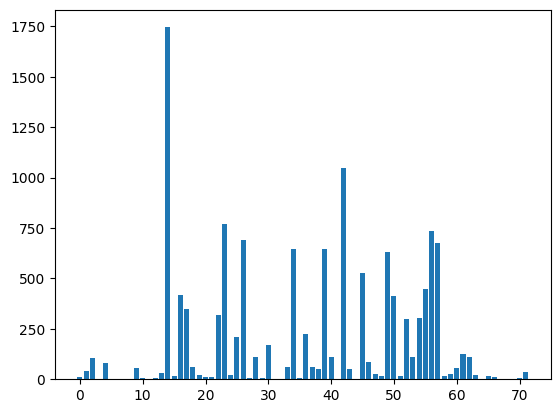

In [35]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

#### Top 10 Variable

In [36]:
def select_top_features(X_train, y_train, X_test, k=10):
    # Configure SelectKBest to select top k features
    fs = SelectKBest(score_func=f_regression, k=k)
    # Learn relationship from training data
    fs.fit(X_train, y_train)
    # Transform train and test input data
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)

    # Get scores and indices of top k features
    feature_scores = fs.scores_
    top_k_indices = np.argsort(feature_scores)[-k:][::-1]
    top_k_scores = feature_scores[top_k_indices]

    return X_train_fs, X_test_fs, top_k_indices, top_k_scores

c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature 14: 1745.1857000663142
Feature 42: 1046.1181911689137
Feature 23: 767.8873985921758
Feature 56: 735.471041682181
Feature 26: 692.5070233893296
Feature 57: 676.9999505088505
Feature 39: 645.3013493833715
Feature 34: 643.8672399320883
Feature 49: 631.3131933393228
Feature 45: 528.1266446891827
Feature 55: 448.9981364632118
Feature 16: 419.7047099828792
Feature 50: 413.33747282552514
Feature 17: 348.63887604825703
Feature 22: 317.35834344008344
Feature 54: 303.64180231894096
Feature 52: 298.56760402058444
Feature 36: 226.26890540686895
Feature 25: 207.45402513566395
Feature 30: 169.30092301696058


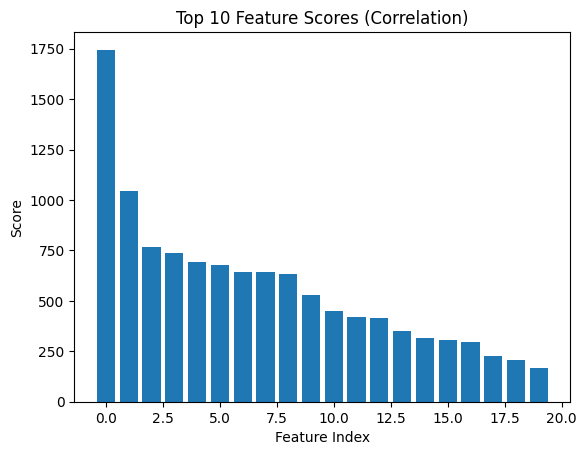

In [37]:
# Assuming you have already loaded and split your data as in your example
X_train_fs, X_test_fs, top_indices, top_scores = select_top_features(X_train, y_train, X_test, k=20)

# Print scores of the top 10 features
for i, score in zip(top_indices, top_scores):
    print(f'Feature {i}: {score}')

# Plot the scores
plt.bar([i for i in range(len(top_scores))], top_scores)
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.title('Top 10 Feature Scores (Correlation)')
plt.show()


### FS Selection

Both the table below show the top 20 feature selection conducted by the technique.

**Mutual Information**
| Independent Variable|  Score| Overlap |
| --------- |:-------------:|:-------------:| 
|Feature 14 | 0.56 |x|
|Feature 9  | 0.51||
|Feature 42 | 0.43|x|
|Feature 57 | 0.39||
|Feature 34 | 0.38|x|
|Feature 56 | 0.35|x|
|Feature 16 | 0.34|x|
|Feature 49 | 0.33||
|Feature 26 | 0.33|x|
|Feature 23 | 0.32|x|
|Feature 39 | 0.30|x|
|Feature 0  | 0.29||
|Feature 54 | 0.26|x|
|Feature 17 | 0.26|x|
|Feature 45 | 0.26|x|
|Feature 55 | 0.23|x|
|Feature 40 | 0.21||
|Feature 25 | 0.18||
|Feature 50 | 0.17|x|
|Feature 36 | 0.17|x|

**Correlation**
| Independent Variable|  Score| Overlap |
| --------- |:-------------:|:-------------:| 
|Feature 14| 1766|x|
|Feature 42| 1027|x|
|Feature 56| 744|x|
|Feature 57| 693||
|Feature 26| 659|x|
|Feature 23| 634|x|
|Feature 34| 624|x|
|Feature 39| 597|x|
|Feature 49| 513||
|Feature 45| 492|x|
|Feature 55| 437|x|
|Feature 16| 403|x|
|Feature 17| 382|x|
|Feature 50| 375|x|
|Feature 52| 308||
|Feature 22| 302||
|Feature 54| 290|x|
|Feature 36| 206|x|
|Feature 30| 197||
|Feature 25| 184||

Only feature with overlapping will be selected.

Feature Selection
| Variable No|  
| --------- |
|Feature 14|
|Feature 16| 
|Feature 17|
|Feature 23|
|Feature 26|
|Feature 34| 
|Feature 36|
|Feature 39|  
|Feature 42| 
|Feature 45|
|Feature 50| 
|Feature 54|
|Feature 55|
|Feature 56| 

 
 
 
 
 
 
 


In [38]:
# Getting the feature variable by name
fs_top_14 = [14,16,17,23,26,34,36,39,42,45,50,54,55,56]
for i,j in enumerate(df_train.columns):
    if i in fs_top_14:
        print(j)

OverallQual
YearBuilt
YearRemodAdd
ExterQual
BsmtQual
TotalBsmtSF
HeatingQC
1stFlrSF
GrLivArea
FullBath
TotRmsAbvGrd
GarageYrBlt
GarageFinish
GarageCars


## Model

#### Preparation for Model Building

In [39]:
# Creation of a new df to built the initial model
df = df_train[[
    'OverallQual',
    'YearBuilt',
    'YearRemodAdd',
    'ExterQual',
    'BsmtQual',
    'TotalBsmtSF',
    'HeatingQC',
    '1stFlrSF',
    'GrLivArea',
    'FullBath',
    'TotRmsAbvGrd',
    'GarageYrBlt',
    'GarageFinish',
    'SalePrice']]

In [40]:
# Preparing the X and y values for the model training
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [41]:
X

array([[7, 2003, 2003, ..., 8, 2003.0, 'RFn'],
       [6, 1976, 1976, ..., 6, 1976.0, 'RFn'],
       [7, 2001, 2002, ..., 6, 2001.0, 'RFn'],
       ...,
       [7, 1941, 2006, ..., 9, 1941.0, 'RFn'],
       [5, 1950, 1996, ..., 5, 1950.0, 'Unf'],
       [5, 1965, 1965, ..., 6, 1965.0, 'Fin']], dtype=object)

In [42]:
y

array([208500, 181500, 223500, ..., 266500, 142125, 147500], dtype=int64)

In [43]:
encoder_variable = [3,4,6,12]
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3,4,6,12])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [44]:
X[1]

array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 1.0, 0.0, 6, 1976, 1976, 1262, 1262, 1262, 2, 6, 1976.0],
      dtype=object)

In [45]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

In [46]:
# Feature Scaling
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

### Linear Regression - Model 0

In [47]:
# Model Building
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [48]:
# Predict the test result
y_pred = model.predict(X_test)

In [49]:
# Y Predict Result
y_pred

array([266971.74467652, 178382.46436588, 108471.33148405, 210669.41412908,
       226547.19541704, 287840.46521526, 212937.45202083, 111114.61058463,
       149932.40788117, 107286.64041937, 245962.32202031, 189987.49736569,
       118264.08399279, 171449.6798041 , 239151.38275677, 218169.42425085,
       109022.09380602,  90891.9736203 , 145551.54972191, 103501.30957142,
       277633.63387261, 145057.74826227, 249855.05752842, 136668.48812585,
       219828.854871  , 276547.8852869 , 105711.41970367, 149867.2049219 ,
        92514.53130186, 143713.76344164, 405284.21231607, 142697.85867356,
       172763.09991084, 174449.58825927, 286558.63257793, 113784.7095773 ,
       107074.95502489, 179559.97341597, 130123.91636342, 186665.4127182 ,
       232876.85943773, 211369.30151047, 140649.75079374, 105645.3261667 ,
       120901.02433607, 184987.66138397, 180801.45066044, 217736.83361765,
       125430.03798641, 145716.8459652 ,  79800.21059313, 338064.02488053,
       129255.37369417, 1

In [50]:
# Actual y value
y_test

array([287000, 165150, 122000, 189000, 194500, 372402, 257500, 141000,
       148000, 122900, 249700, 185000, 110000, 178000, 263000, 202500,
       126000, 111250, 147000, 107900, 305900, 139500, 230000, 140000,
       244400, 240000, 105000, 124900,  87000, 128000, 437154, 165000,
       188000, 112000, 328000, 110000, 127000, 154300, 143000, 187500,
       248328, 226700, 153000, 134800, 138500, 175900, 188000, 279500,
       120500, 155000,  75500, 277500, 130500,  66500,  86000, 170000,
       187500, 190000, 360000, 185500, 171000, 191000,  55993, 119200,
       295493, 226000,  98300, 112000, 159500, 260000, 139900, 108000,
       145500, 248000, 241500, 307000, 130000, 176000, 212000, 129000,
       164000, 256300,  87000, 345000, 158900, 189950, 119900, 140000,
       196000,  60000, 440000, 180500, 172500, 167000, 230000, 157500,
       136500, 348000, 127000, 142953,  82000, 179665, 438780,  58500,
       248900, 192000, 122500, 402000, 178000, 140000, 144152, 154000,
      

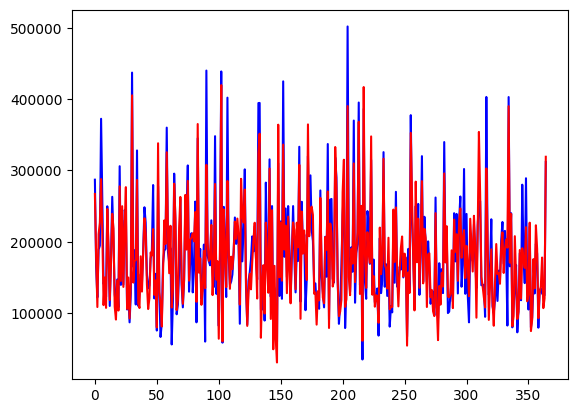

In [51]:
# Plot the test vs prediction data

plt.plot(y_test, color='blue', label='test')
plt.plot(y_pred, color='red', label='predictions')
plt.show()

In [52]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
me = max_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
mae = median_absolute_error(y_test, y_pred)

print(f'RMSE of the logarithm of the predicted housing price: {rmse}')
print(f'R square of the logarithm of the predicted housing price: {r2}')
print(f'Max Error of the logarithm of the predicted housing price: {me}')
print(f'Explained Varianec Score  of the logarithm of the predicted housing price: {evs}')
print(f'Median Absolute Error of the logarithm of the predicted housing price: {mae}')


RMSE of the logarithm of the predicted housing price: 30496.306953747593
R square of the logarithm of the predicted housing price: 0.8504217471004115
Max Error of the logarithm of the predicted housing price: 132211.97198668006
Explained Varianec Score  of the logarithm of the predicted housing price: 0.8505057855871395
Median Absolute Error of the logarithm of the predicted housing price: 16347.587286612135


### Logistic Regression - Model 1

In [53]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

c:\Users\Sam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [54]:
y_pred_1 = model_1.predict(X_test)

In [55]:
y_pred_1

array([200000, 140000, 110000, 190000, 215000, 160000, 160000, 110000,
       143000,  88000, 160000, 190000, 140000, 140000, 200000, 190000,
       140000, 110000, 140000, 110000, 385000, 140000, 200000, 140000,
       160000, 160000, 100000, 160000, 100000, 140000, 315000, 143000,
       160000, 126000, 200000, 110000, 140000, 200000, 147000, 180000,
       160000, 155000, 140000, 110000, 110000, 140000, 140000, 192000,
       120500, 110000,  86000, 160000, 140000, 140000,  86000, 143000,
       140000, 143000, 160000, 143000, 140000, 180000, 140000, 110000,
       160000, 200000,  82000, 140000, 197000, 160000, 170000, 110000,
       110000, 200000, 143000, 160000, 190000, 190000, 140000, 160000,
       143000, 160000, 140000, 200000, 140000, 140000, 140000, 110000,
       143000, 143000, 385000, 143000, 155000, 160000, 160000, 140000,
       190000, 160000, 170000, 197000,  82000, 140000, 250000, 110000,
       160000, 155000, 140000, 160000, 140000, 140000,  88000, 140000,
      

In [56]:
y_test

array([287000, 165150, 122000, 189000, 194500, 372402, 257500, 141000,
       148000, 122900, 249700, 185000, 110000, 178000, 263000, 202500,
       126000, 111250, 147000, 107900, 305900, 139500, 230000, 140000,
       244400, 240000, 105000, 124900,  87000, 128000, 437154, 165000,
       188000, 112000, 328000, 110000, 127000, 154300, 143000, 187500,
       248328, 226700, 153000, 134800, 138500, 175900, 188000, 279500,
       120500, 155000,  75500, 277500, 130500,  66500,  86000, 170000,
       187500, 190000, 360000, 185500, 171000, 191000,  55993, 119200,
       295493, 226000,  98300, 112000, 159500, 260000, 139900, 108000,
       145500, 248000, 241500, 307000, 130000, 176000, 212000, 129000,
       164000, 256300,  87000, 345000, 158900, 189950, 119900, 140000,
       196000,  60000, 440000, 180500, 172500, 167000, 230000, 157500,
       136500, 348000, 127000, 142953,  82000, 179665, 438780,  58500,
       248900, 192000, 122500, 402000, 178000, 140000, 144152, 154000,
      

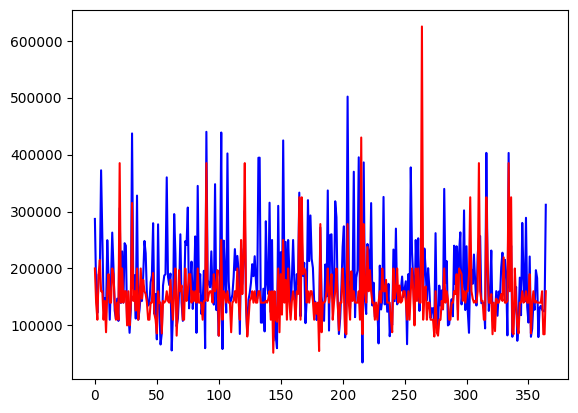

In [57]:
# Plot the test vs prediction data

plt.plot(y_test, color='blue', label='test')
plt.plot(y_pred_1, color = 'red', label = 'prediction')
plt.show()

In [58]:
rmse= np.sqrt(mean_squared_error(y_test, y_pred_1))
r2 = r2_score(y_test, y_pred_1)
me = max_error(y_test, y_pred_1)
evs = explained_variance_score(y_test, y_pred_1)
mae = median_absolute_error(y_test, y_pred_1)

print(f'RMSE of the logarithm of the predicted housing price: {rmse}')
print(f'R square of the logarithm of the predicted housing price: {r2}')
print(f'Max Error of the logarithm of the predicted housing price: {me}')
print(f'Explained Varianec Score  of the logarithm of the predicted housing price: {evs}')
print(f'Median Absolute Error of the logarithm of the predicted housing price: {mae}')

RMSE of the logarithm of the predicted housing price: 69347.92033084841
R square of the logarithm of the predicted housing price: 0.22653469253137848
Max Error of the logarithm of the predicted housing price: 305000
Explained Varianec Score  of the logarithm of the predicted housing price: 0.33606963004161194
Median Absolute Error of the logarithm of the predicted housing price: 33733.0


### Ridge Regression - Model 2

In [59]:
model_2 = Ridge(alpha=1.0)
model_2.fit(X_train, y_train)

Ridge()

In [60]:
y_pred_2 = model_2.predict(X_test)

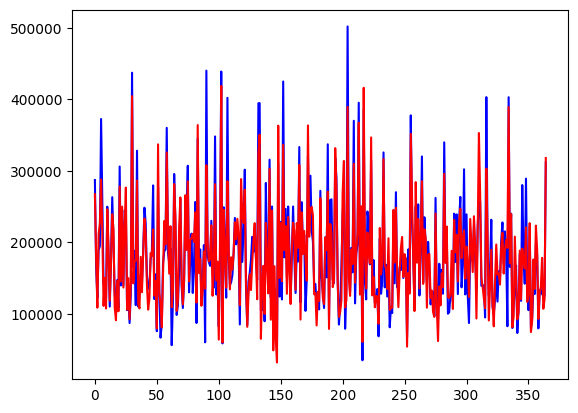

In [61]:
# Plot the test vs prediction data

plt.plot(y_test, color='blue', label='test')
plt.plot(y_pred_2, color = 'red', label = 'prediction')
plt.show()

In [62]:
rmse= np.sqrt(mean_squared_error(y_test, y_pred_2))
r2 = r2_score(y_test, y_pred_2)
me = max_error(y_test, y_pred_2)
evs = explained_variance_score(y_test, y_pred_2)
mae = median_absolute_error(y_test, y_pred_2)

print(f'RMSE of the logarithm of the predicted housing price: {rmse}')
print(f'R square of the logarithm of the predicted housing price: {r2}')
print(f'Max Error of the logarithm of the predicted housing price: {me}')
print(f'Explained Varianec Score  of the logarithm of the predicted housing price: {evs}')
print(f'Median Absolute Error of the logarithm of the predicted housing price: {mae}')

RMSE of the logarithm of the predicted housing price: 30479.350096702958
R square of the logarithm of the predicted housing price: 0.8505880408030931
Max Error of the logarithm of the predicted housing price: 132191.5214020739
Explained Varianec Score  of the logarithm of the predicted housing price: 0.8506784035313111
Median Absolute Error of the logarithm of the predicted housing price: 16323.570451511187


### Lasso Regression - Model 3

In [63]:
model_3 = Lasso(alpha=0.1)
model_3.fit(X_train, y_train)

Lasso(alpha=0.1)

In [64]:
y_pred_3 = model_3.predict(X_test)

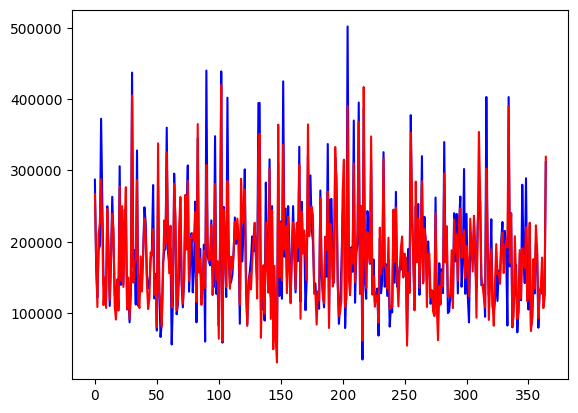

In [65]:
# Plot the test vs prediction data

plt.plot(y_test, color='blue', label='test')
plt.plot(y_pred_3, color = 'red', label = 'prediction')
plt.show()

In [66]:
rmse= np.sqrt(mean_squared_error(y_test, y_pred_3))
r2 = r2_score(y_test, y_pred_3)
me = max_error(y_test, y_pred_3)
evs = explained_variance_score(y_test, y_pred_3)
mae = median_absolute_error(y_test, y_pred_3)

print(f'RMSE of the logarithm of the predicted housing price: {rmse}')
print(f'R square of the logarithm of the predicted housing price: {r2}')
print(f'Max Error of the logarithm of the predicted housing price: {me}')
print(f'Explained Varianec Score  of the logarithm of the predicted housing price: {evs}')
print(f'Median Absolute Error of the logarithm of the predicted housing price: {mae}')

RMSE of the logarithm of the predicted housing price: 30496.257042801757
R square of the logarithm of the predicted housing price: 0.8504222367063157
Max Error of the logarithm of the predicted housing price: 132212.08926953655
Explained Varianec Score  of the logarithm of the predicted housing price: 0.8505063020190139
Median Absolute Error of the logarithm of the predicted housing price: 16347.309465686209


### Elastic Net - Model 4

In [67]:
model_4 = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_4.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [68]:
y_pred_4 = model_4.predict(X_test)

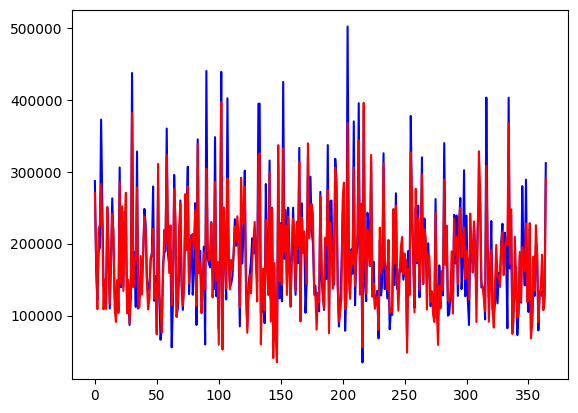

In [69]:
# Plot the test vs prediction data

plt.plot(y_test, color='blue', label='test')
plt.plot(y_pred_4, color = 'red', label = 'prediction')
plt.show()

In [70]:
rmse= np.sqrt(mean_squared_error(y_test, y_pred_4))
r2 = r2_score(y_test, y_pred_4)
me = max_error(y_test, y_pred_4)
evs = explained_variance_score(y_test, y_pred_4)
mae = median_absolute_error(y_test, y_pred_4)

print(f'RMSE of the logarithm of the predicted housing price: {rmse}')
print(f'R square of the logarithm of the predicted housing price: {r2}')
print(f'Max Error of the logarithm of the predicted housing price: {me}')
print(f'Explained Varianec Score  of the logarithm of the predicted housing price: {evs}')
print(f'Median Absolute Error of the logarithm of the predicted housing price: {mae}')

RMSE of the logarithm of the predicted housing price: 30863.295128971728
R square of the logarithm of the predicted housing price: 0.8468000797219088
Max Error of the logarithm of the predicted housing price: 135684.32281078165
Explained Varianec Score  of the logarithm of the predicted housing price: 0.8470241887710002
Median Absolute Error of the logarithm of the predicted housing price: 16182.211185176391


### Robust Regression - Model 5

In [71]:
from sklearn.linear_model import RANSACRegressor

model_5 = RANSACRegressor()
model_5.fit(X_train, y_train)

RANSACRegressor()

In [72]:
y_pred_5 = model_5.predict(X_test)

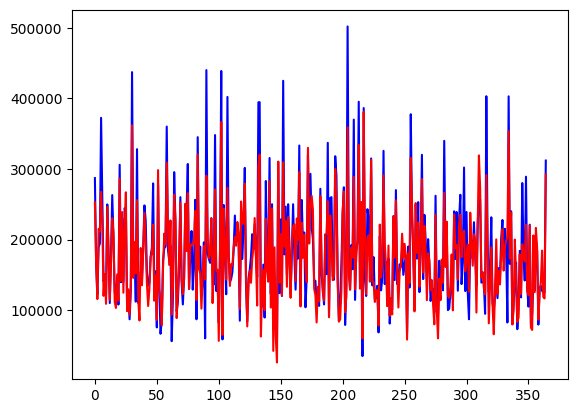

In [73]:
# Plot the test vs prediction data
plt.plot(y_test, color='blue', label='test')
plt.plot(y_pred_5, color = 'red', label = 'prediction')
plt.show()

In [74]:
rmse= np.sqrt(mean_squared_error(y_test, y_pred_5))
r2 = r2_score(y_test, y_pred_5)
me = max_error(y_test, y_pred_5)
evs = explained_variance_score(y_test, y_pred_5)
mae = median_absolute_error(y_test, y_pred_5)

print(f'RMSE of the logarithm of the predicted housing price: {rmse}')
print(f'R square of the logarithm of the predicted housing price: {r2}')
print(f'Max Error of the logarithm of the predicted housing price: {me}')
print(f'Explained Varianec Score  of the logarithm of the predicted housing price: {evs}')
print(f'Median Absolute Error of the logarithm of the predicted housing price: {mae}')

RMSE of the logarithm of the predicted housing price: 33095.976099415035
R square of the logarithm of the predicted housing price: 0.8238330869790479
Max Error of the logarithm of the predicted housing price: 149538.4548344796
Explained Varianec Score  of the logarithm of the predicted housing price: 0.8289027661521571
Median Absolute Error of the logarithm of the predicted housing price: 15485.633954042336


## Result & Intepretation 

| Model                 | RMSE   |  R-Square  |  Max Error  |  Explained Variance Score  |  Median Absolute Error  | 
| ----------------------|:------:|:----------:|:-----------:|:--------------------------:|:-----------------------:|
| Linear Regression     | 30496  | 0.85       | 132211      |    0.85                    | 16347                   | 
| Logistic Regression   | 69347  | 0.23       | 305000      |    0.34                    | 33733                   | 
| Ridge Regression      | 30479  | 0.85       | 132191      |    0.85                    | 16323                   | 
| Lasso Regression      | 30496  | 0.85       | 132212      |    0.85                    | 16347                   | 
| Elastic Net           | 30863  | 0.85       | 135684      |    0.85                    | 16182                   |
| Robust Regression     | 33095  | 0.82       | 149538      |    0.83                    | 15485                   | 

Based on the result, the RMSE is very high compared to the requirment of below 1500 RMSE. It could be assume that further reselection of feature selection is requirement to built a robust model.